In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from abc import ABC, abstractmethod
import imageio
import os
#%matplotlib qt

In [2]:
#!pip install pipreqs 

In [3]:
#!pipreqs "visualize gd.ipynb"

In [4]:
class optimizer(ABC):
    
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
    
    @abstractmethod
    def apply_gradients(self, grads_and_vars):
        pass

In [5]:
class batch_gradient_descent(optimizer):
    
    def apply_gradients(self, grads_and_vars):
        for grad, var in grads_and_vars:
            var.assign_sub(self.learning_rate * grad)     

In [6]:
class momentum(optimizer):
    
    def __init__(self, learning_rate, beta=0.9):
        self.v = [0] * 2
        self.beta = beta
        super().__init__(learning_rate)
    
    def apply_gradients(self, grads_and_vars):
        i = 0
        for grad, var in grads_and_vars:
            self.v[i] = self.beta * self.v[i] - self.learning_rate * grad
            var.assign_add(self.v[i])
            i += 1

In [7]:
class adagrad(optimizer):
    
    def __init__(self, learning_rate):
        self.v = [0] * 2
        super().__init__(learning_rate)
    
    def apply_gradients(self, grads_and_vars):
        i = 0
        for grad, var in grads_and_vars:
            self.v[i] = self.v[i] + grad**2
            var.assign_sub((self.learning_rate*grad)/self.v[i]**(1/2))
            i += 1

In [8]:
class adam(optimizer):
    
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08):
        self.u = [0] * 2
        self.v = [0] * 2
        self.t = 1
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        super().__init__(learning_rate)
    
    def apply_gradients(self, grads_and_vars):
        i = 0
        for grad, var in grads_and_vars:
            self.u[i] = self.beta1 * self.u[i] + (1-self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1-self.beta2) * grad**2
            u_hat = self.u[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)
            var.assign_sub((self.learning_rate * u_hat) / (v_hat**(1/2) + self.epsilon))
            i += 1
        self.t += 1

In [77]:
class min_function:

    def __init__(self, function, start, global_min, learning_rate=1, optimizers=["gd", "adam", "adagrad", "momentum"]):
        self.function = function
        self.start = start
        self.global_min = global_min
        self.learning_rate = learning_rate
        self.optimizers = optimizers
        self.colors = [np.random.rand(3,) for _ in range(len(optimizers))]
        self.x_data, self.y_data, self.z_data = [[] for _ in range(len(optimizers))], [[] for _ in range(len(optimizers))], [[] for _ in range(len(optimizers))]
        for i, optimizer in enumerate(optimizers):
            opt = self.get_optimizer(optimizer)
            xx, yy, zz = self.minimize(opt)
            self.x_data[i].extend(xx)
            self.y_data[i].extend(yy)
            self.z_data[i].extend(zz)

    def minimize(self, optimizer):
        x = tf.Variable(self.start[0])
        y = tf.Variable(self.start[1])
        x_list, y_list, z_list = [], [], []
        x_list.append(x.numpy())
        y_list.append(y.numpy())
        z_list.append(self.function(x.numpy(), y.numpy()))
        while(not np.allclose(np.array([x.numpy(), y.numpy()]), self.global_min, rtol=1e-01, atol=1e-02)):
            with tf.GradientTape() as tape:
                grads = (g.numpy() for g in tape.gradient(self.function(x, y), [x, y]))
            optimizer.apply_gradients(zip(grads, [x, y]))
            x_list.append(x.numpy())
            y_list.append(y.numpy())
            z_list.append(self.function(x.numpy(), y.numpy()))
        return (x_list, y_list, z_list)

    
    def get_optimizer(self, optimizer):
        if optimizer == 'gd':
            return batch_gradient_descent(self.learning_rate)
        elif optimizer == 'momentum':
            return momentum(self.learning_rate)
        elif optimizer == 'adagrad':
            return adagrad(self.learning_rate)
        elif optimizer == 'adam':
            return adam(self.learning_rate)
        # use keras optimizer if something isn't implemented
        else:
            opt = tf.keras.optimizers.get(optimizer)
            opt.lr = self.learning_rate
            return opt

    def plot2d(self, step=100, x_min=-4, x_max=4, y_min=-4, y_max=4):
        X = np.linspace(x_min, x_max, 256)
        Y = np.linspace(y_min, y_max, 256)
        XX, YY = np.meshgrid(X, Y)
        Z = self.function(XX, YY)
        plt.figure(dpi=200)
        ax = plt.subplot(111)
        for i in range(len(self.x_data)):
            index = int(step*(len(self.x_data[i])/100))
            ax.plot(self.x_data[i][:index], self.y_data[i][:index], '-', c=self.colors[i])
        ax.set_xlabel('x')
        ax.set_xlim(x_min - 1, x_max + 1)
        ax.set_ylabel('y')
        ax.set_ylim(y_min - 1, y_max + 1)
        ax.axis('off')
        ax.legend(self.optimizers)
        ax.contourf(XX, YY, Z, 25, alpha=0.6, cmap=cm.get_cmap('bwr'))
        plt.show()

    def plot3d(self, elev=60, azim=-75, x_min=-3, x_max=3, y_min=-3, y_max=3):
        X = np.linspace(x_min, x_max, 256)
        Y = np.linspace(y_min, y_max, 256)
        XX, YY = np.meshgrid(X, Y)
        Z = self.function(XX, YY)
        fig = plt.figure(dpi=300)
        ax = fig.gca(projection='3d')
        for i in range(len(self.x_data)):
            ax.plot(self.x_data[i], self.y_data[i], self.z_data[i], '-', c=self.colors[i])
        ax.plot_surface(XX, YY, Z, rstride=3, cstride=3, alpha=0.5, cmap=cm.get_cmap('coolwarm'), linewidth=0, antialiased=False)
        ax.set_xlabel('x')
        ax.set_xlim(x_min - 1, x_max + 1)
        ax.set_ylabel('y')
        ax.set_ylim(y_min - 1, y_max + 1)
        ax.set_zlabel('f(x,y)')
        ax.set_zlim(-1, np.max(Z))
        ax.view_init(elev=elev, azim=azim)
        ax.dist=12  
        ax.axis('off')
        ax.legend(self.optimizers)
        plt.show()
        
    def create_gif(self):
        filenames = []
        for i in range(100):
            self.plot2d(i)
            filename = f'{i}.png'
            filenames.append(filename)
            plt.savefig(filename)
            plt.close()
        with imageio.get_writer('mygif.gif', mode='I') as writer:
            for filename in filenames:
                image = imageio.imread(filename)
                writer.append_data(image)

        for filename in set(filenames):
            os.remove(filename)

In [70]:
f = lambda x, y: -tf.exp(-((x/2)**2 + 5 * (y/2)**2)) + (x/2)**2 + 0.5 * (y/2)**2

In [71]:
mm = min_function(f, [3., 3.], [0., 0.], 0.1)

(256, 256)
(256, 256)
(256, 256)


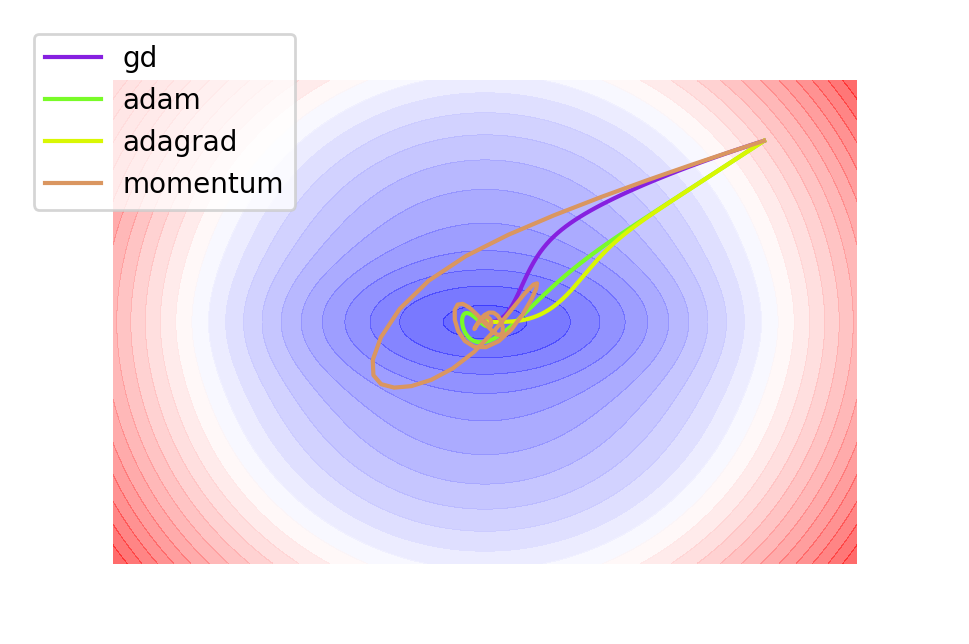

In [72]:
mm.plot2d()

(256, 256)
(256, 256)
(256, 256)


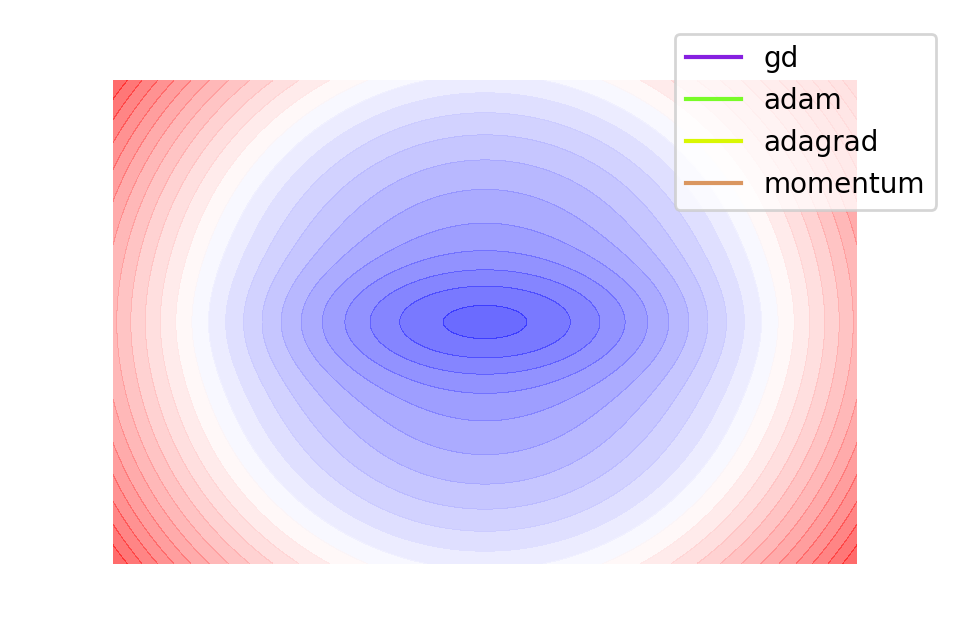

(256, 256)
(256, 256)
(256, 256)


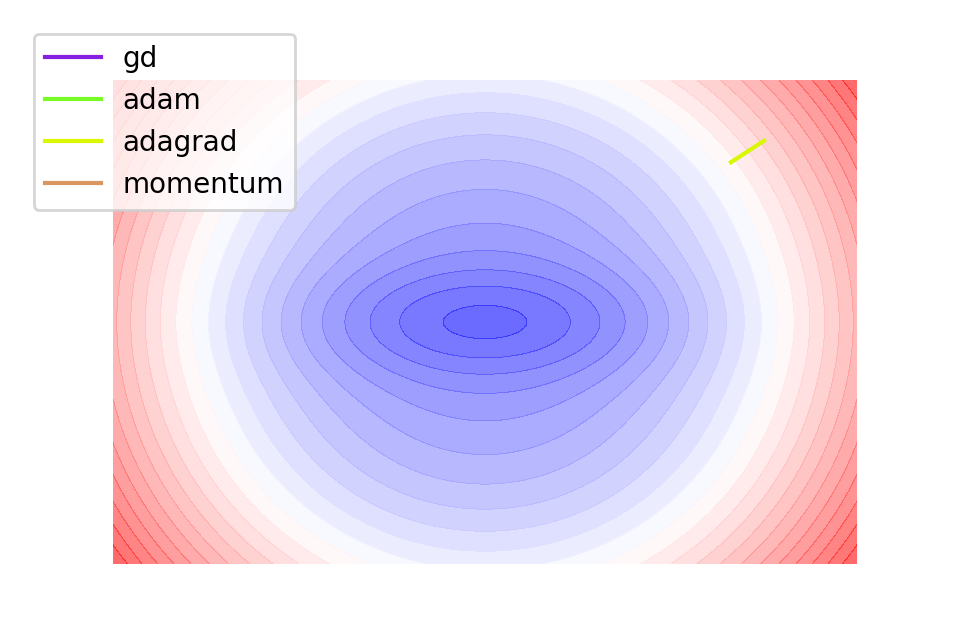

(256, 256)
(256, 256)
(256, 256)


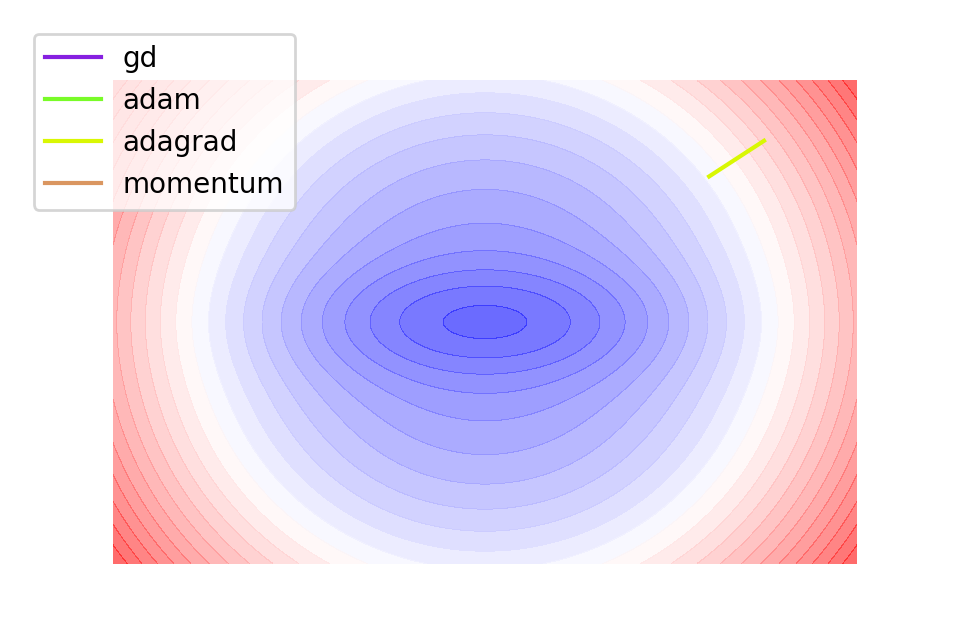

(256, 256)
(256, 256)
(256, 256)


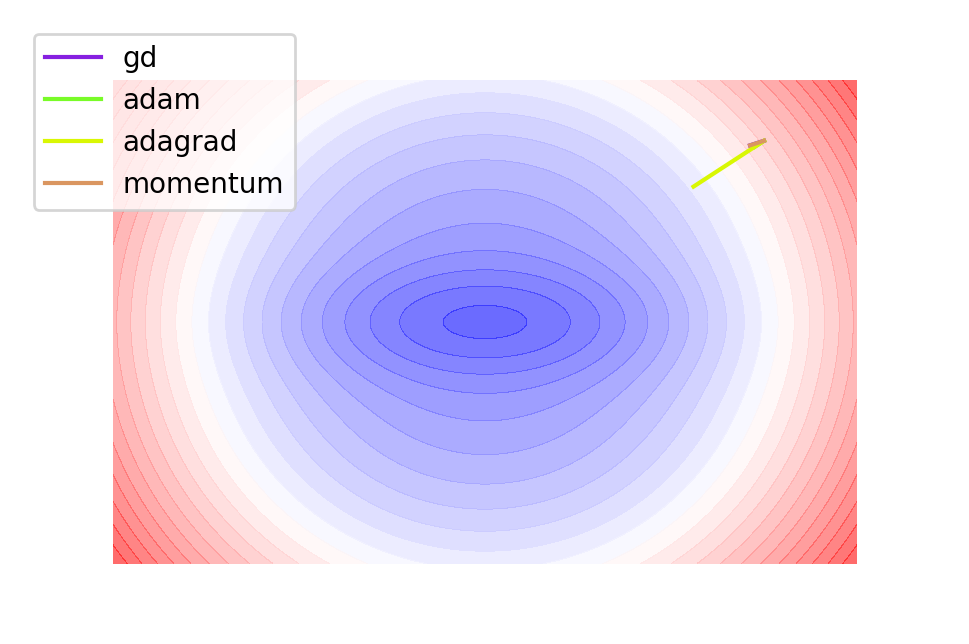

(256, 256)
(256, 256)
(256, 256)


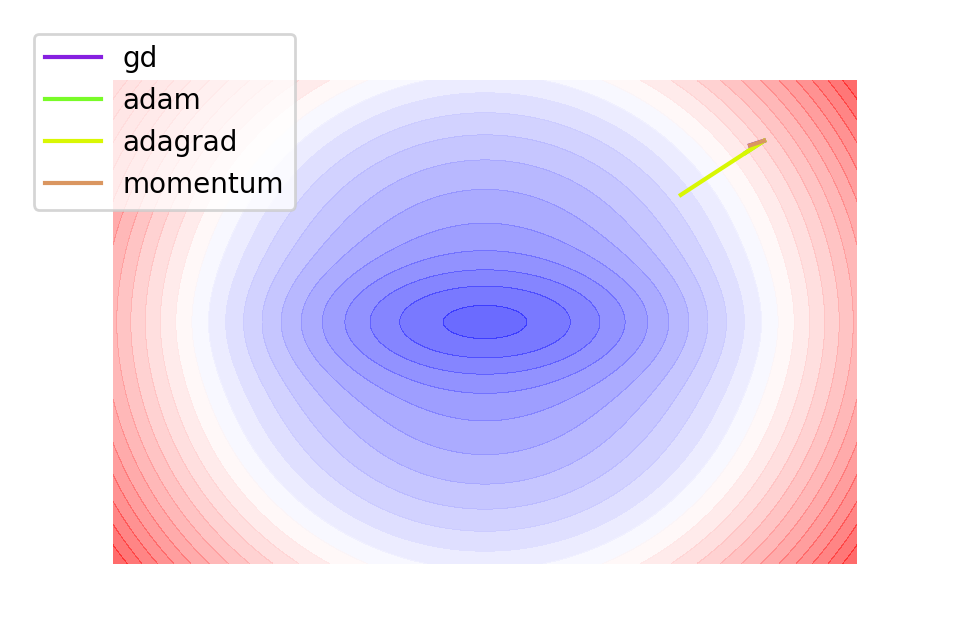

(256, 256)
(256, 256)
(256, 256)


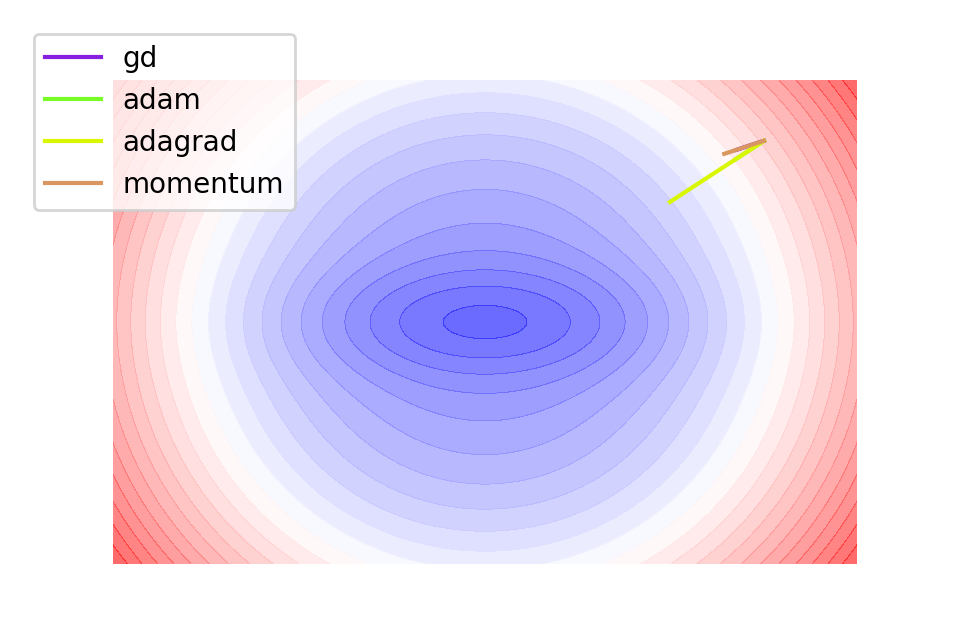

(256, 256)
(256, 256)
(256, 256)


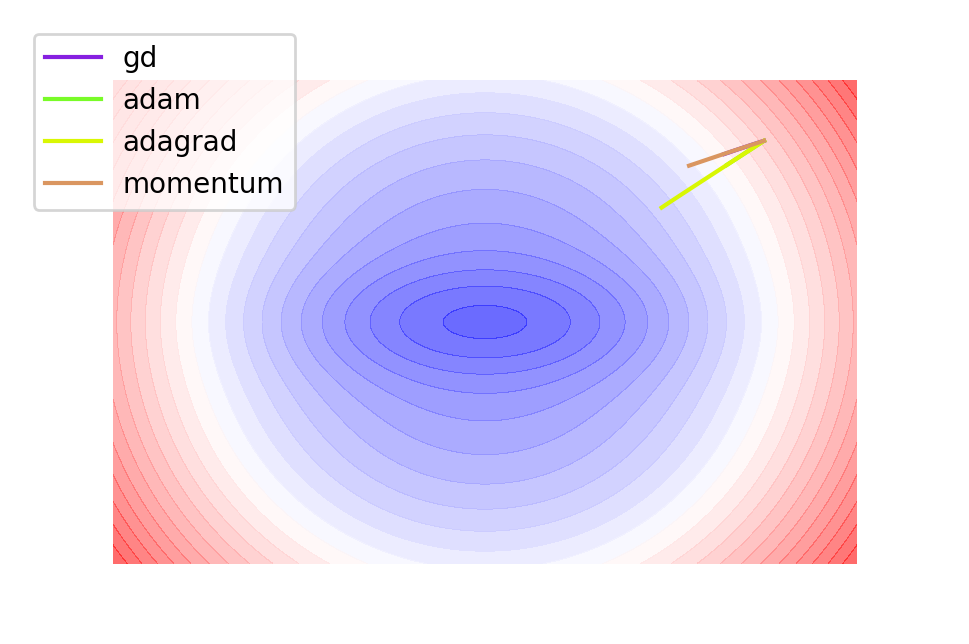

(256, 256)
(256, 256)
(256, 256)


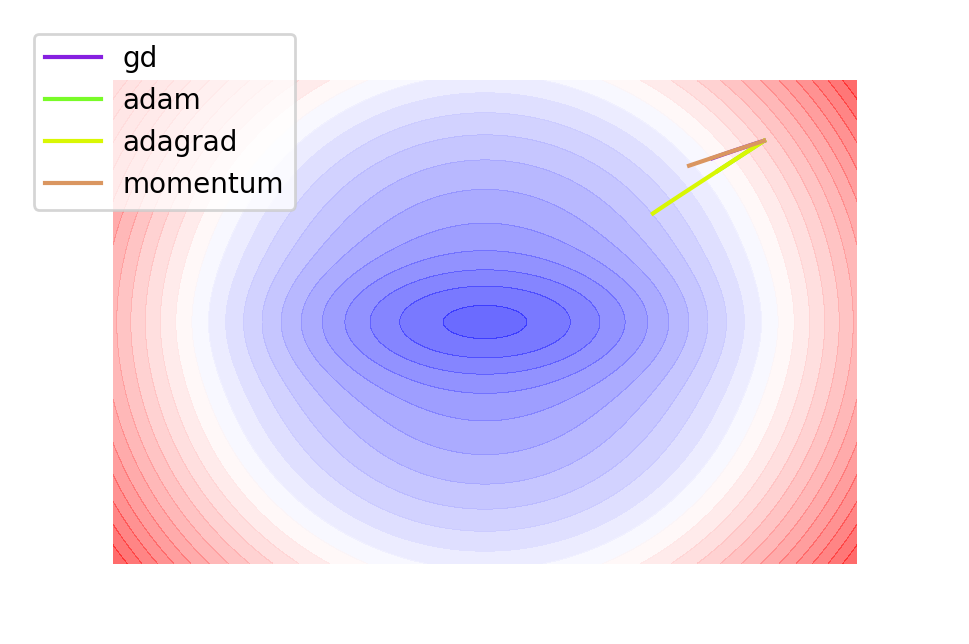

(256, 256)
(256, 256)
(256, 256)


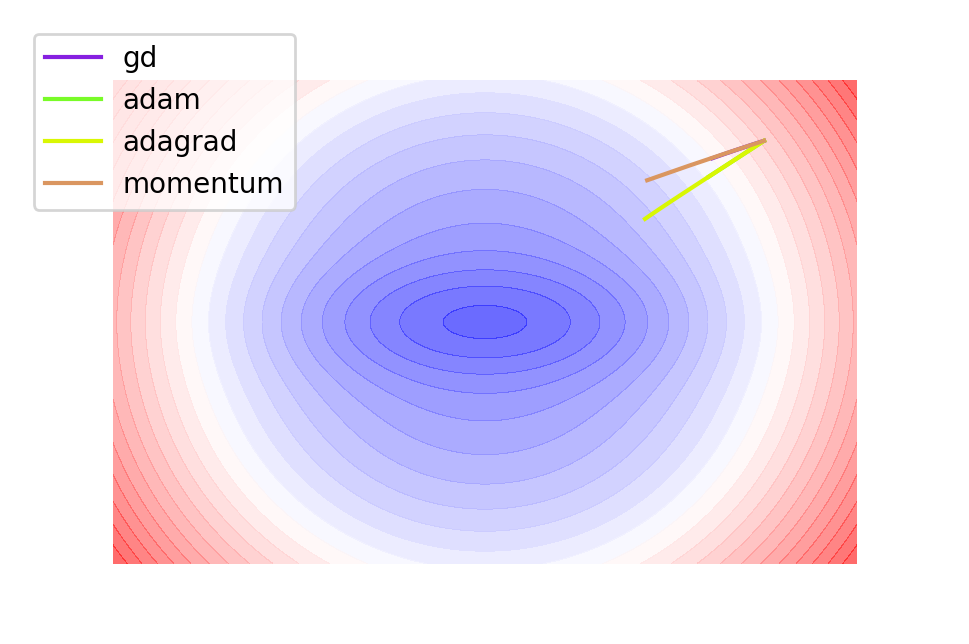

(256, 256)
(256, 256)
(256, 256)


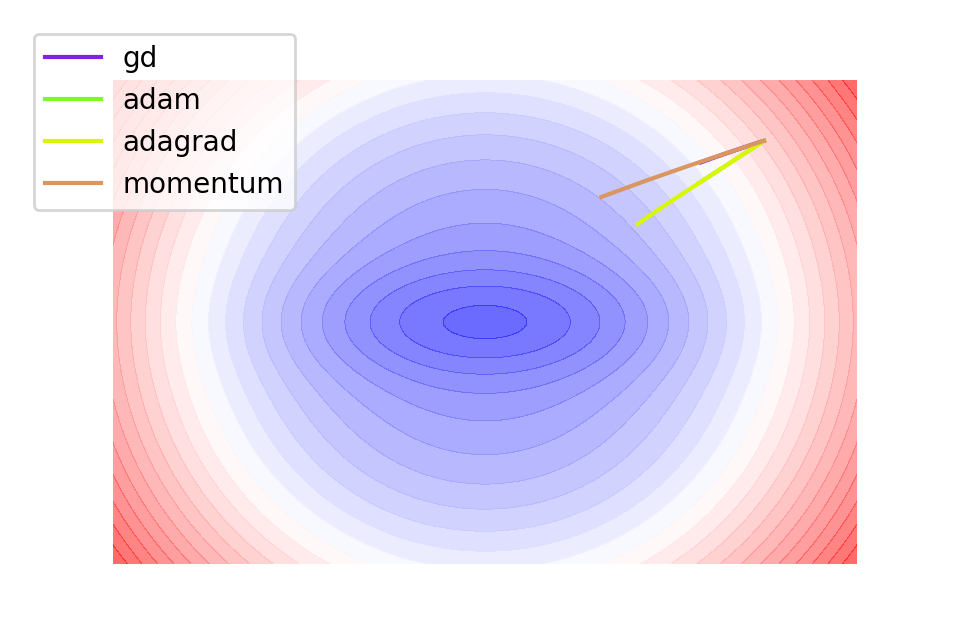

(256, 256)
(256, 256)
(256, 256)


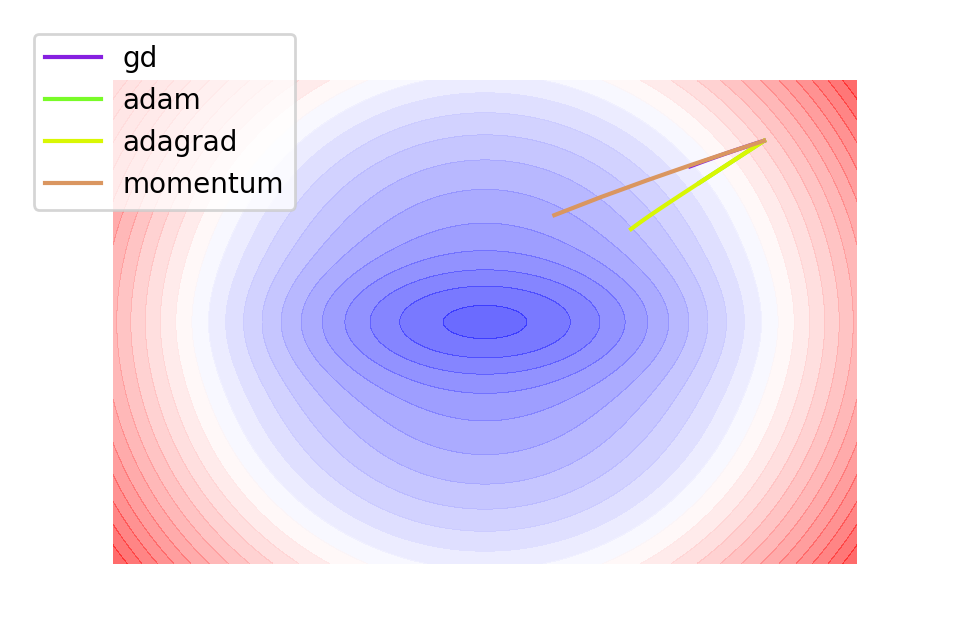

(256, 256)
(256, 256)
(256, 256)


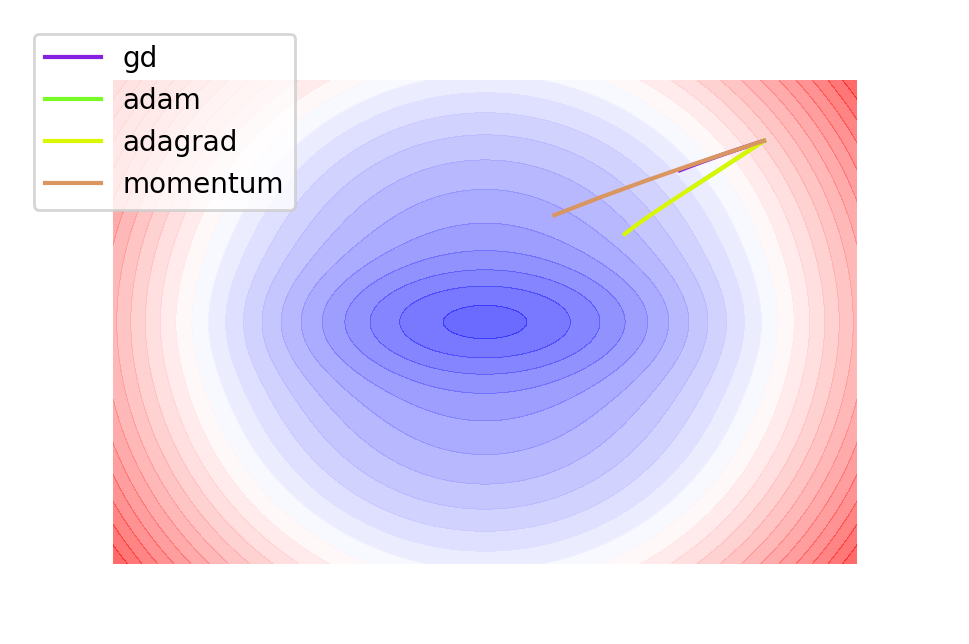

(256, 256)
(256, 256)
(256, 256)


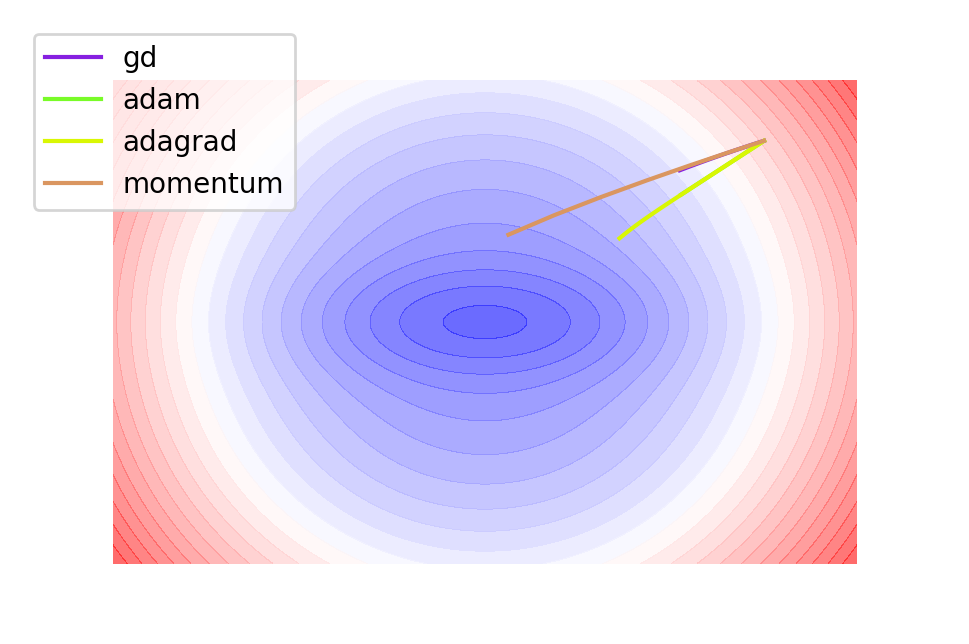

(256, 256)
(256, 256)
(256, 256)


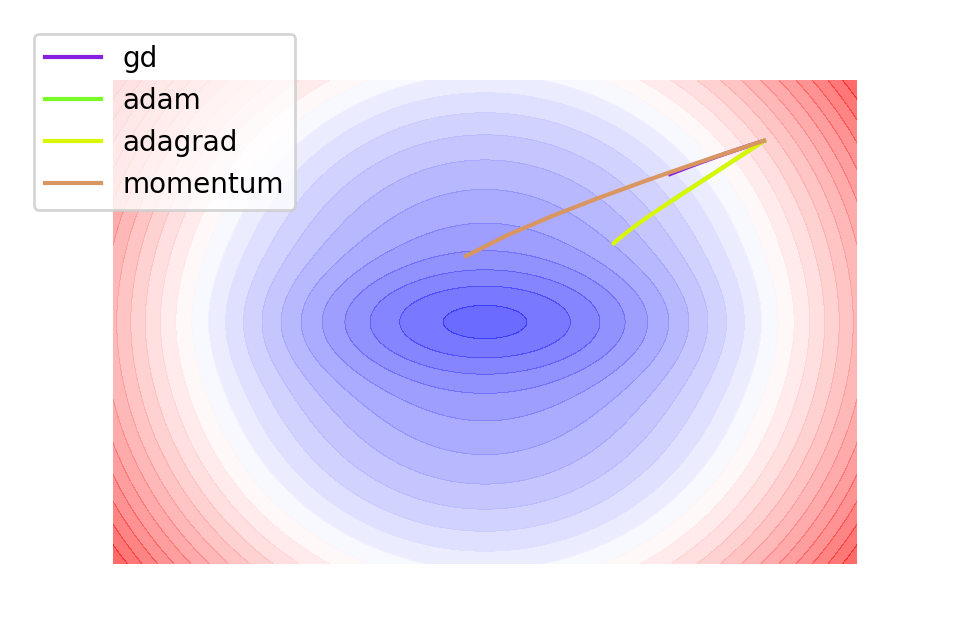

(256, 256)
(256, 256)
(256, 256)


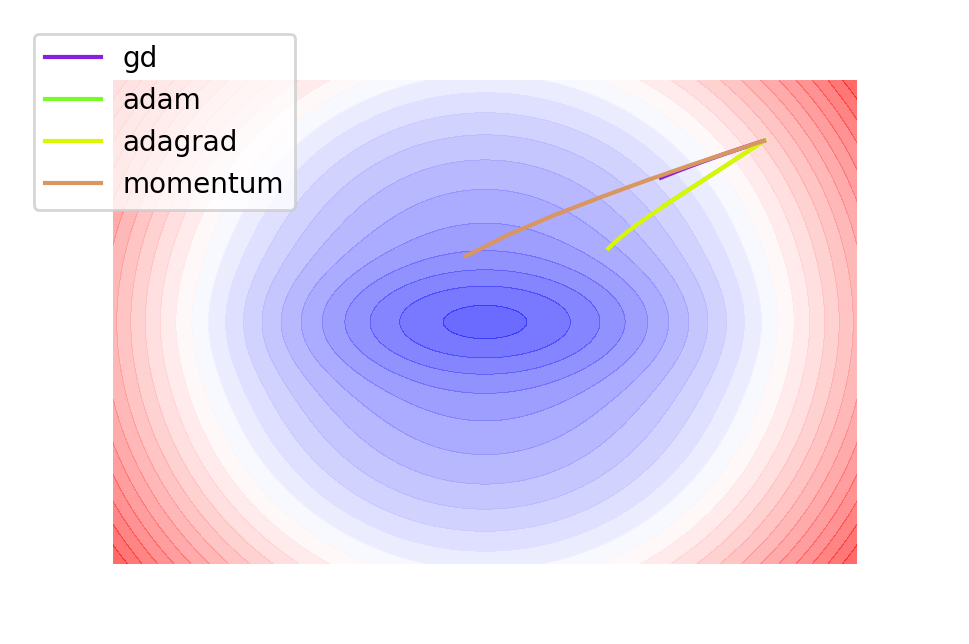

(256, 256)
(256, 256)
(256, 256)


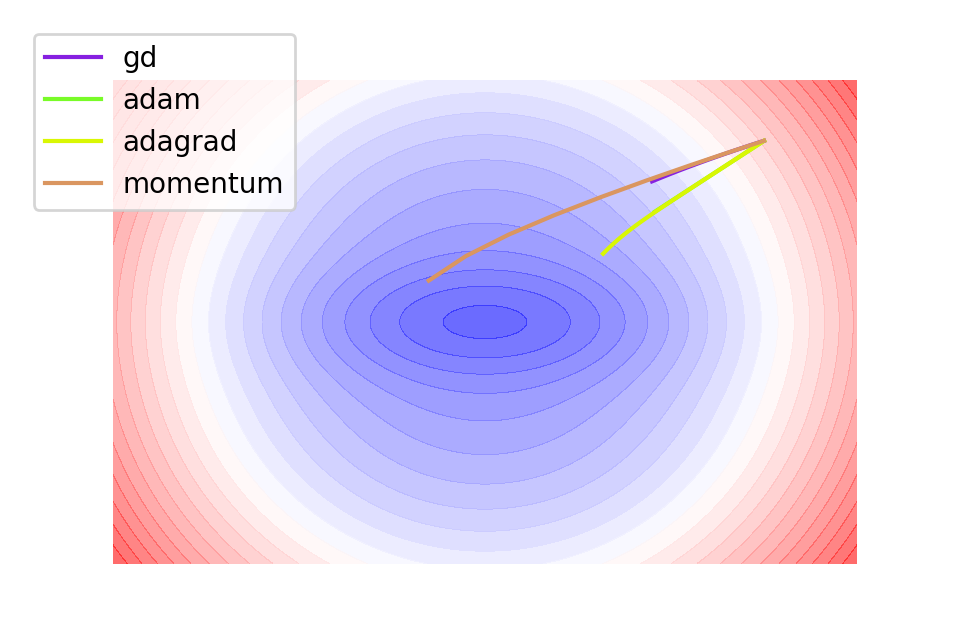

(256, 256)
(256, 256)
(256, 256)


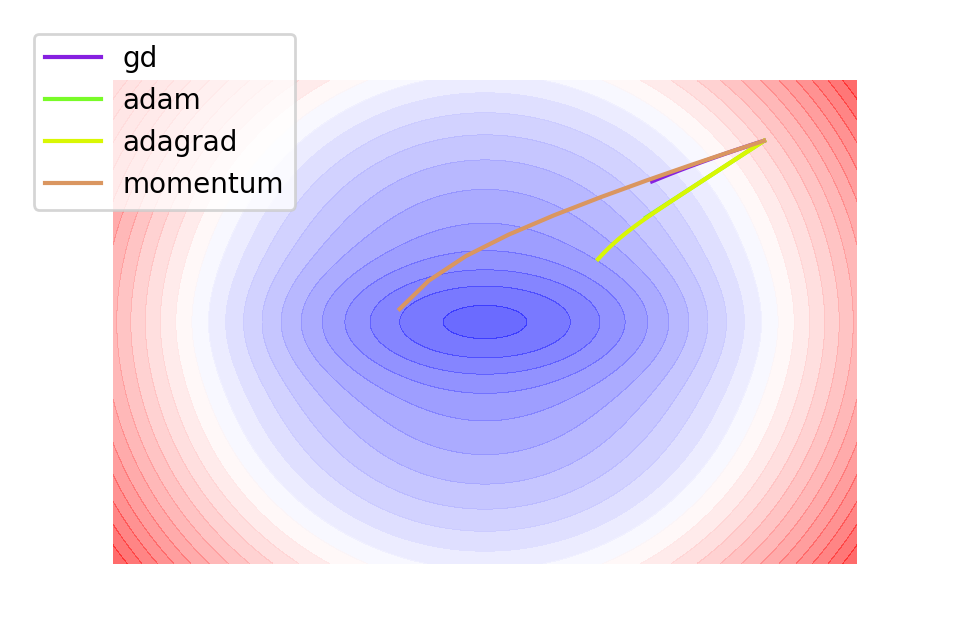

(256, 256)
(256, 256)
(256, 256)


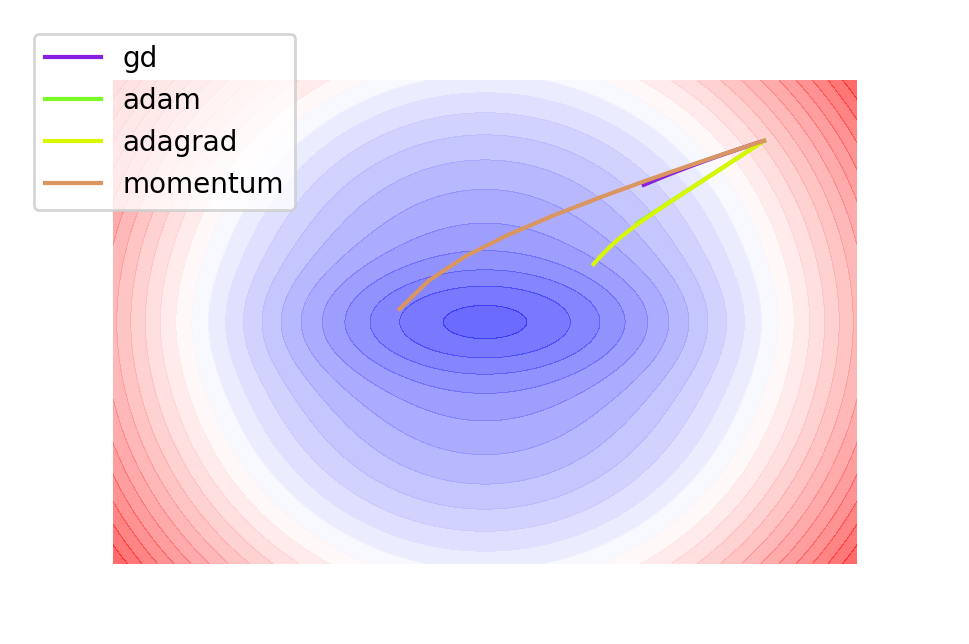

(256, 256)
(256, 256)
(256, 256)


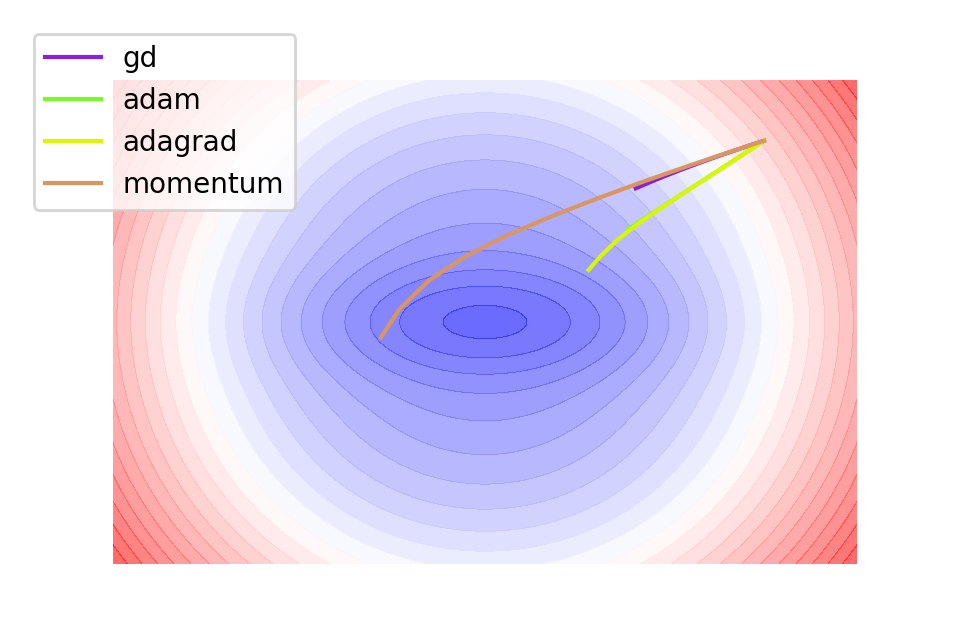

(256, 256)
(256, 256)
(256, 256)


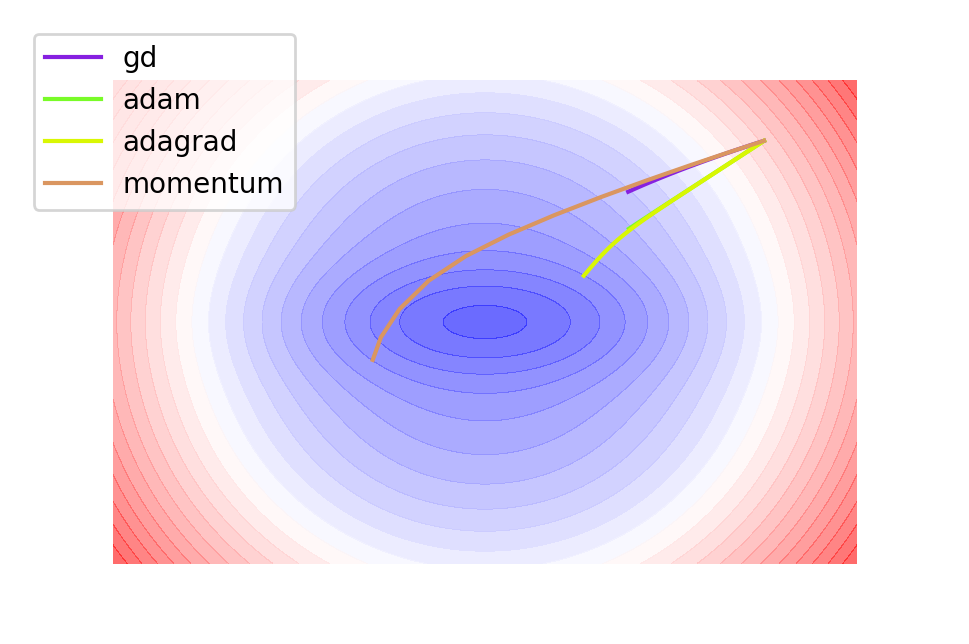

(256, 256)
(256, 256)
(256, 256)


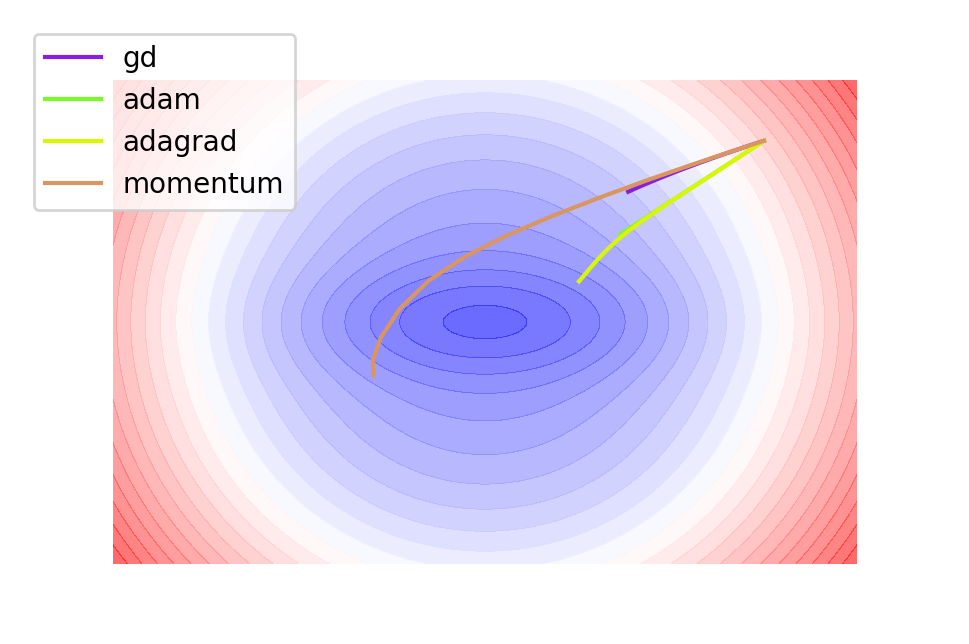

(256, 256)
(256, 256)
(256, 256)


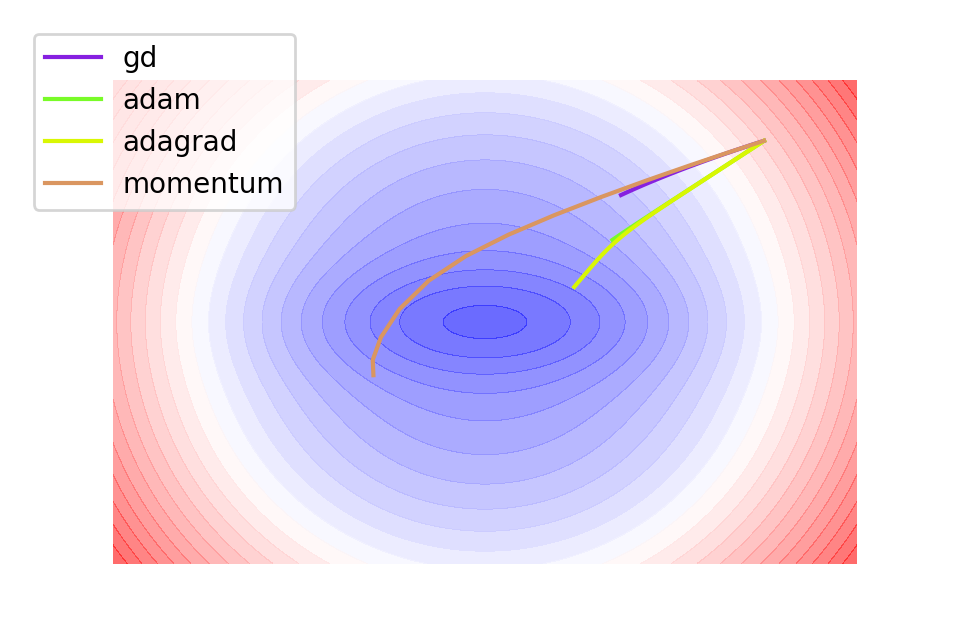

(256, 256)
(256, 256)
(256, 256)


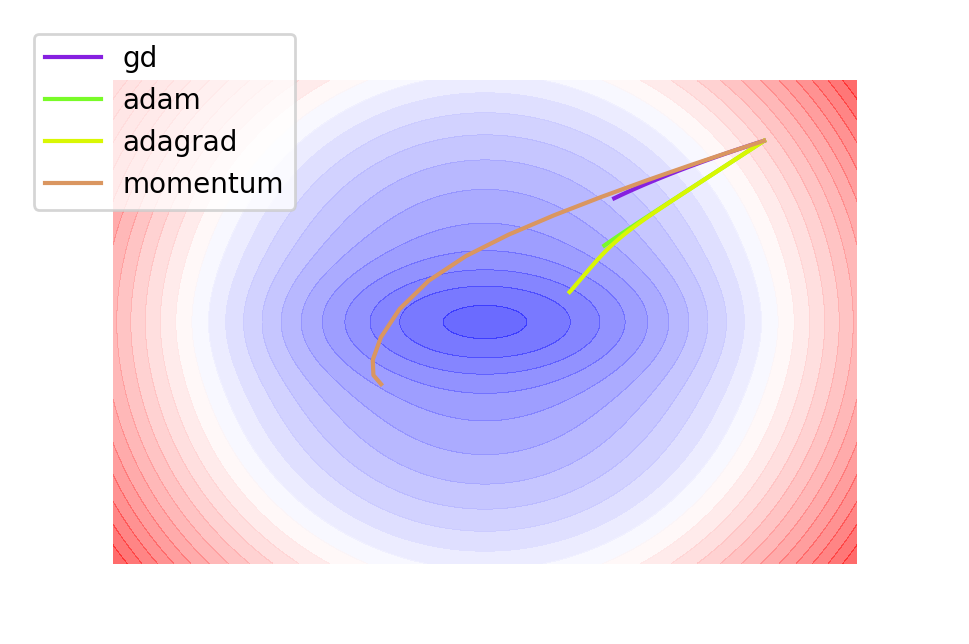

(256, 256)
(256, 256)
(256, 256)


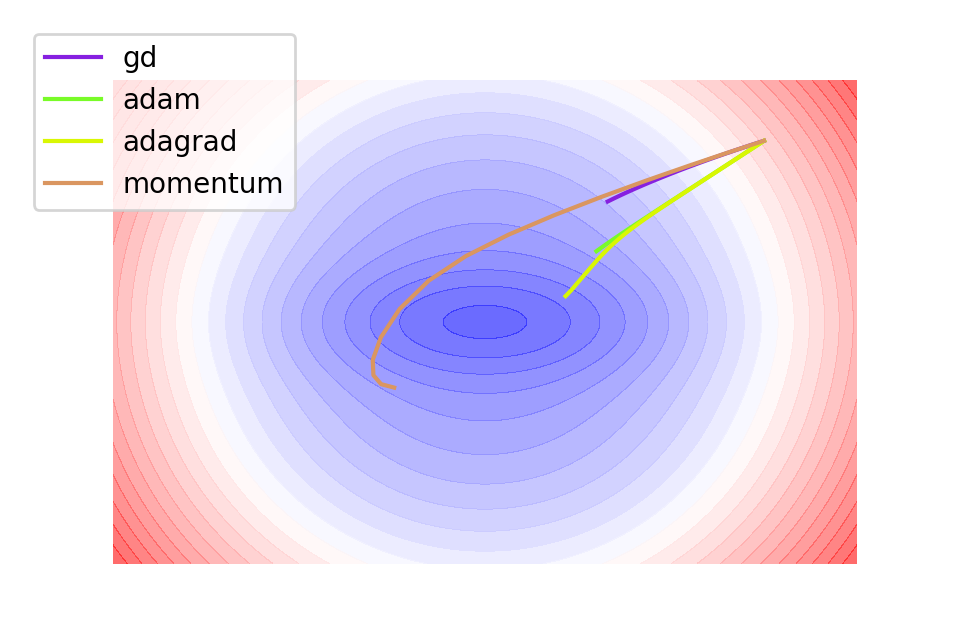

(256, 256)
(256, 256)
(256, 256)


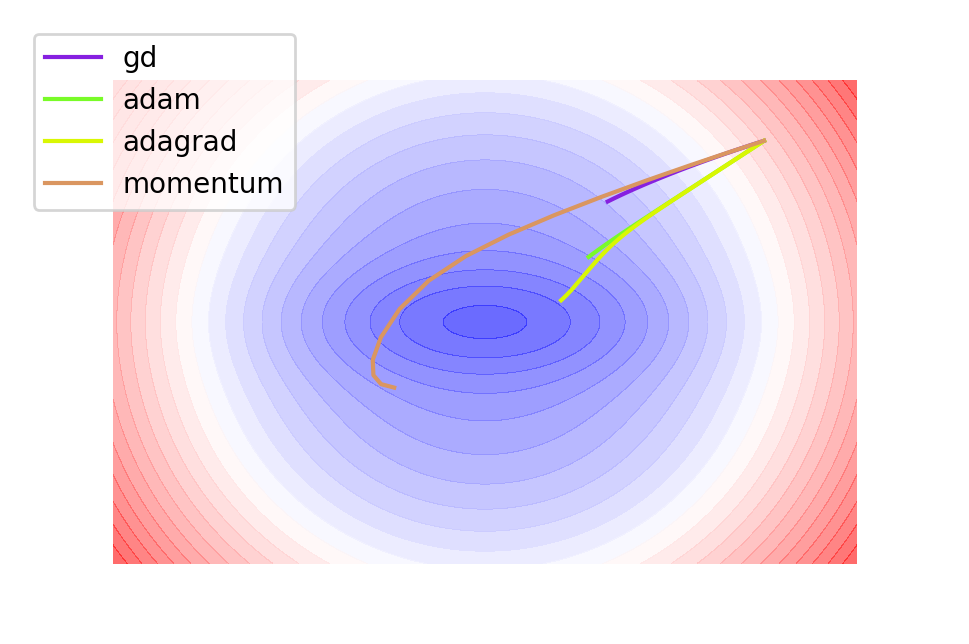

(256, 256)
(256, 256)
(256, 256)


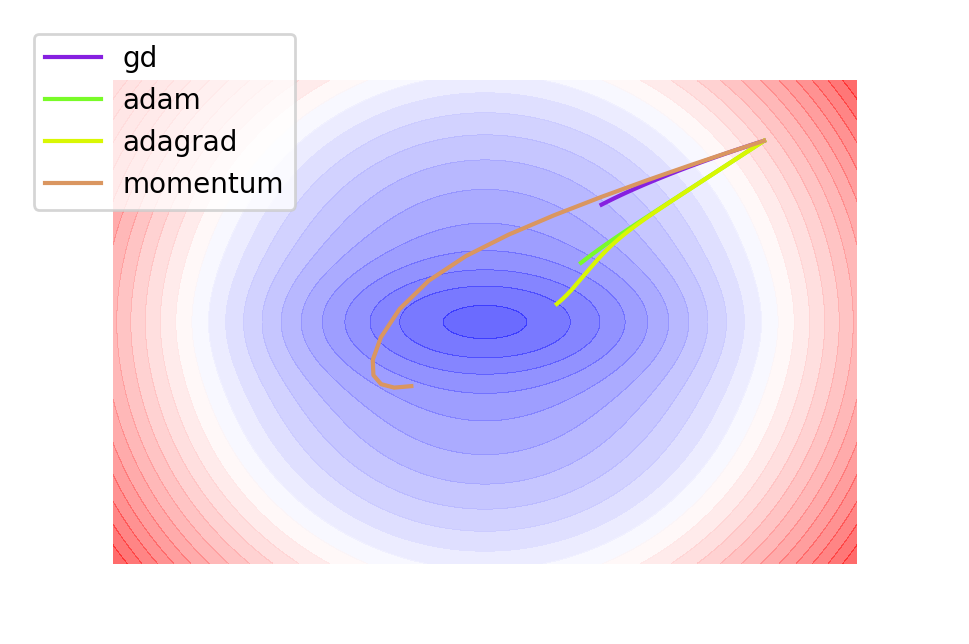

(256, 256)
(256, 256)
(256, 256)


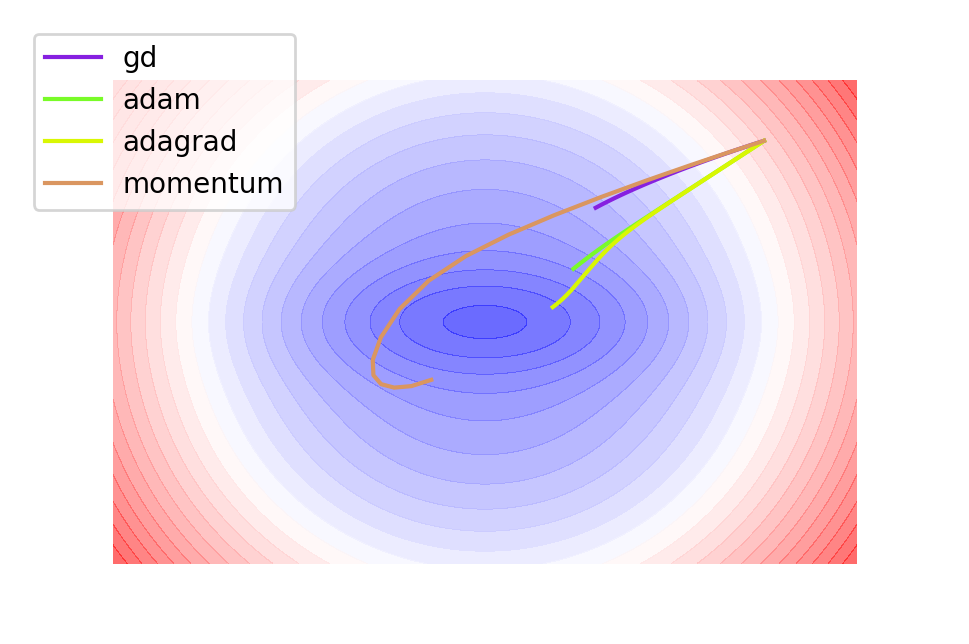

(256, 256)
(256, 256)
(256, 256)


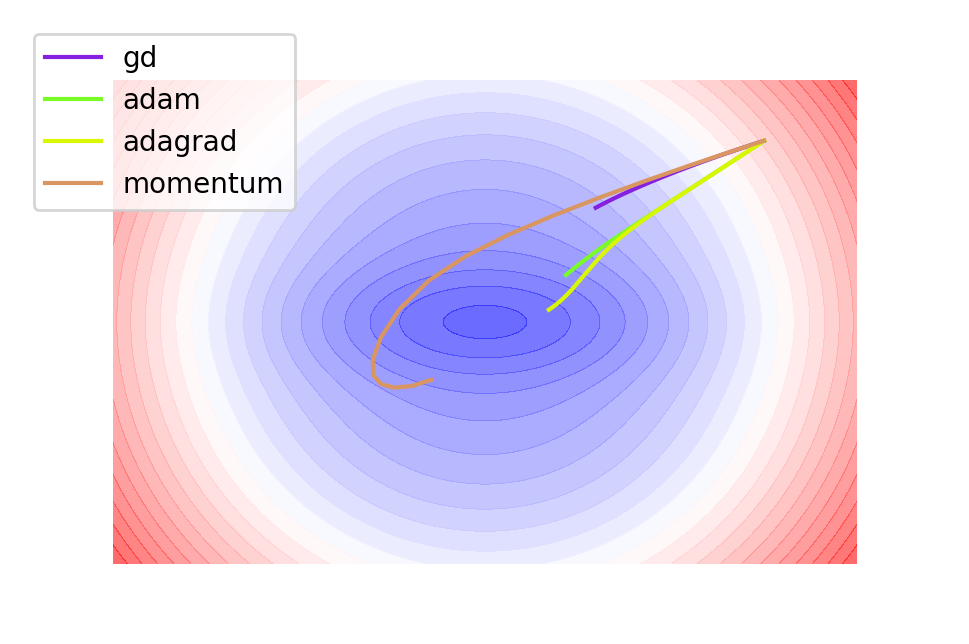

(256, 256)
(256, 256)
(256, 256)


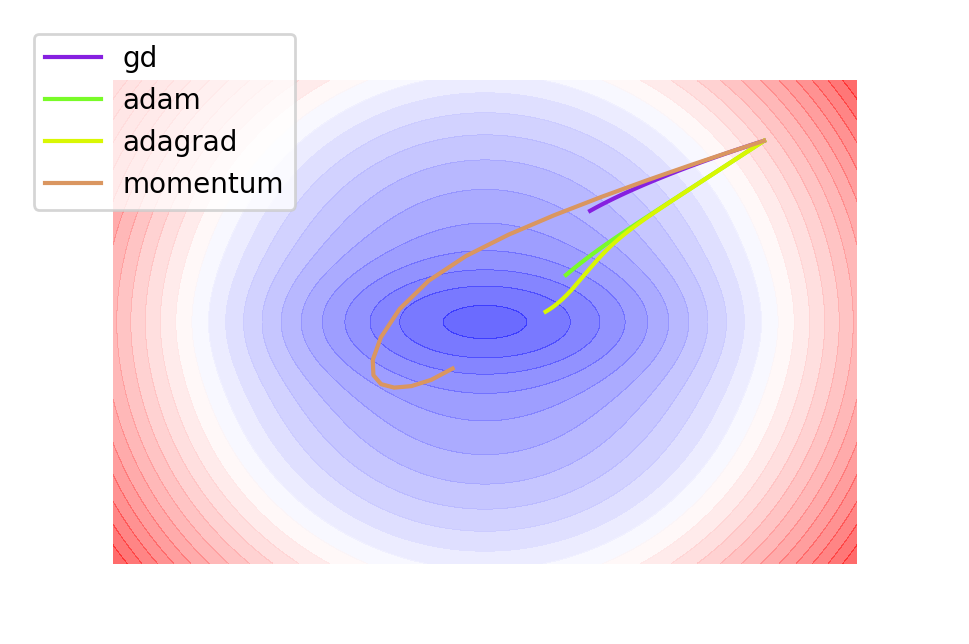

(256, 256)
(256, 256)
(256, 256)


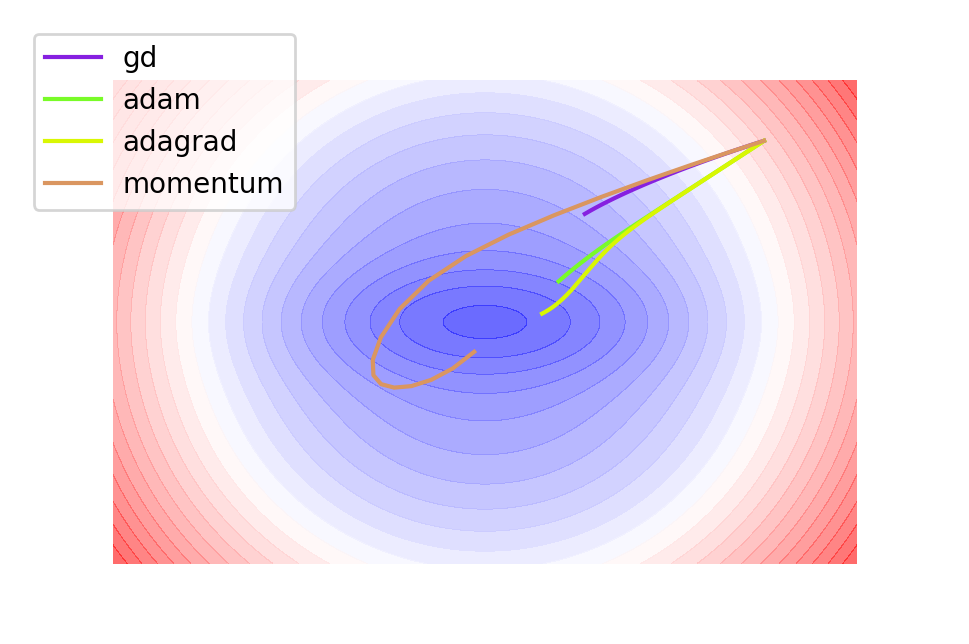

(256, 256)
(256, 256)
(256, 256)


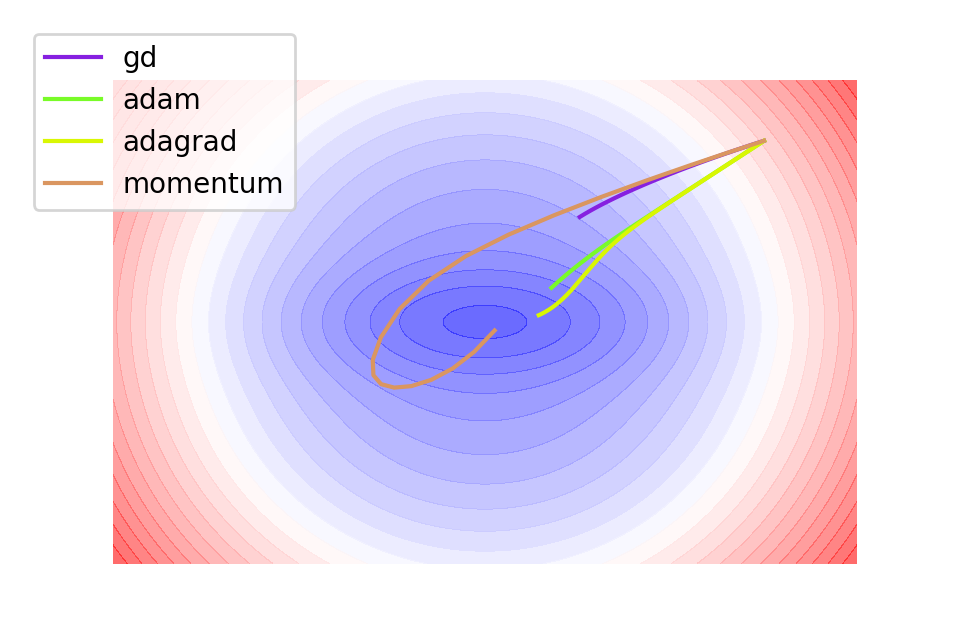

(256, 256)
(256, 256)
(256, 256)


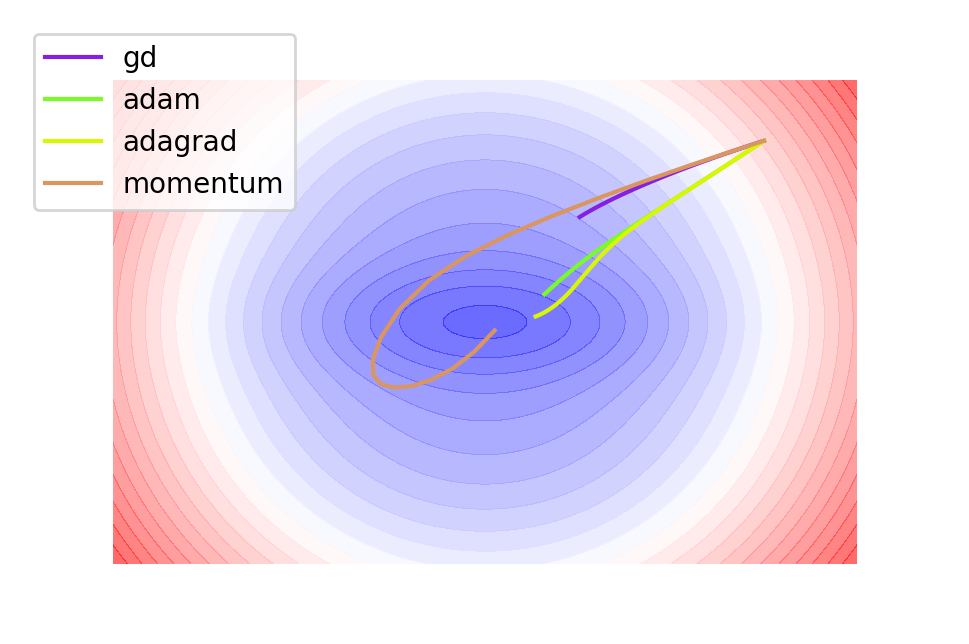

(256, 256)
(256, 256)
(256, 256)


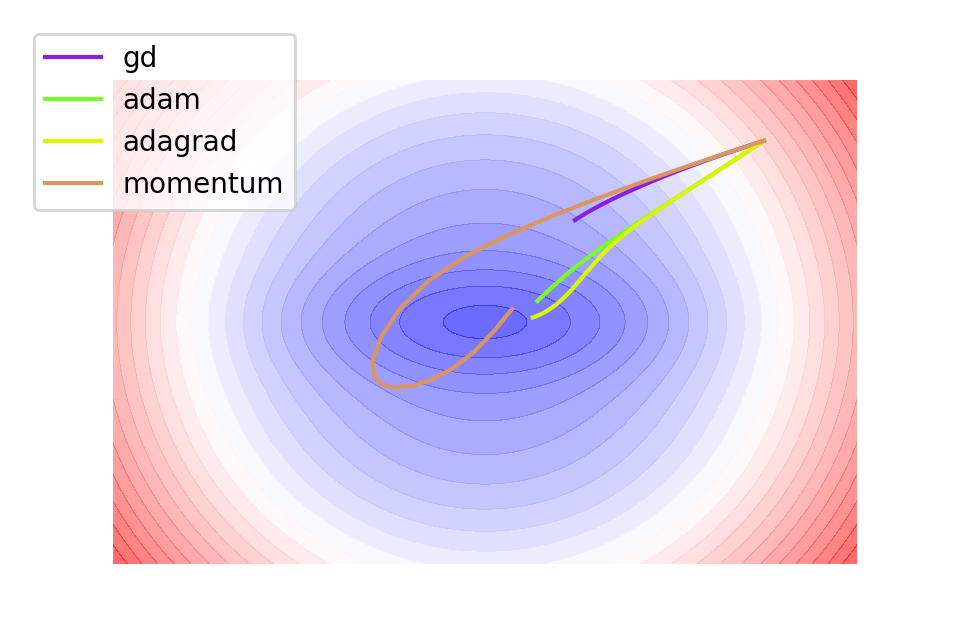

(256, 256)
(256, 256)
(256, 256)


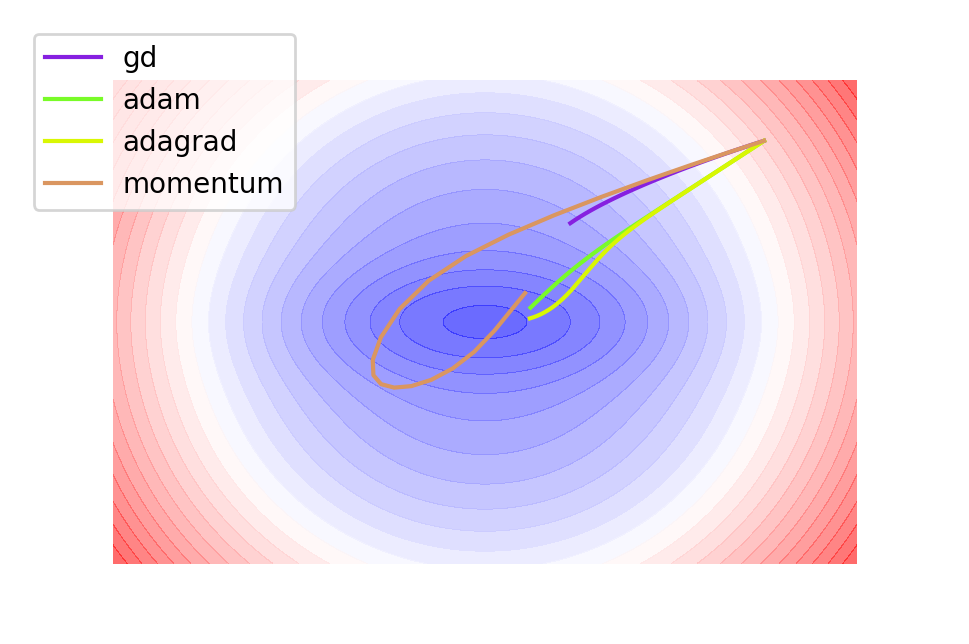

(256, 256)
(256, 256)
(256, 256)


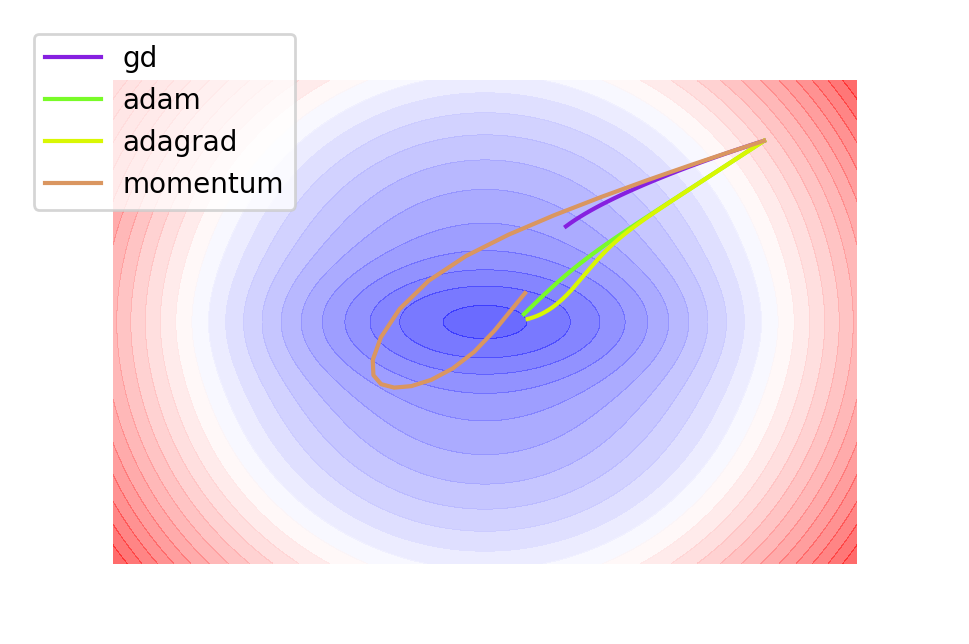

(256, 256)
(256, 256)
(256, 256)


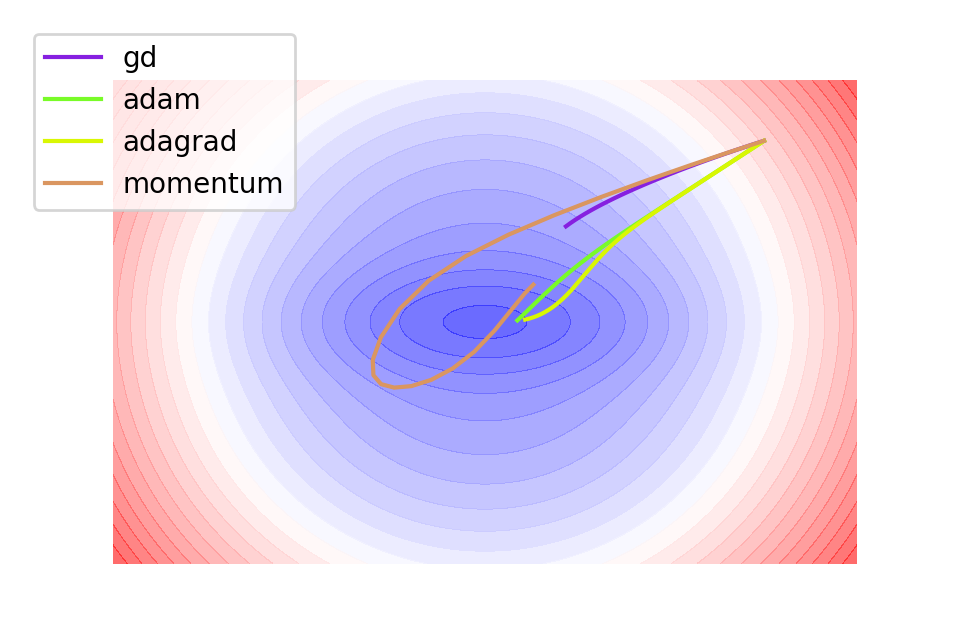

(256, 256)
(256, 256)
(256, 256)


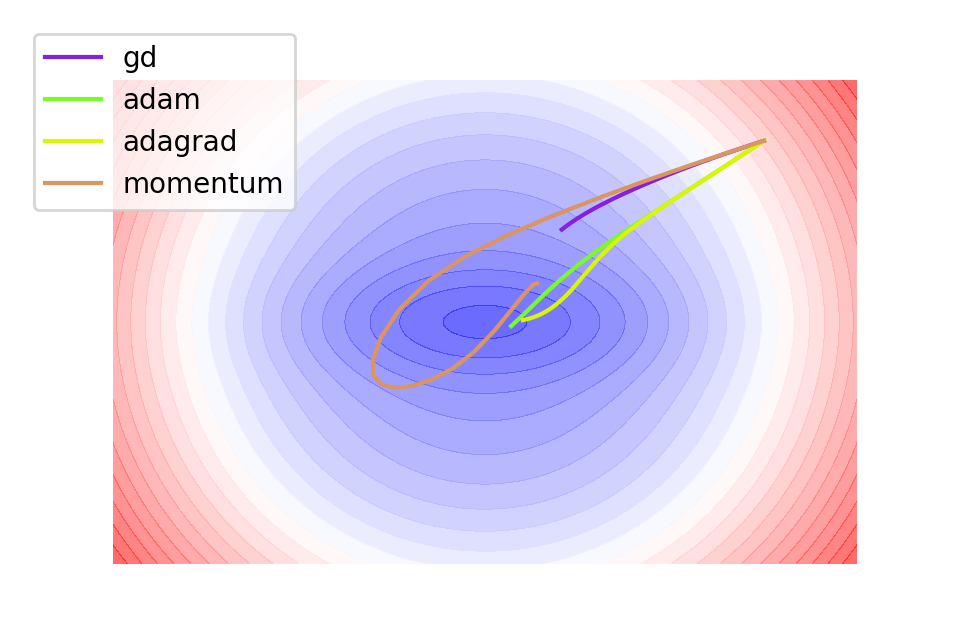

(256, 256)
(256, 256)
(256, 256)


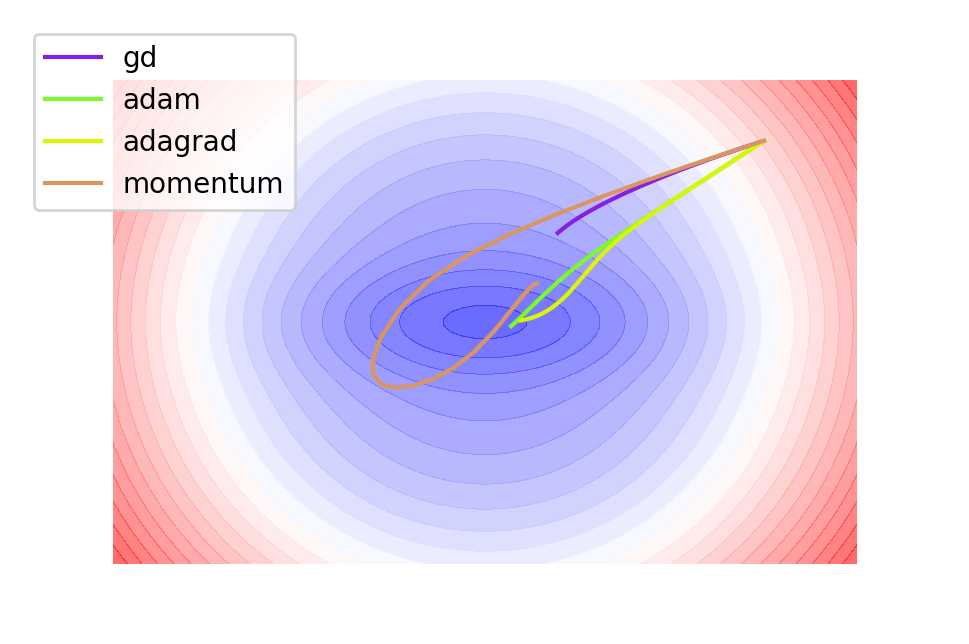

(256, 256)
(256, 256)
(256, 256)


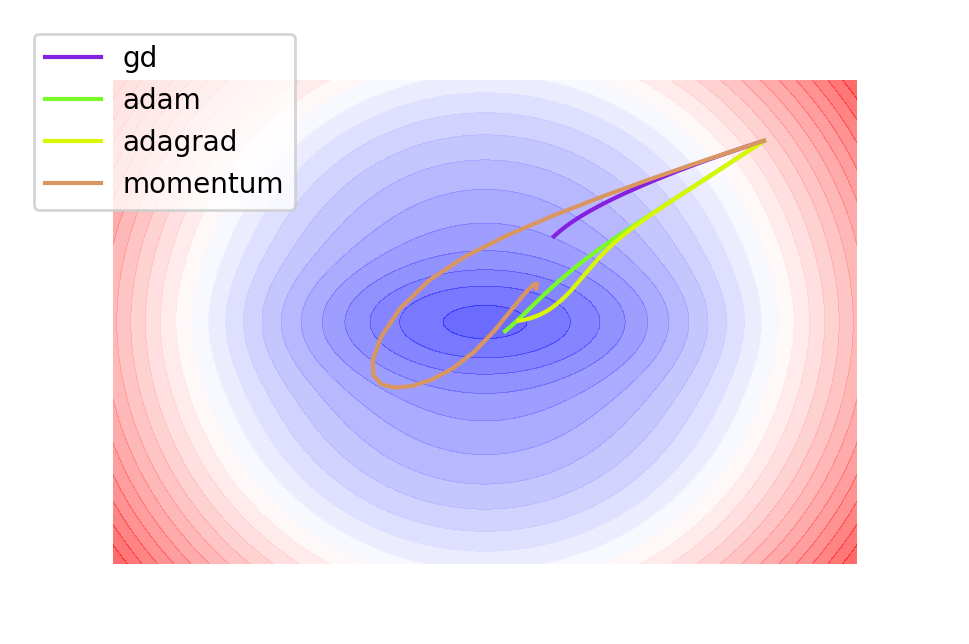

(256, 256)
(256, 256)
(256, 256)


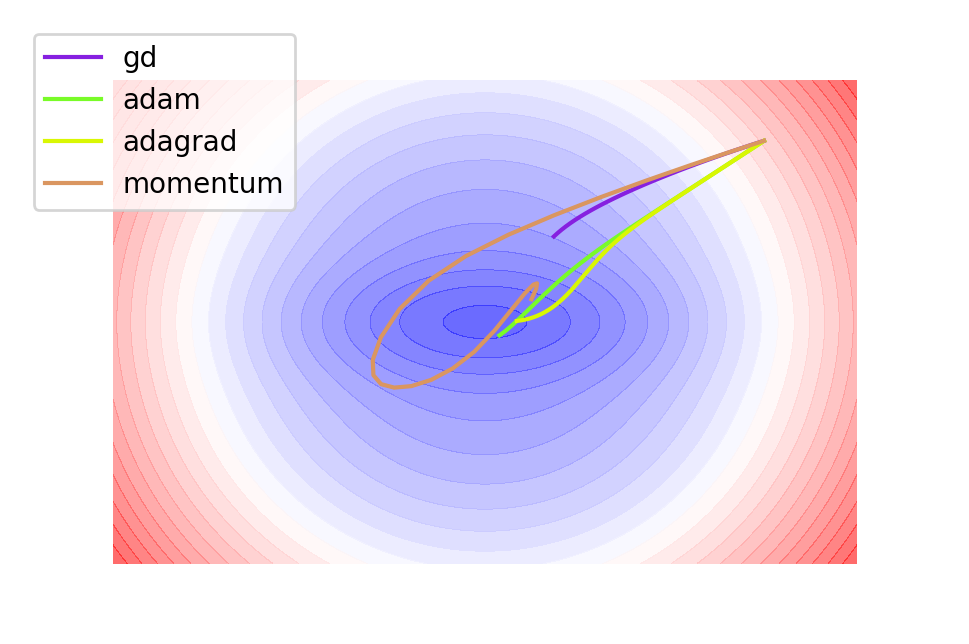

(256, 256)
(256, 256)
(256, 256)


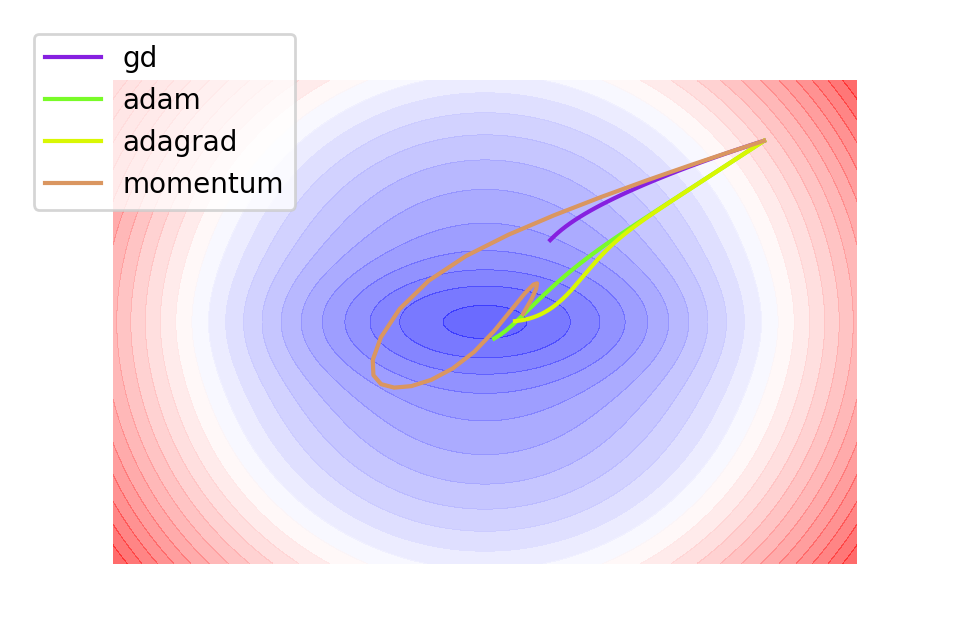

(256, 256)
(256, 256)
(256, 256)


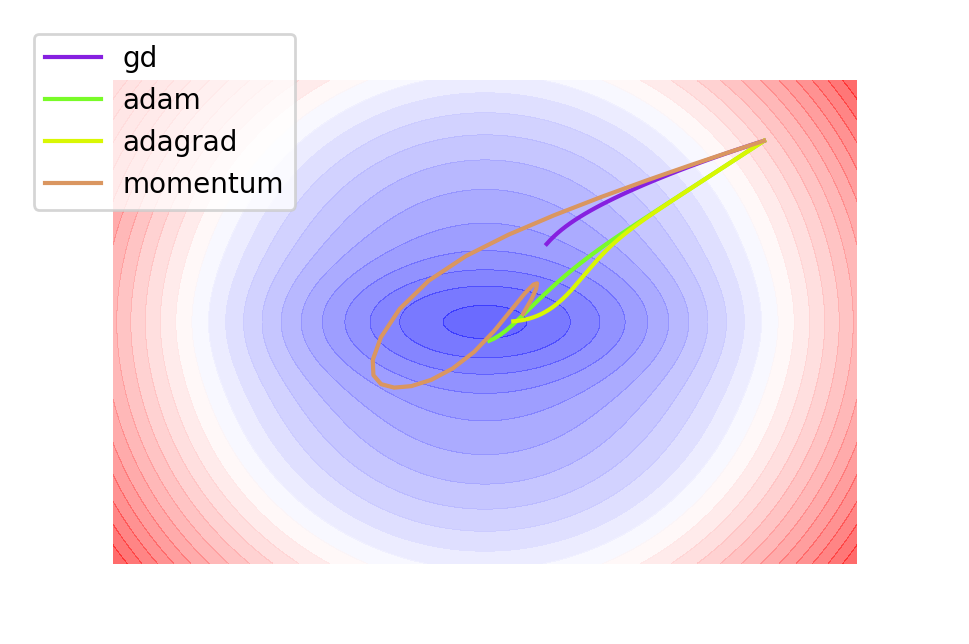

(256, 256)
(256, 256)
(256, 256)


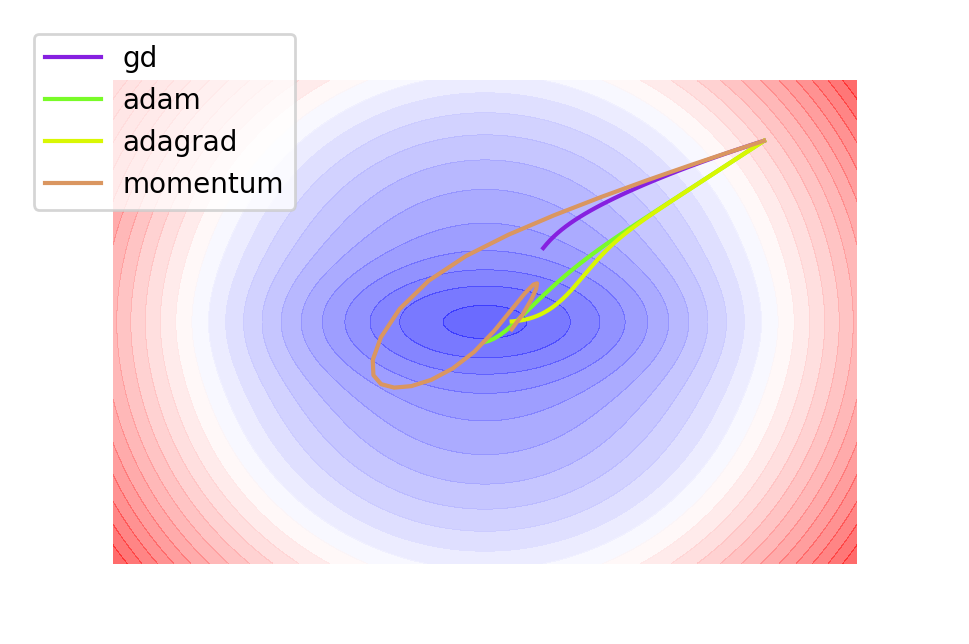

(256, 256)
(256, 256)
(256, 256)


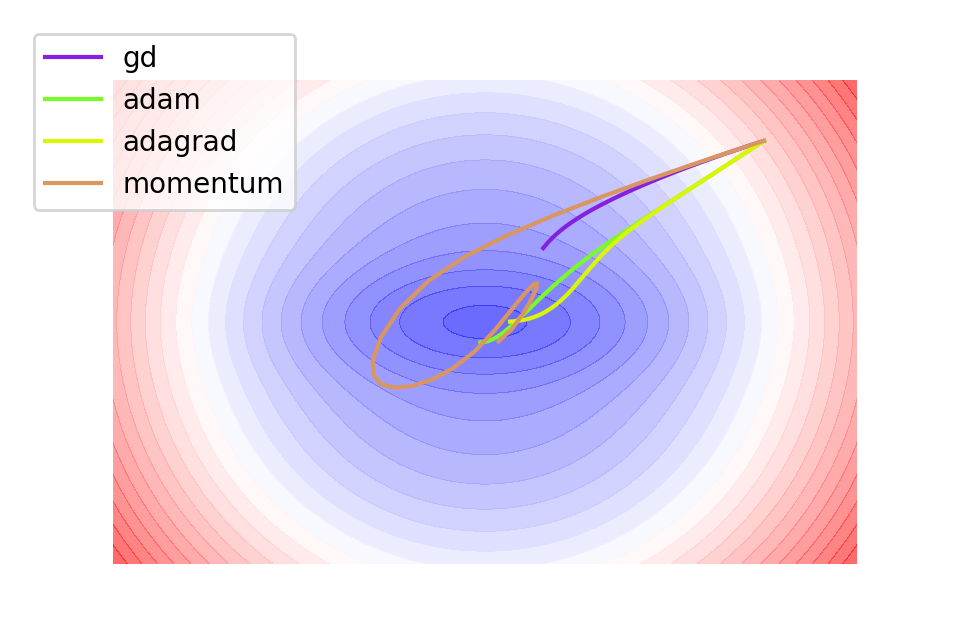

(256, 256)
(256, 256)
(256, 256)


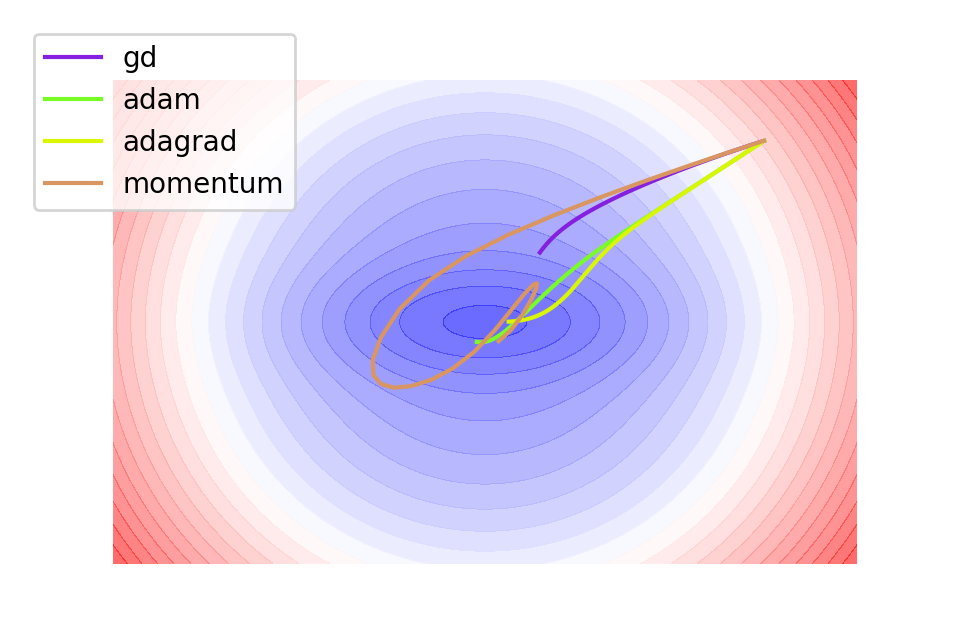

(256, 256)
(256, 256)
(256, 256)


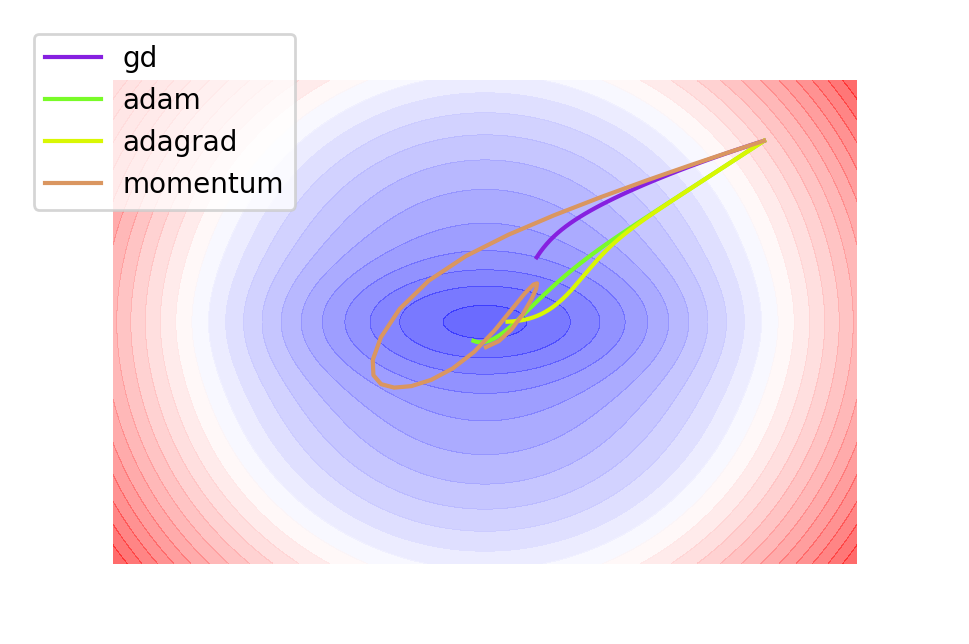

(256, 256)
(256, 256)
(256, 256)


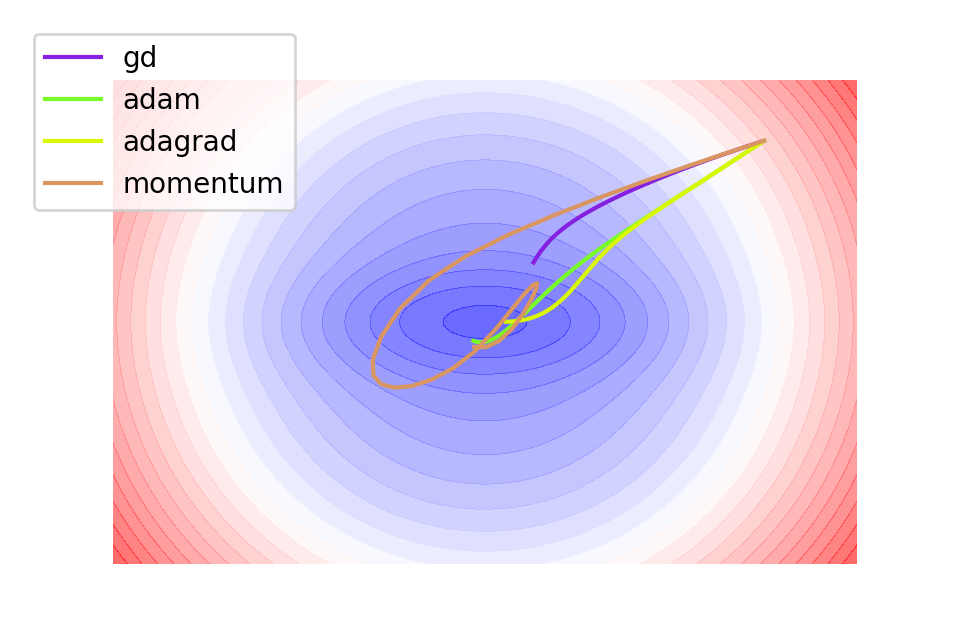

(256, 256)
(256, 256)
(256, 256)


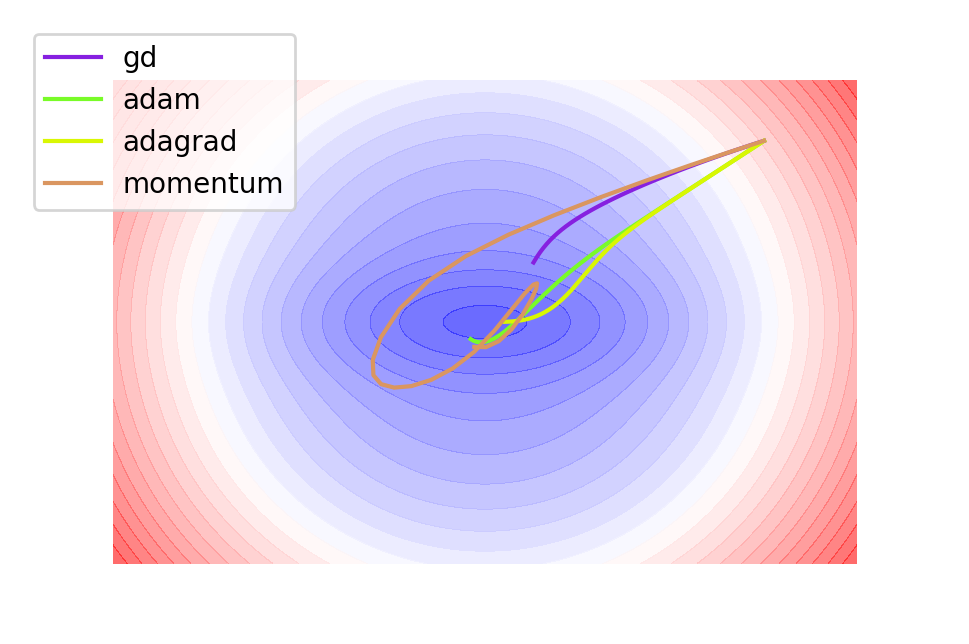

(256, 256)
(256, 256)
(256, 256)


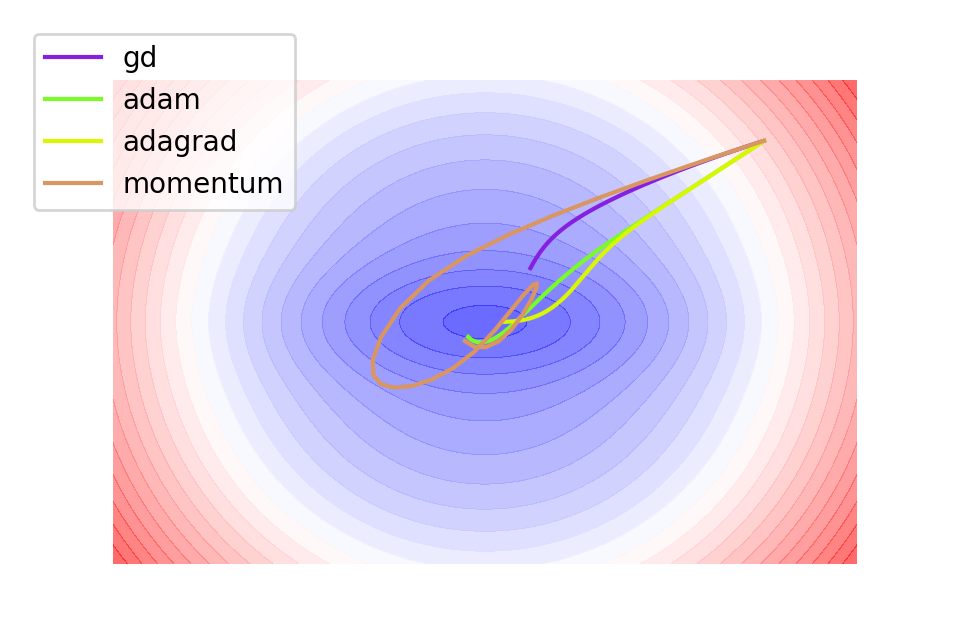

(256, 256)
(256, 256)
(256, 256)


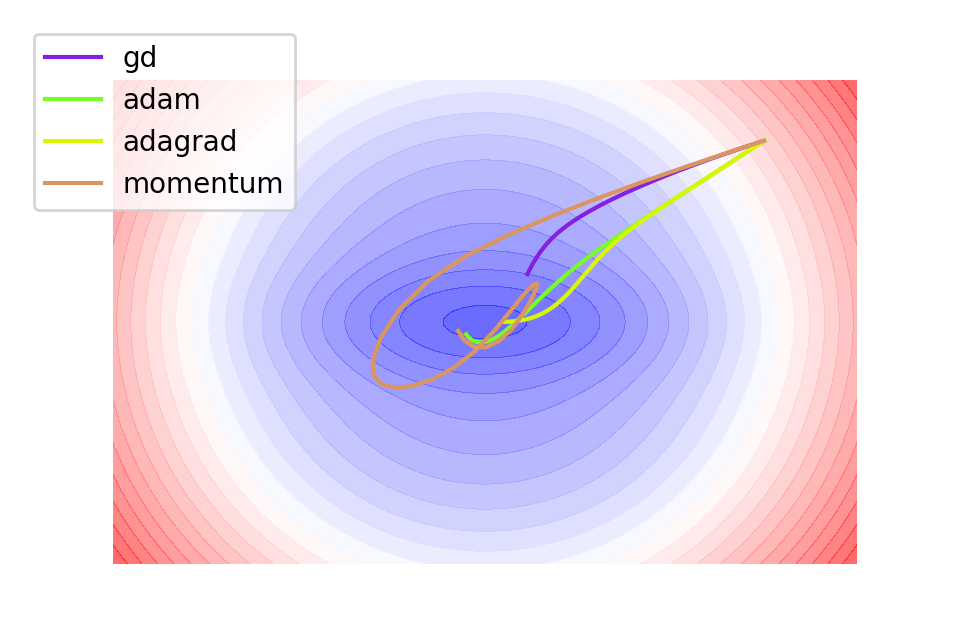

(256, 256)
(256, 256)
(256, 256)


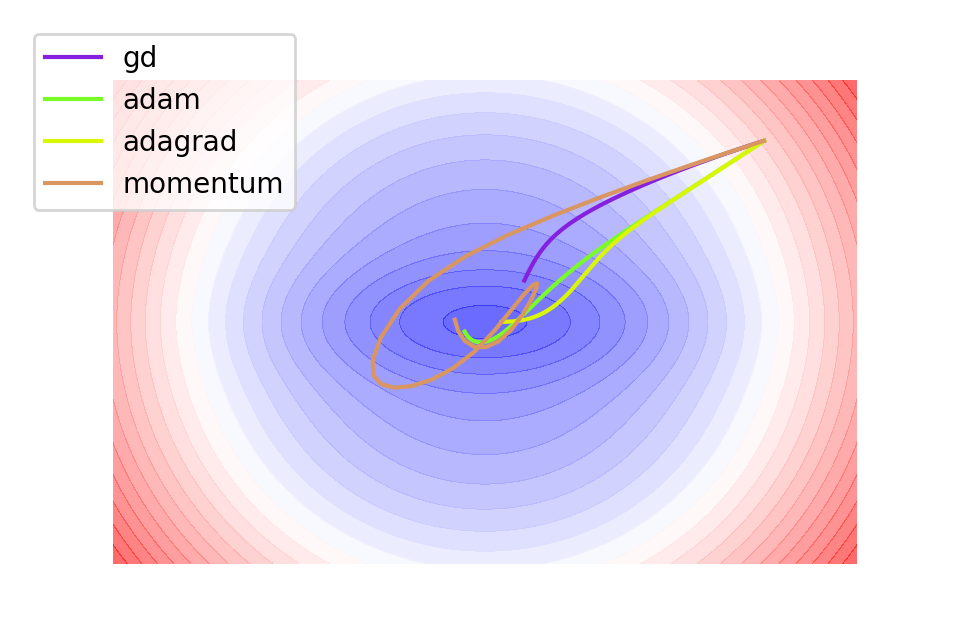

(256, 256)
(256, 256)
(256, 256)


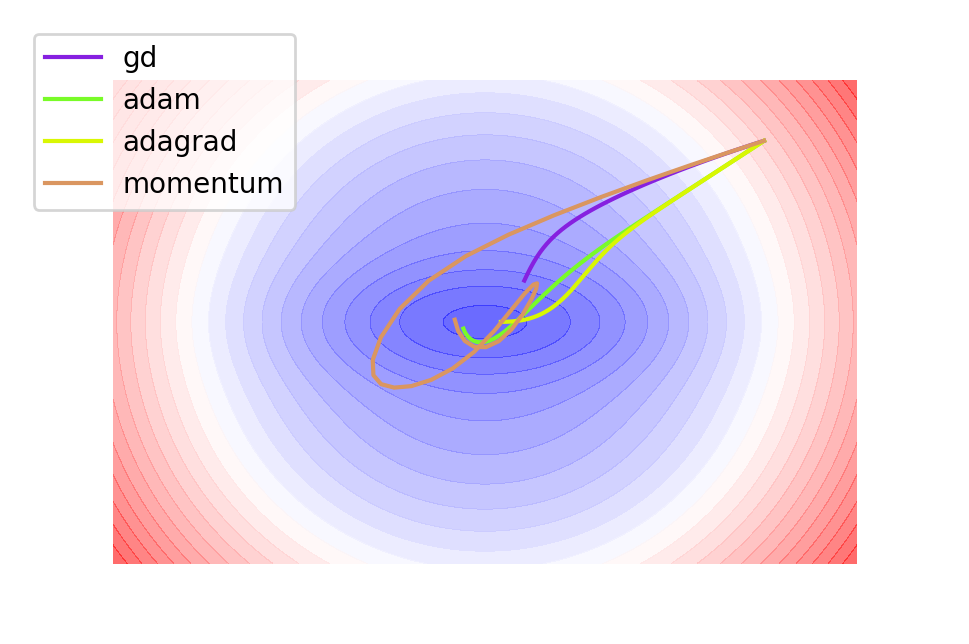

(256, 256)
(256, 256)
(256, 256)


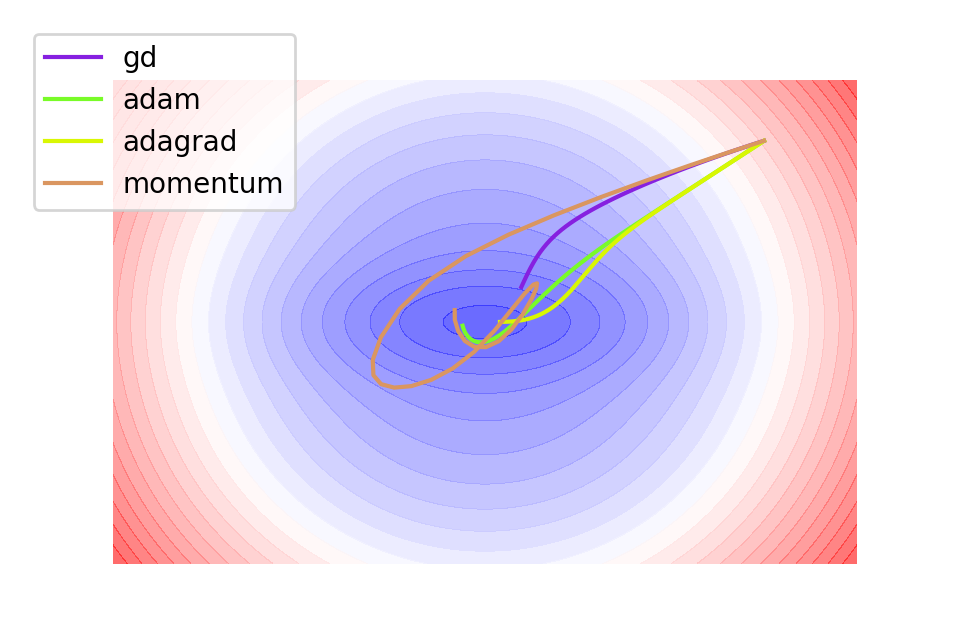

(256, 256)
(256, 256)
(256, 256)


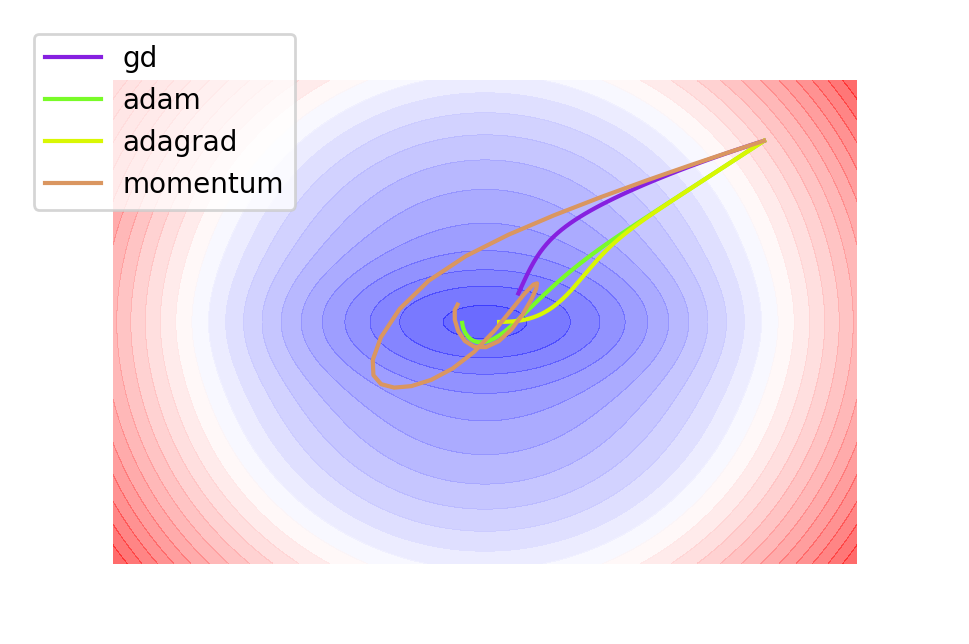

(256, 256)
(256, 256)
(256, 256)


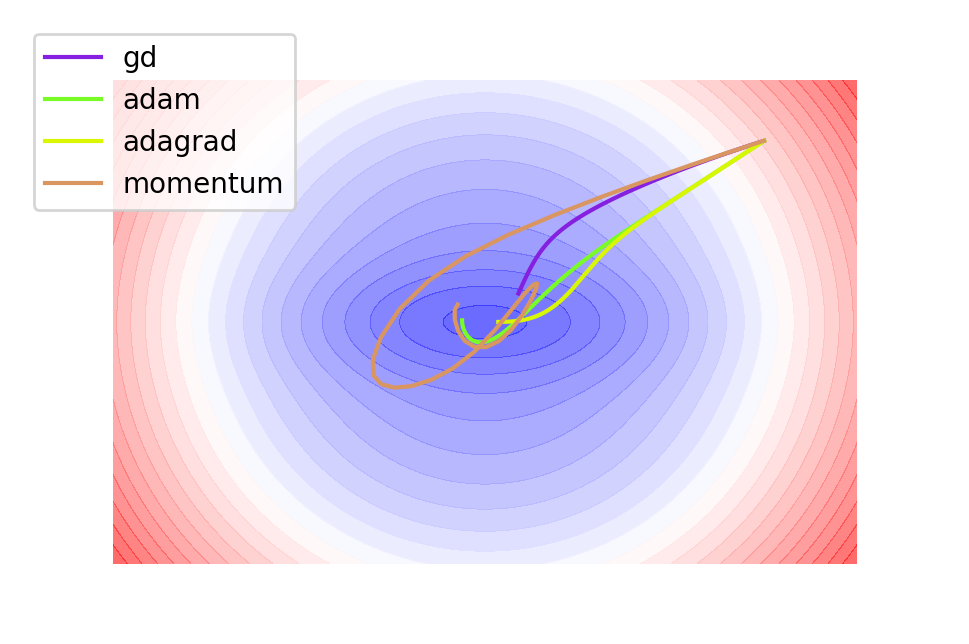

(256, 256)
(256, 256)
(256, 256)


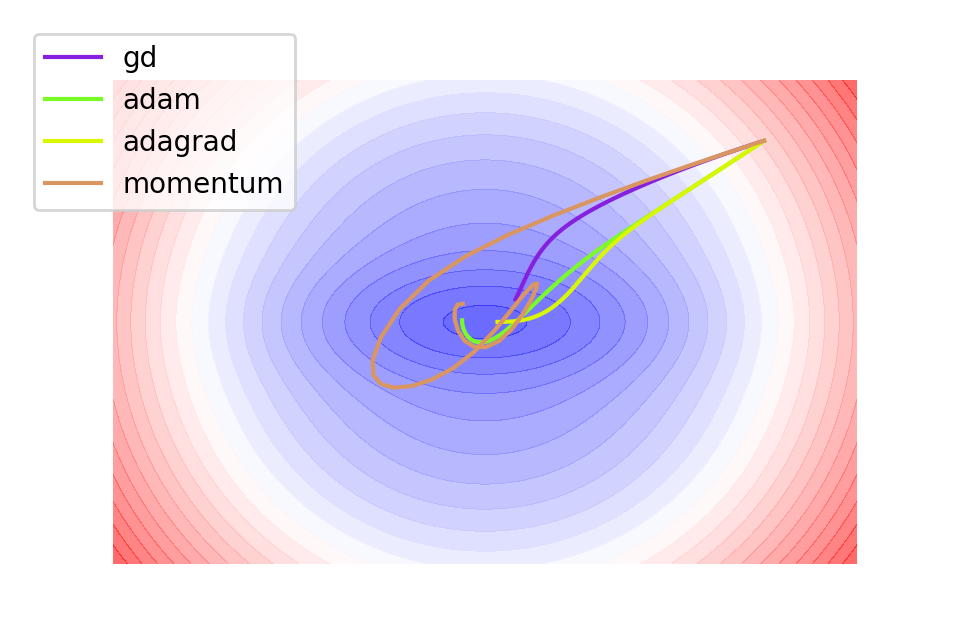

(256, 256)
(256, 256)
(256, 256)


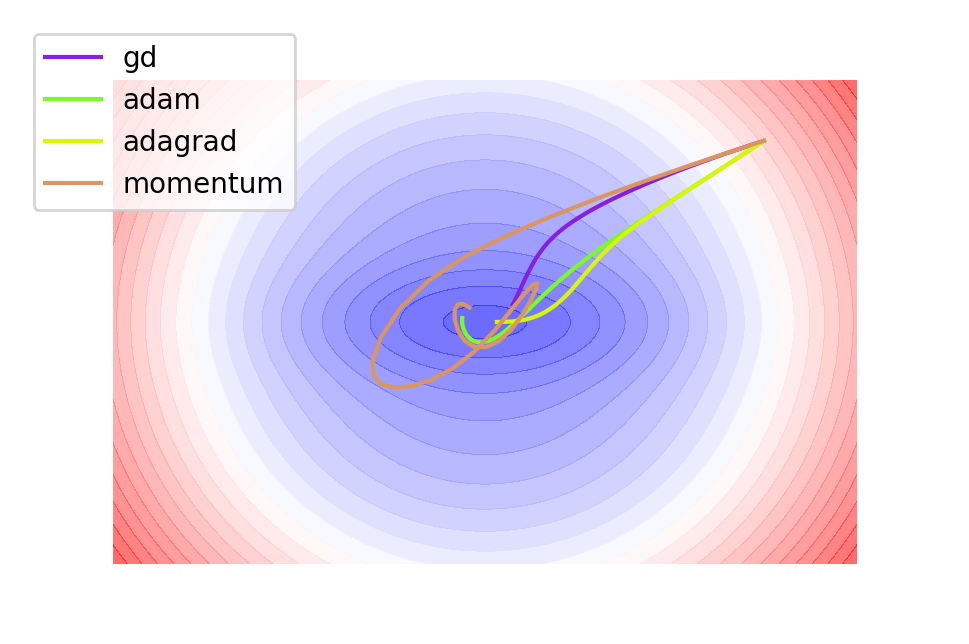

(256, 256)
(256, 256)
(256, 256)


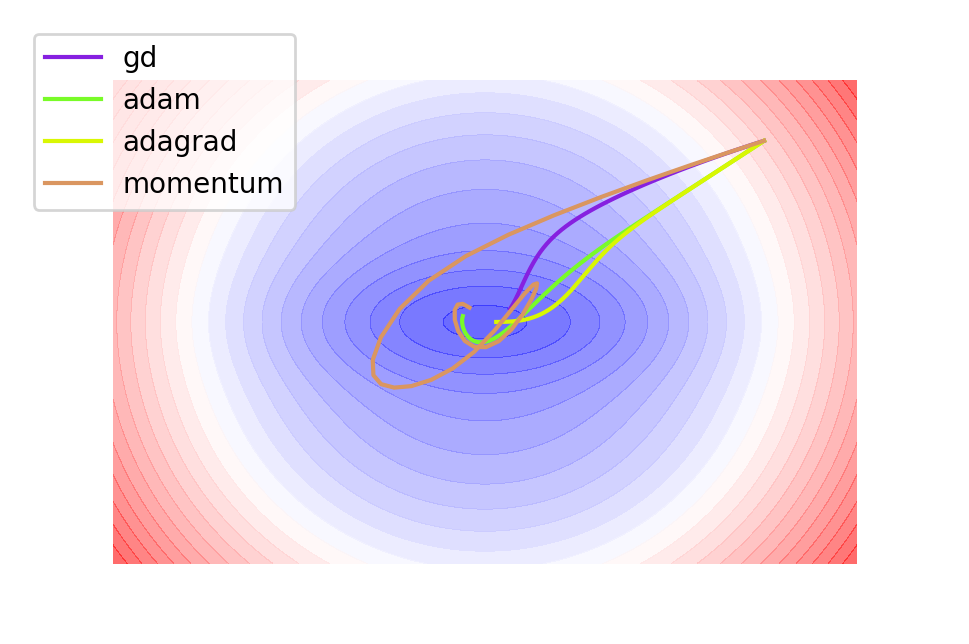

(256, 256)
(256, 256)
(256, 256)


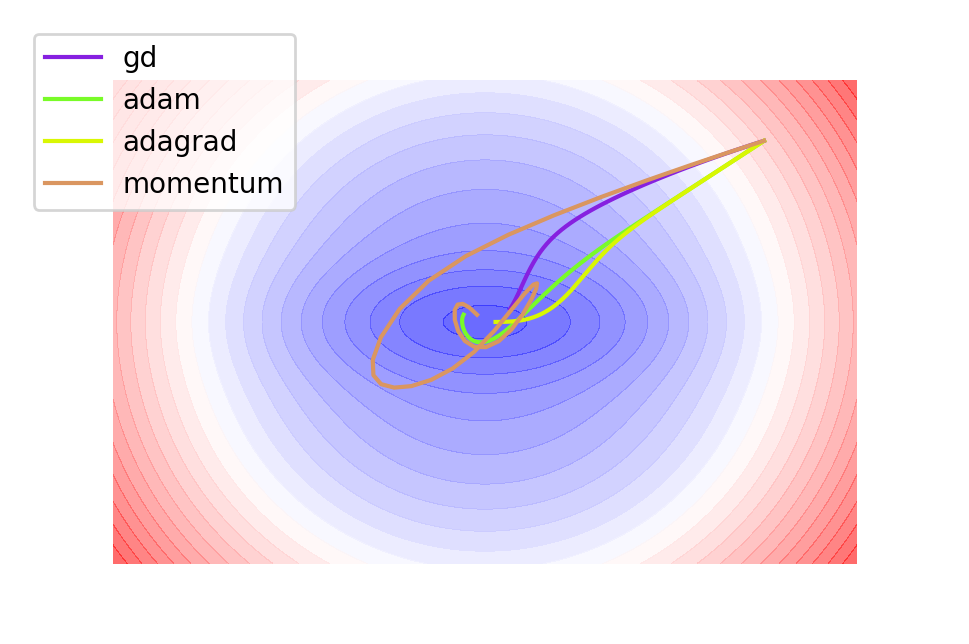

(256, 256)
(256, 256)
(256, 256)


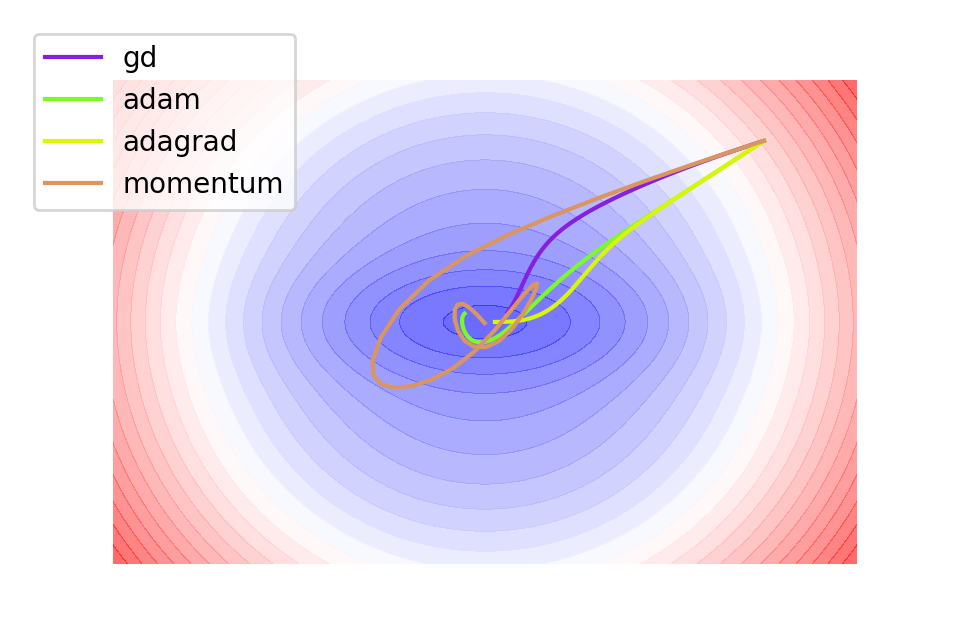

(256, 256)
(256, 256)
(256, 256)


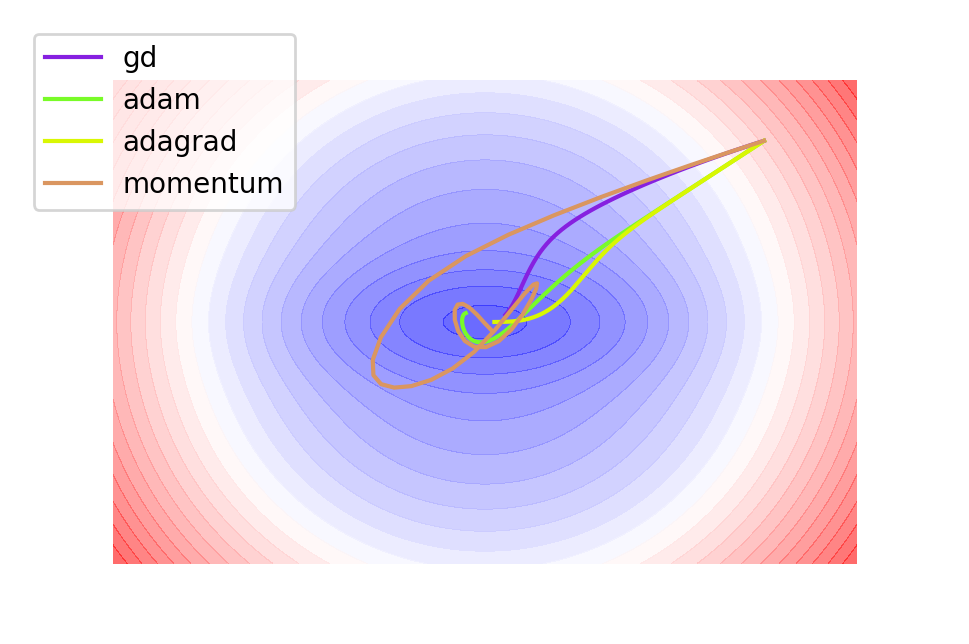

(256, 256)
(256, 256)
(256, 256)


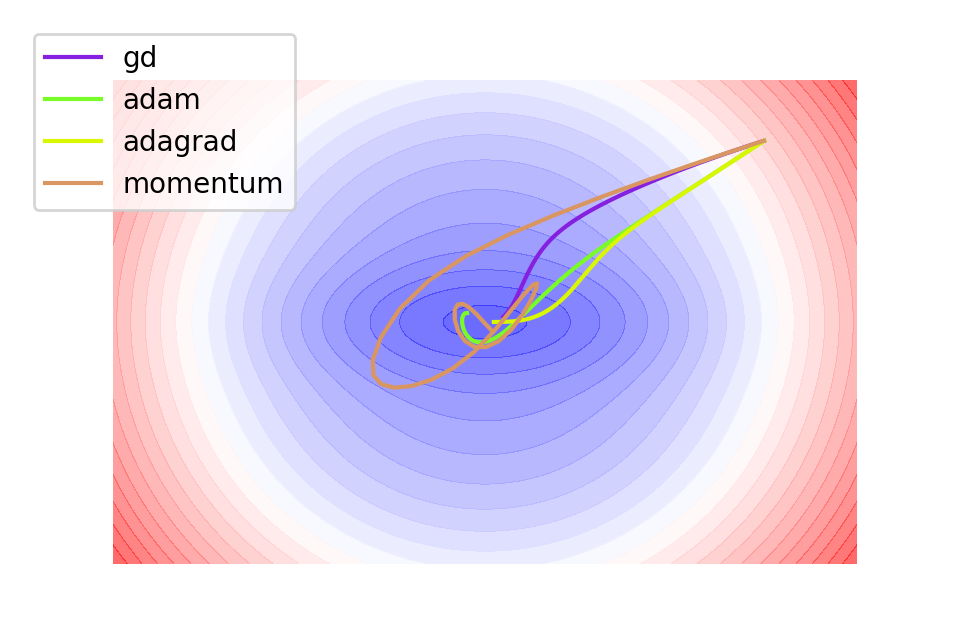

(256, 256)
(256, 256)
(256, 256)


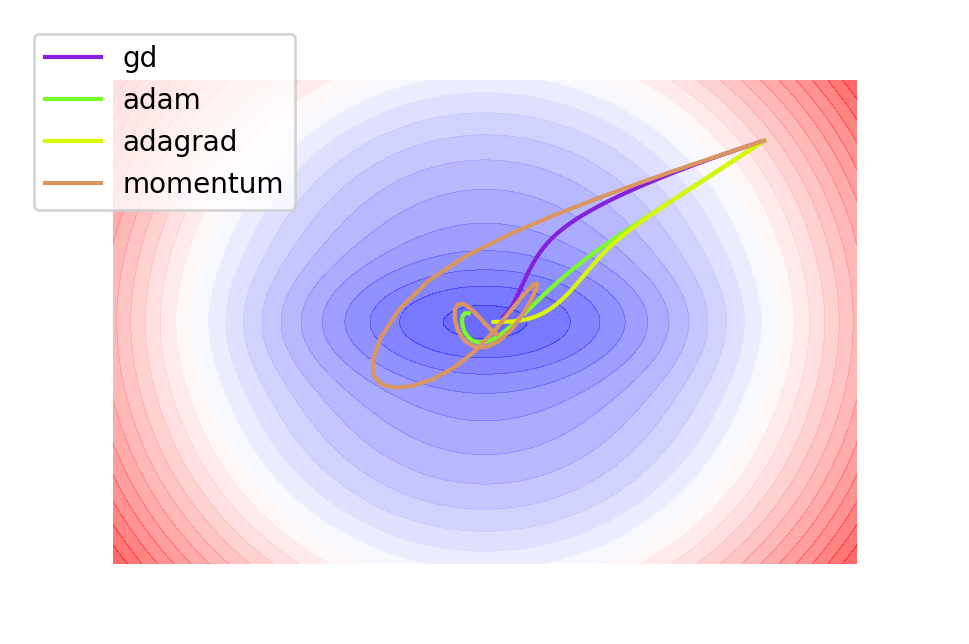

(256, 256)
(256, 256)
(256, 256)


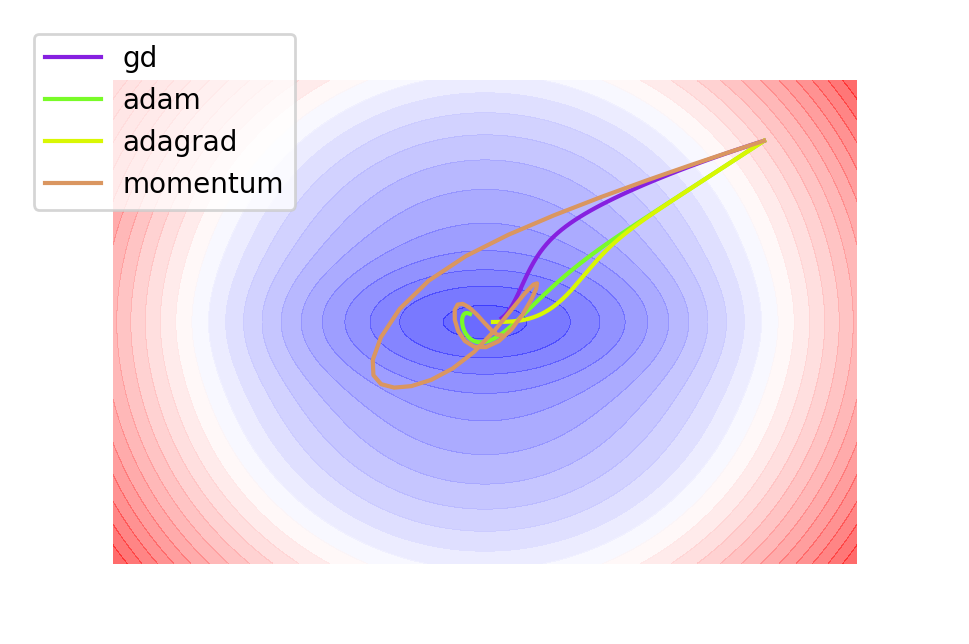

(256, 256)
(256, 256)
(256, 256)


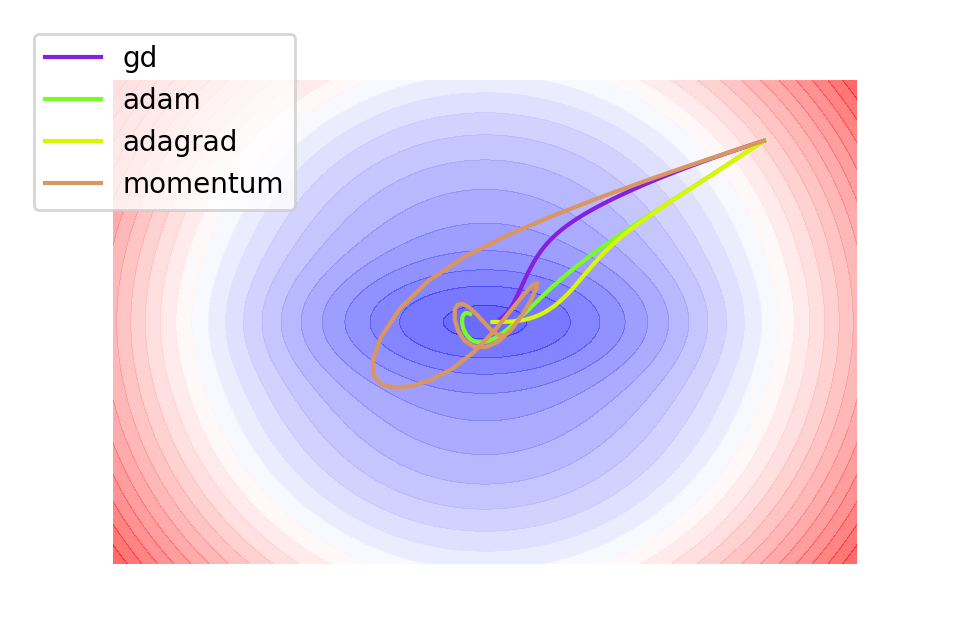

(256, 256)
(256, 256)
(256, 256)


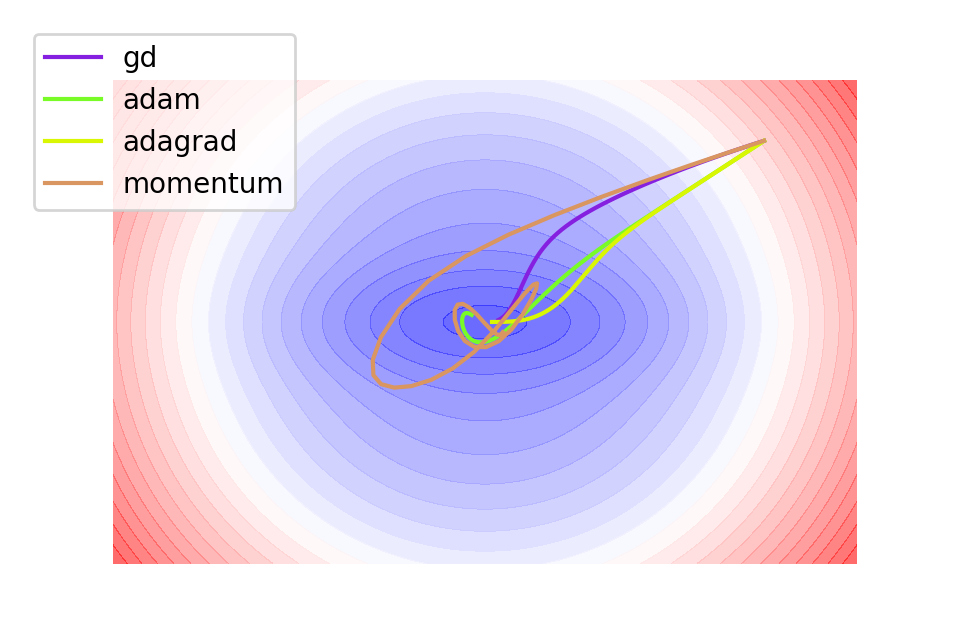

(256, 256)
(256, 256)
(256, 256)


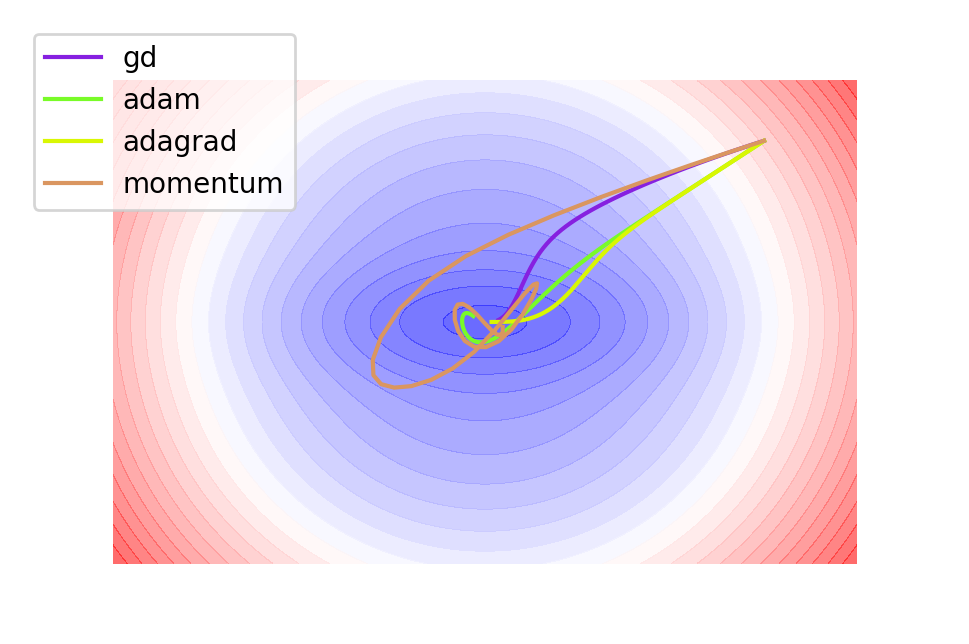

(256, 256)
(256, 256)
(256, 256)


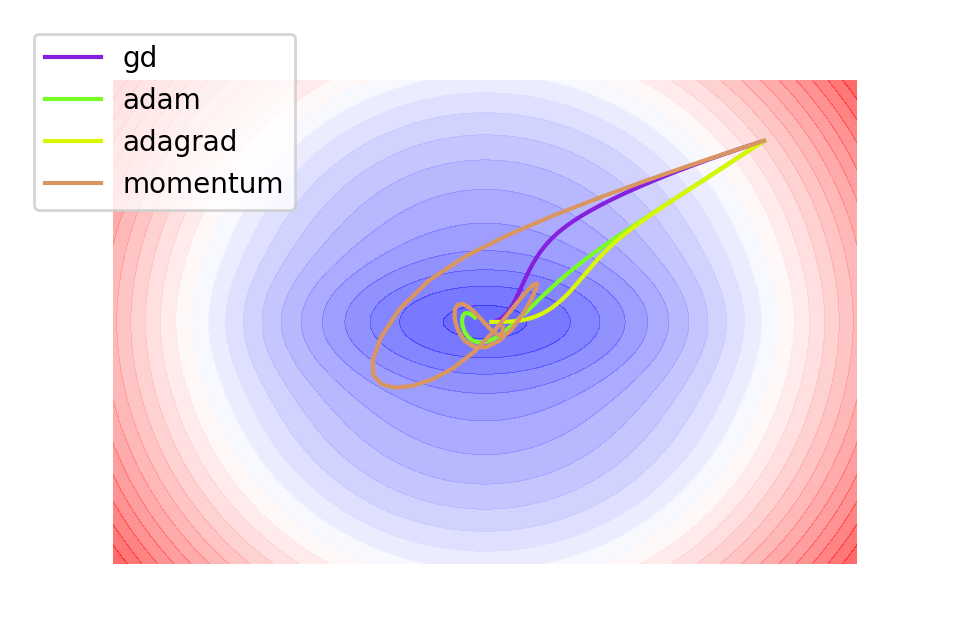

(256, 256)
(256, 256)
(256, 256)


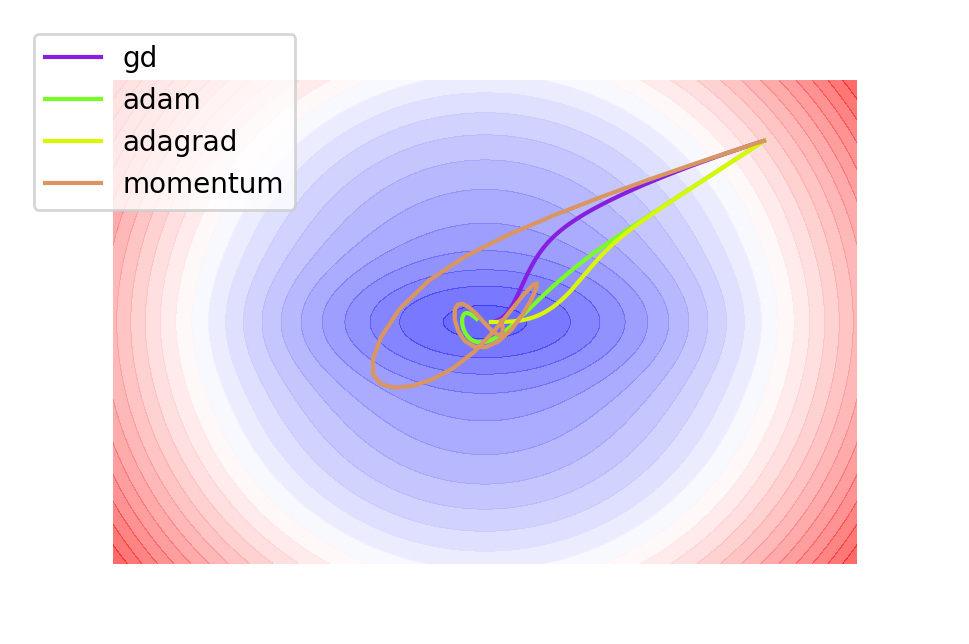

(256, 256)
(256, 256)
(256, 256)


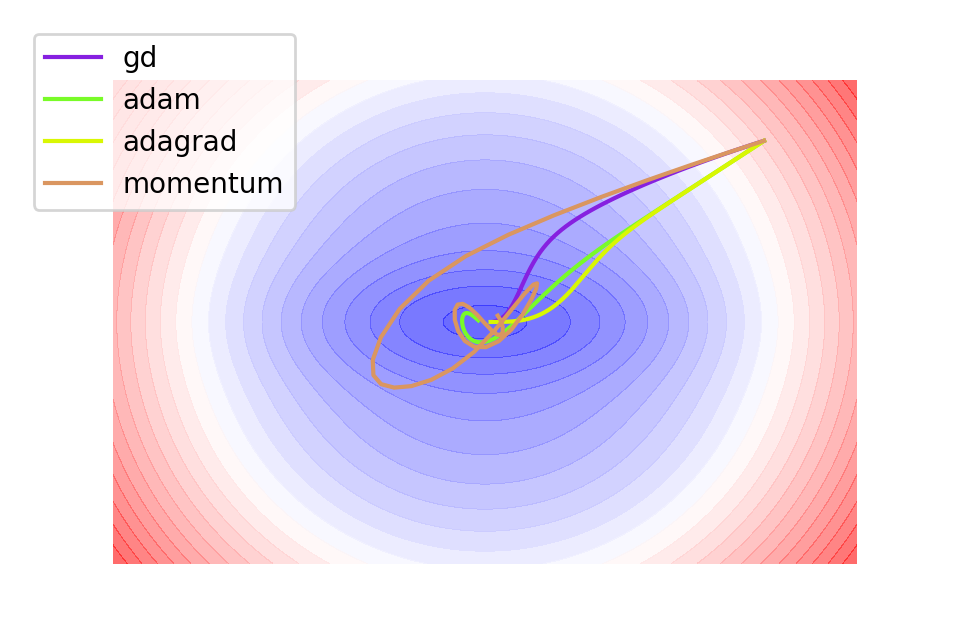

(256, 256)
(256, 256)
(256, 256)


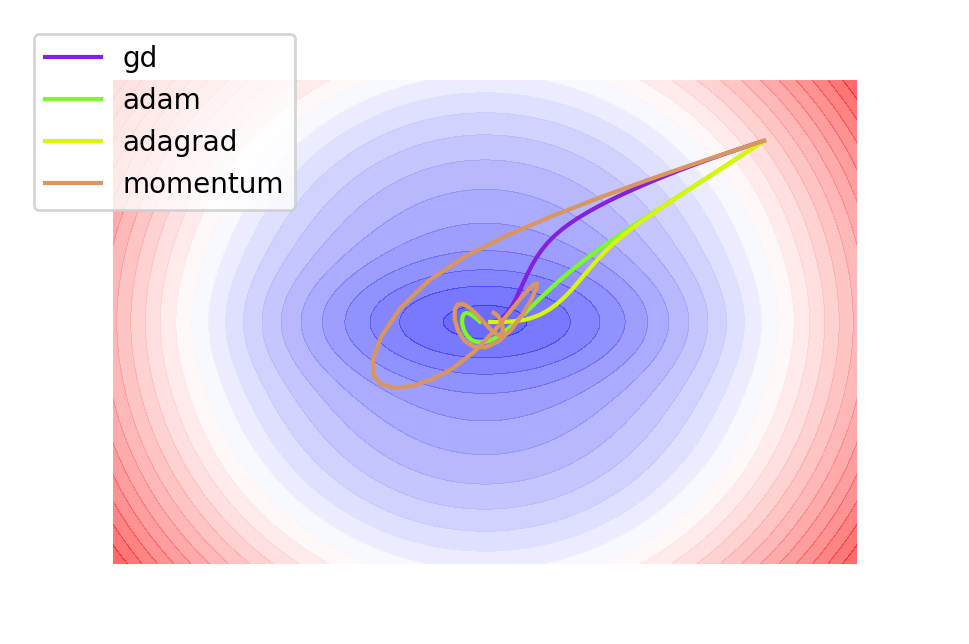

(256, 256)
(256, 256)
(256, 256)


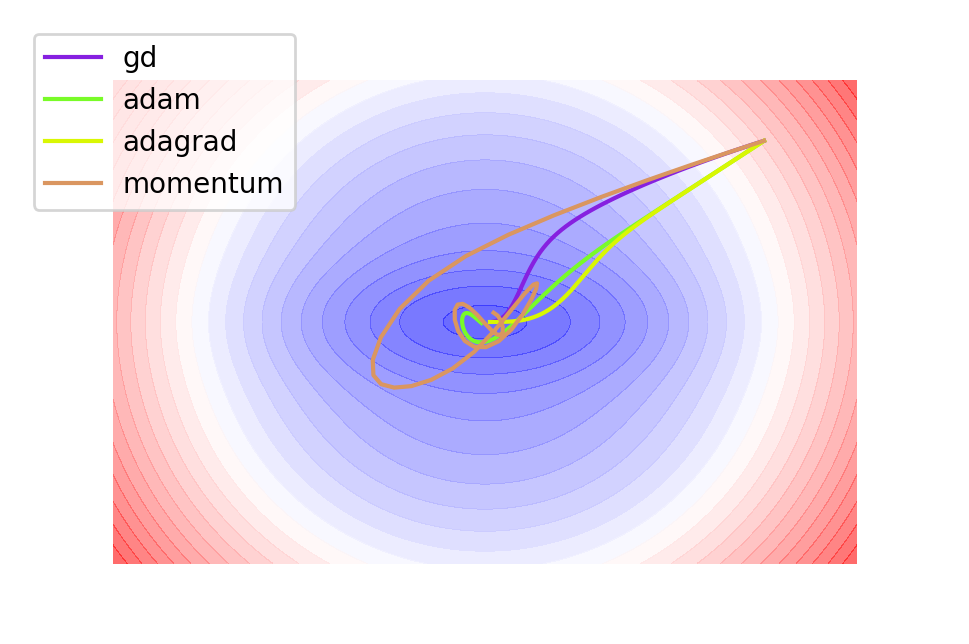

(256, 256)
(256, 256)
(256, 256)


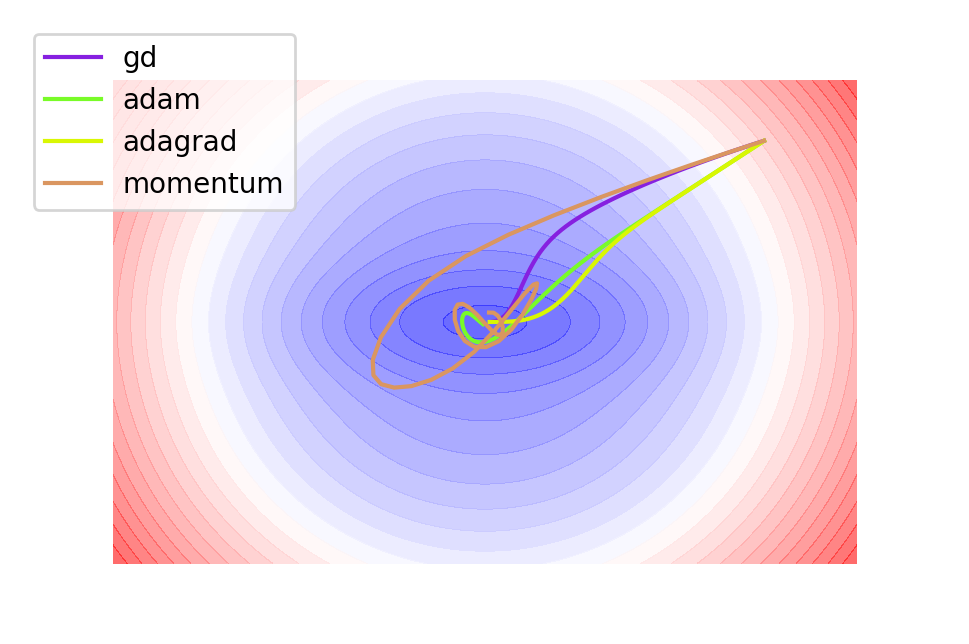

(256, 256)
(256, 256)
(256, 256)


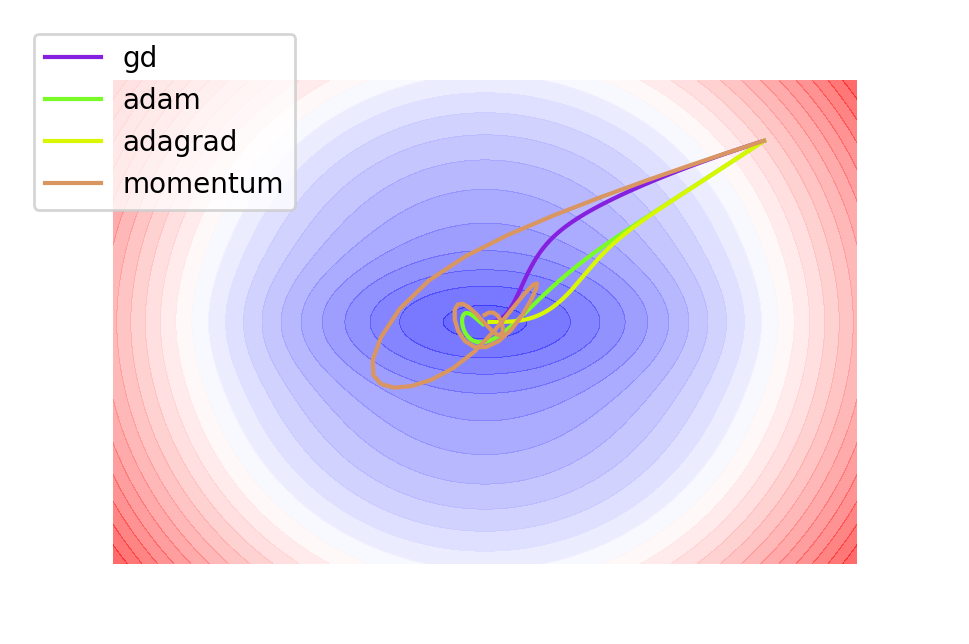

(256, 256)
(256, 256)
(256, 256)


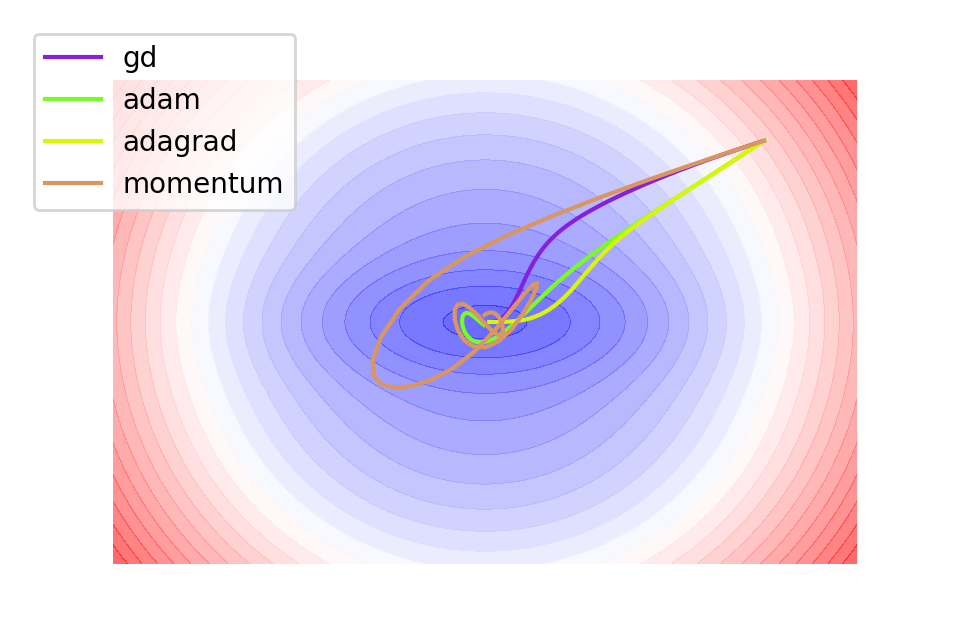

(256, 256)
(256, 256)
(256, 256)


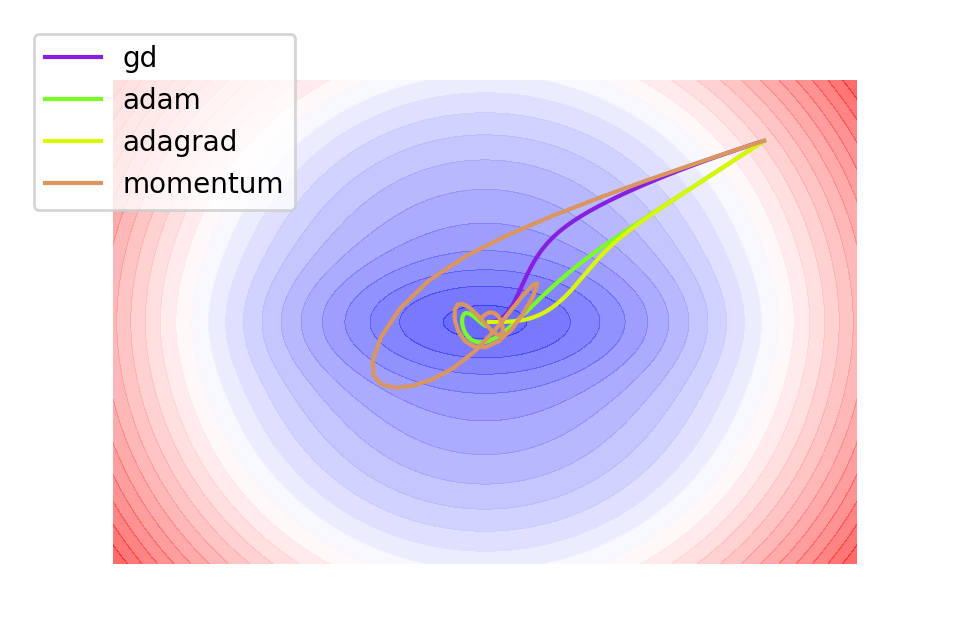

(256, 256)
(256, 256)
(256, 256)


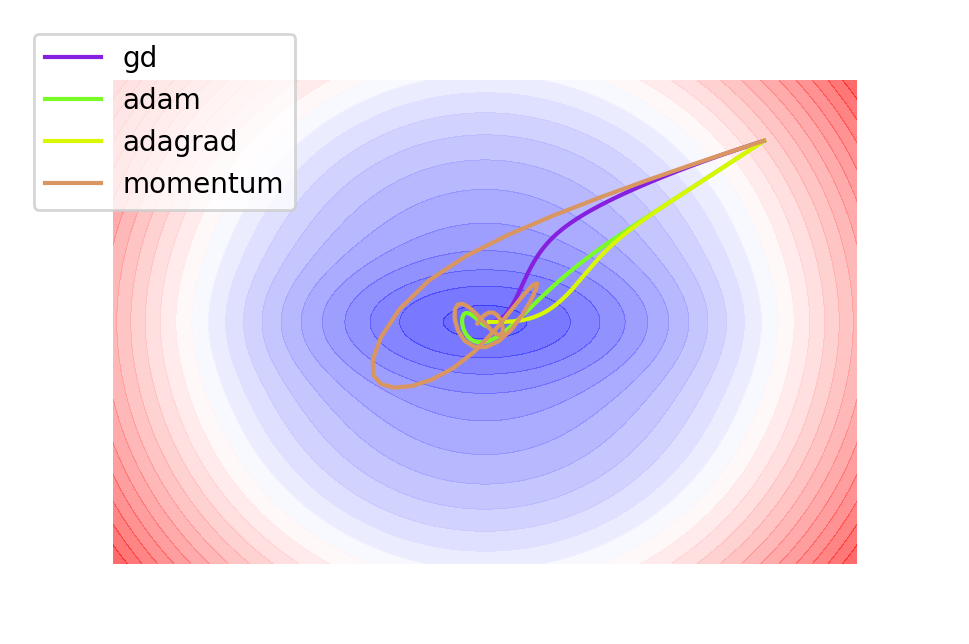

(256, 256)
(256, 256)
(256, 256)


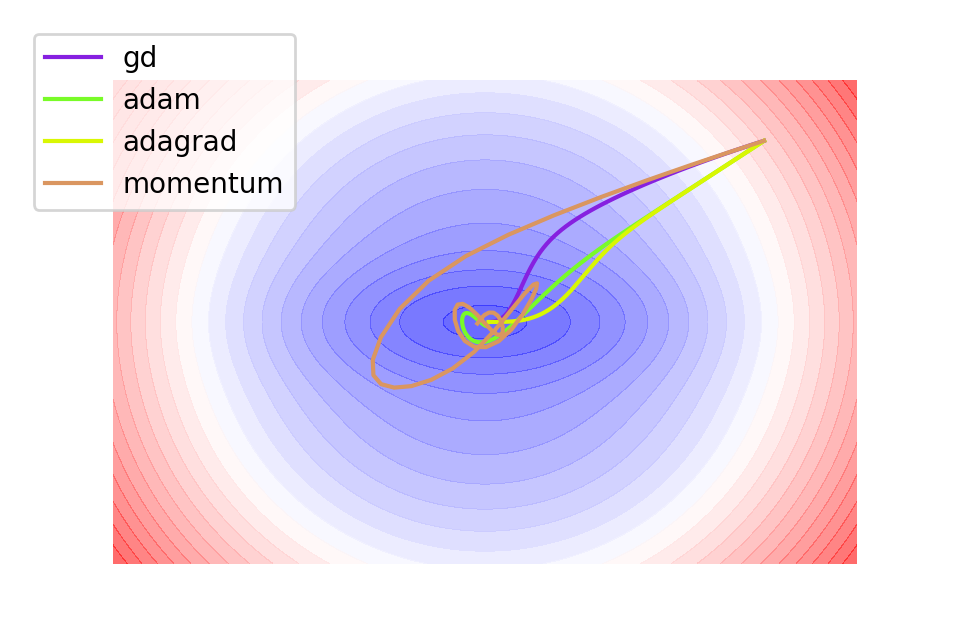

(256, 256)
(256, 256)
(256, 256)


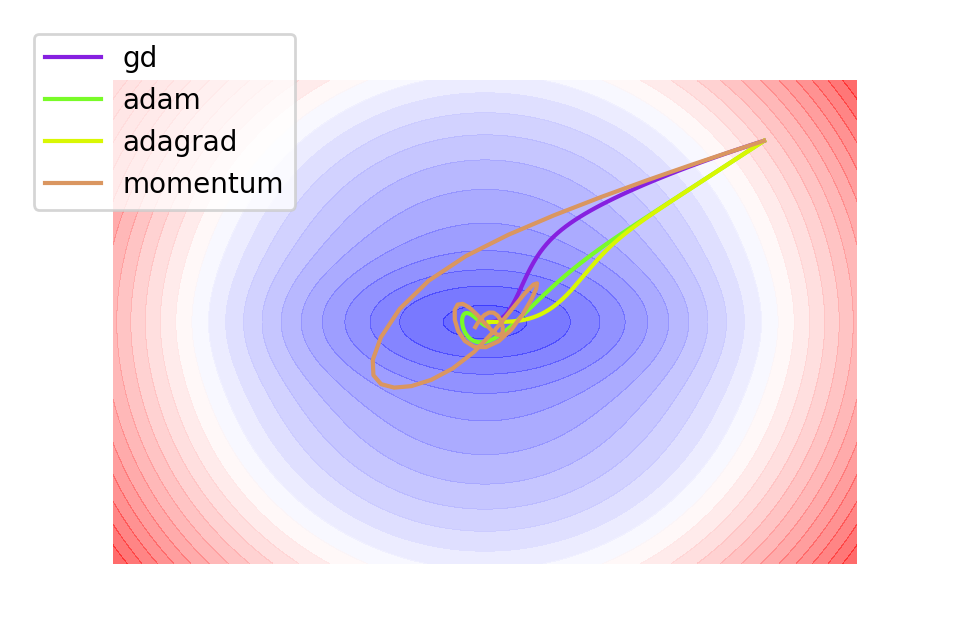

(256, 256)
(256, 256)
(256, 256)


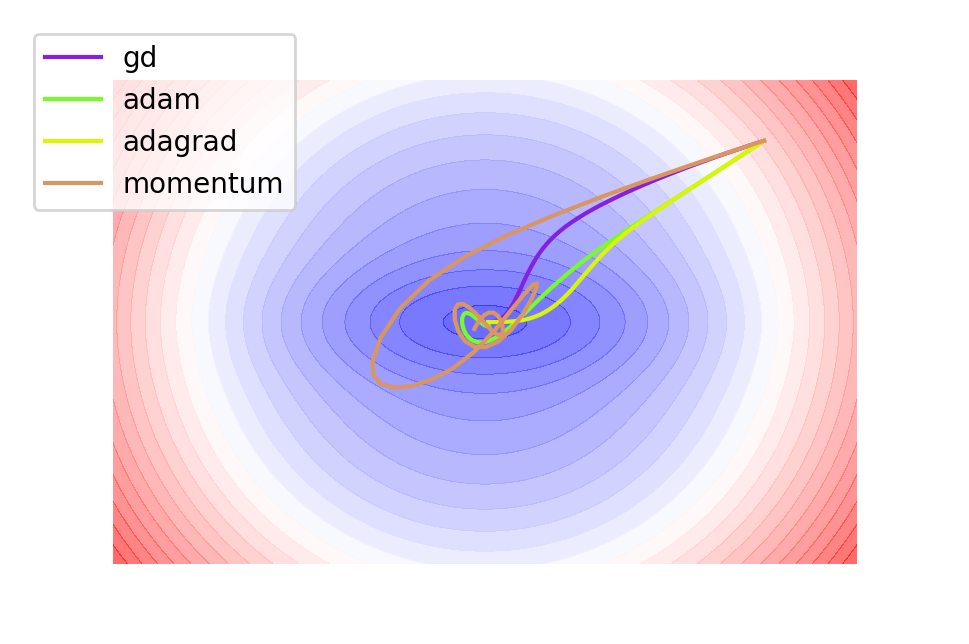

(256, 256)
(256, 256)
(256, 256)


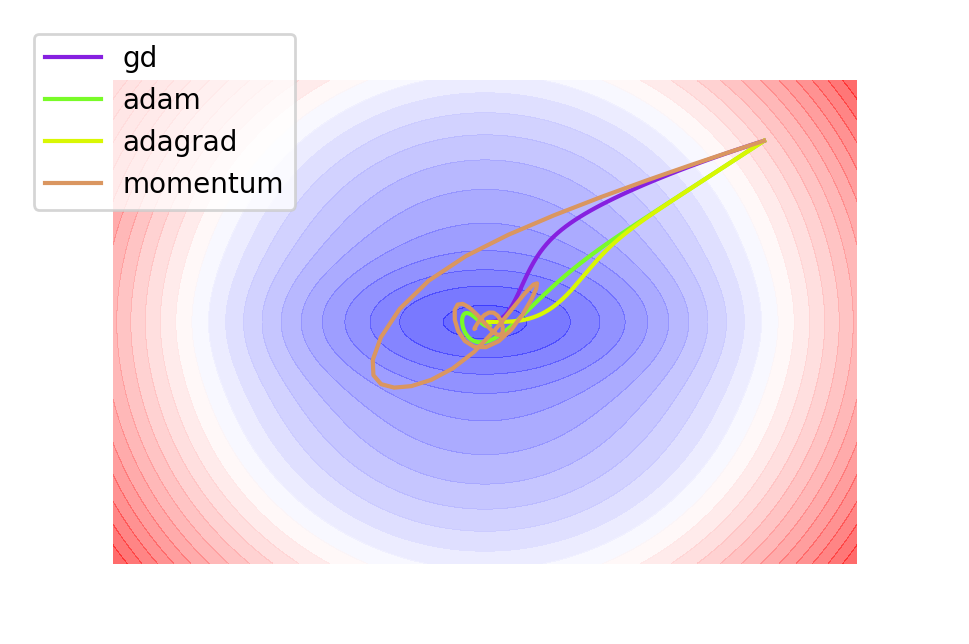

(256, 256)
(256, 256)
(256, 256)


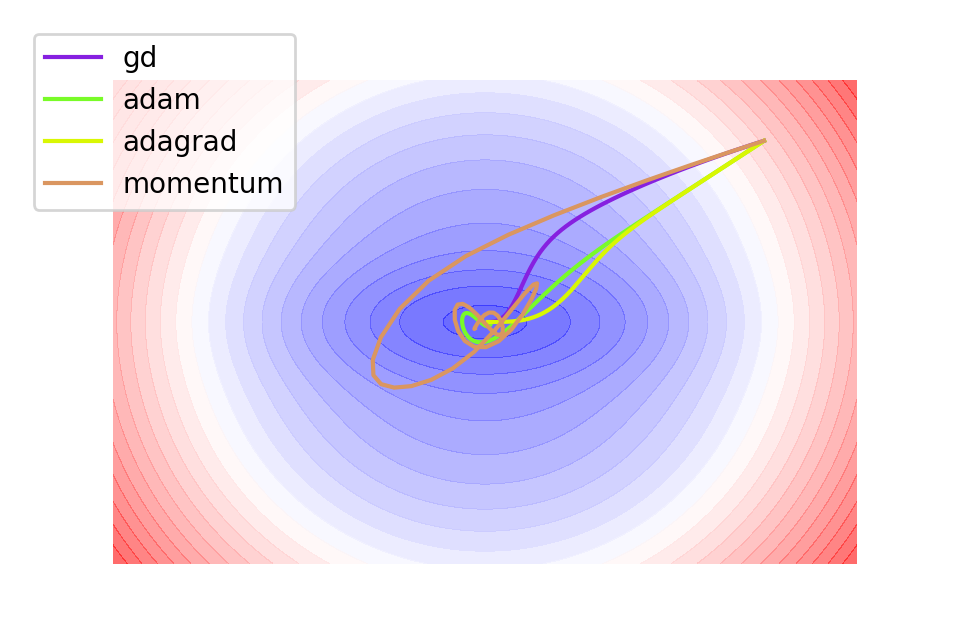

(256, 256)
(256, 256)
(256, 256)


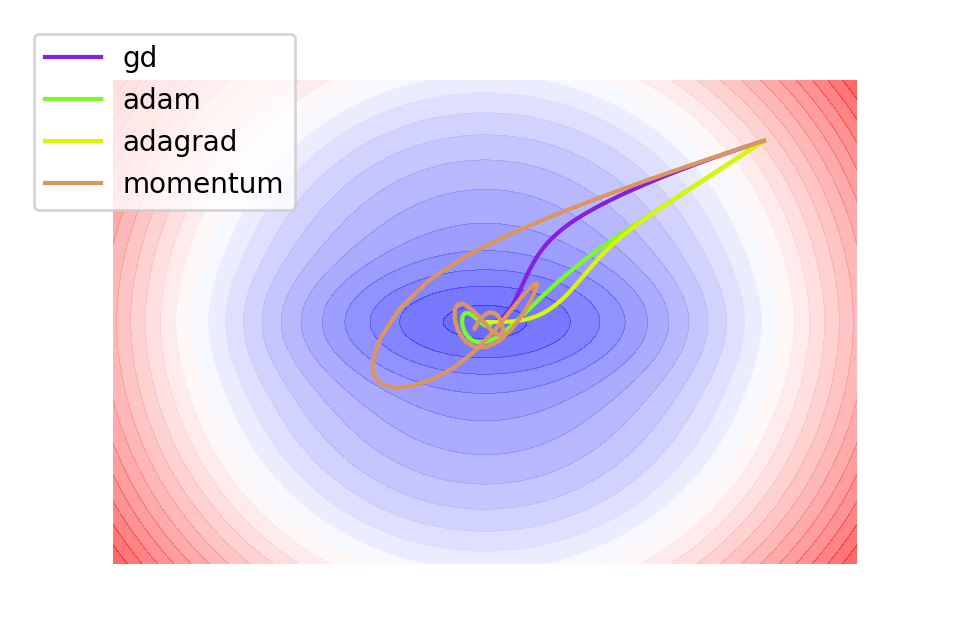

(256, 256)
(256, 256)
(256, 256)


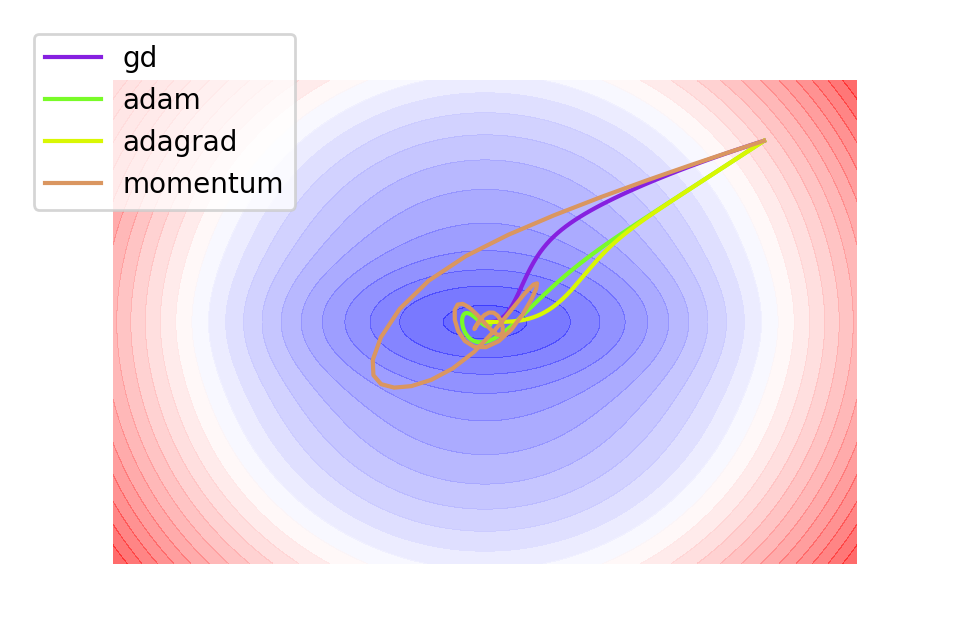

(256, 256)
(256, 256)
(256, 256)


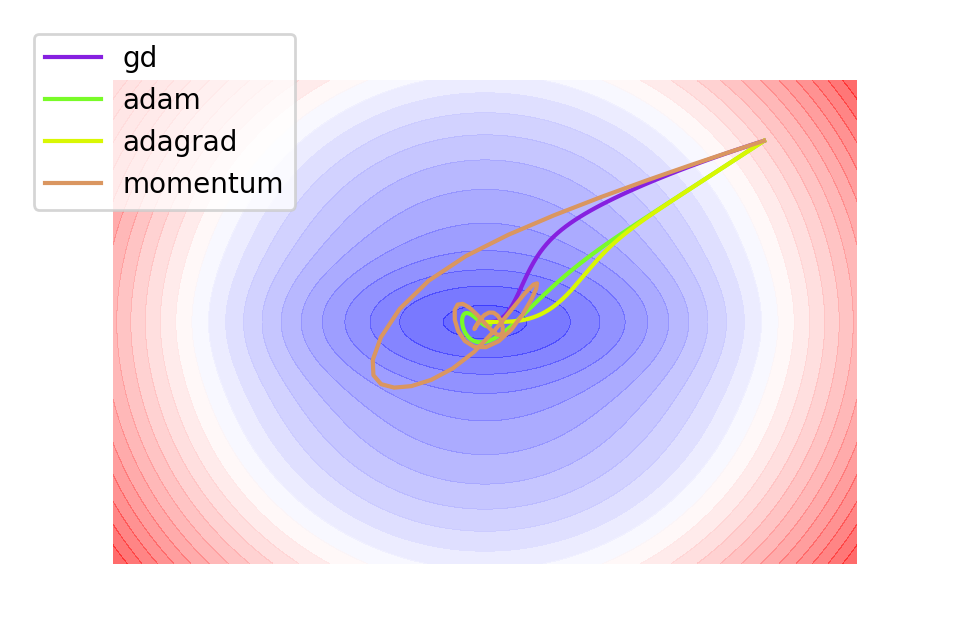

(256, 256)
(256, 256)
(256, 256)


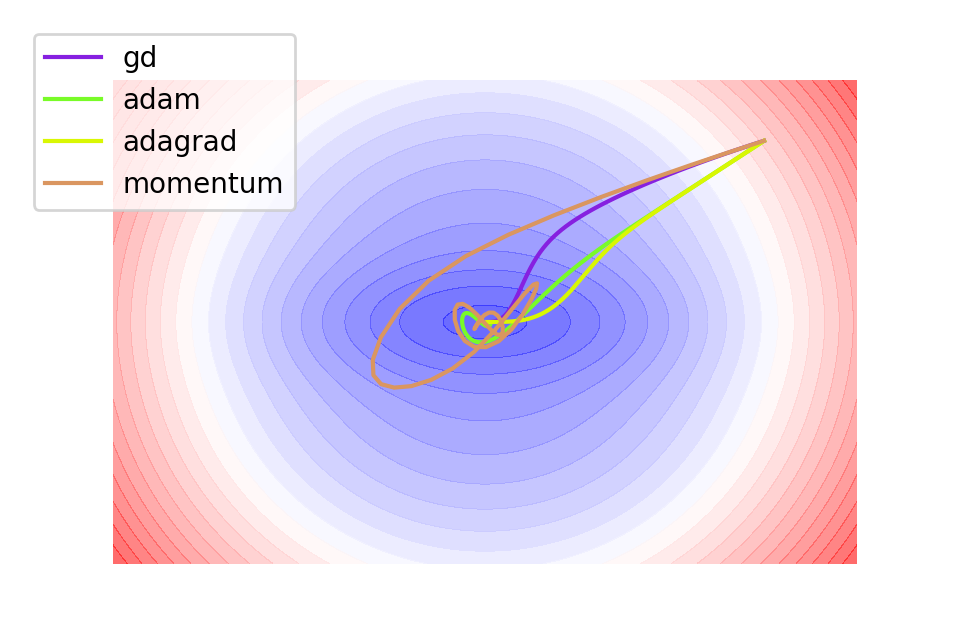

(256, 256)
(256, 256)
(256, 256)


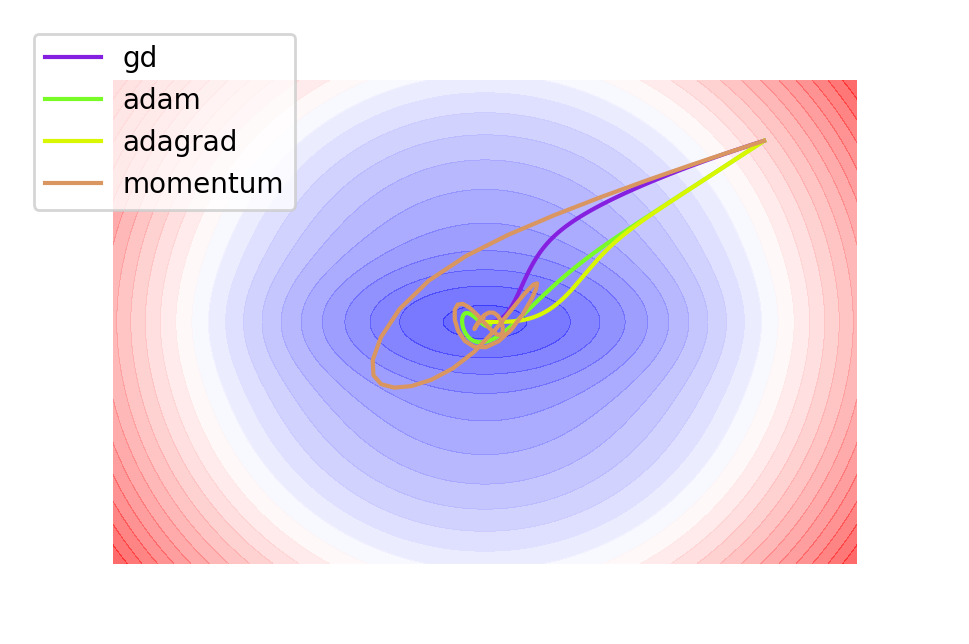

(256, 256)
(256, 256)
(256, 256)


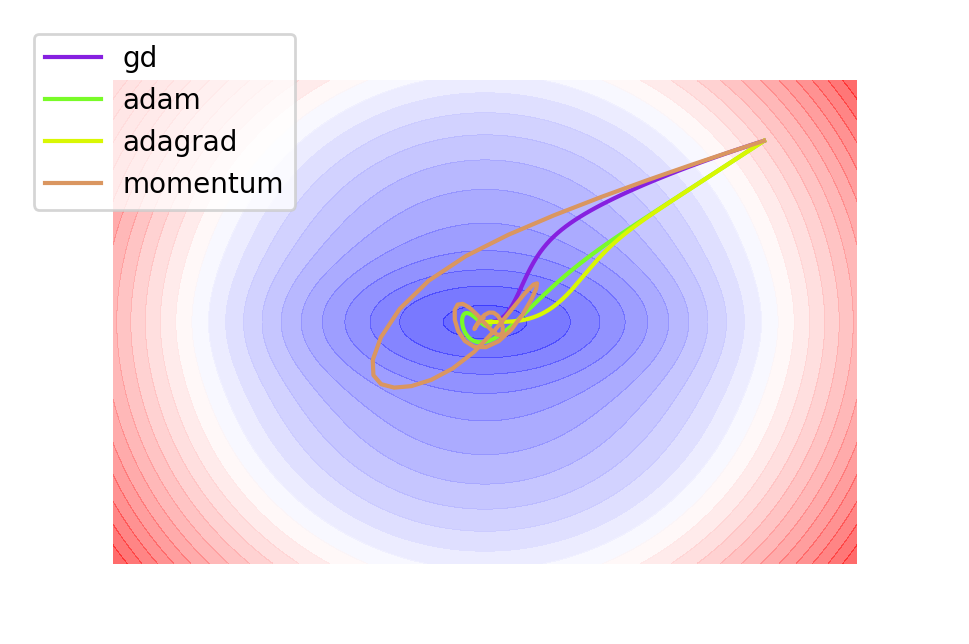

(256, 256)
(256, 256)
(256, 256)


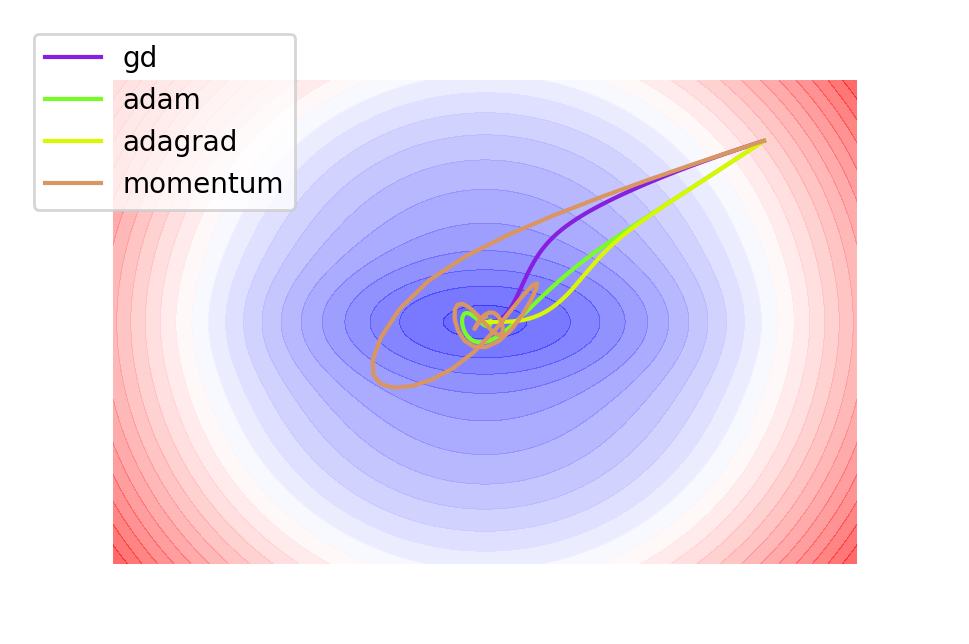

(256, 256)
(256, 256)
(256, 256)


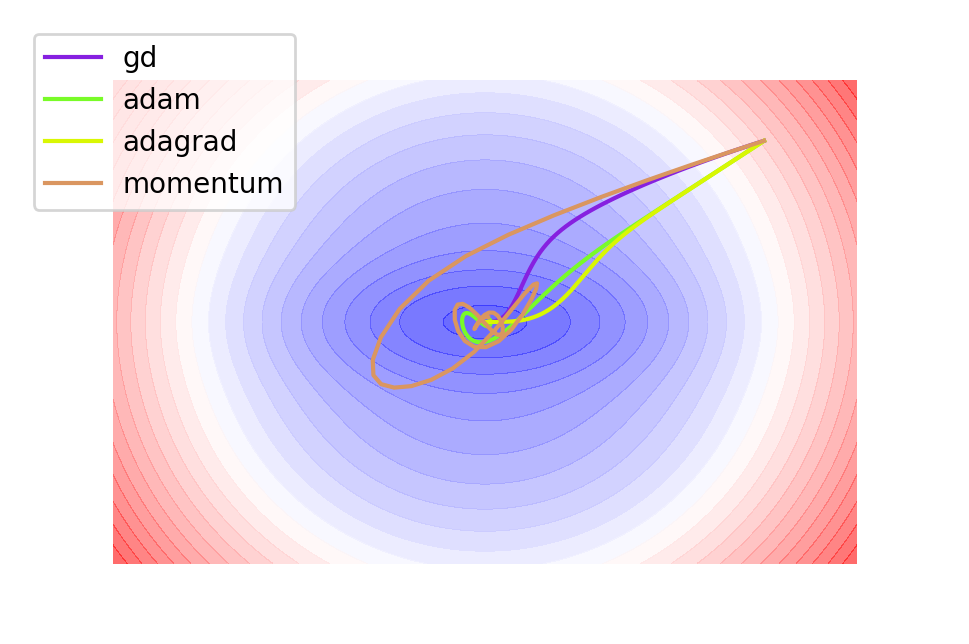

(256, 256)
(256, 256)
(256, 256)


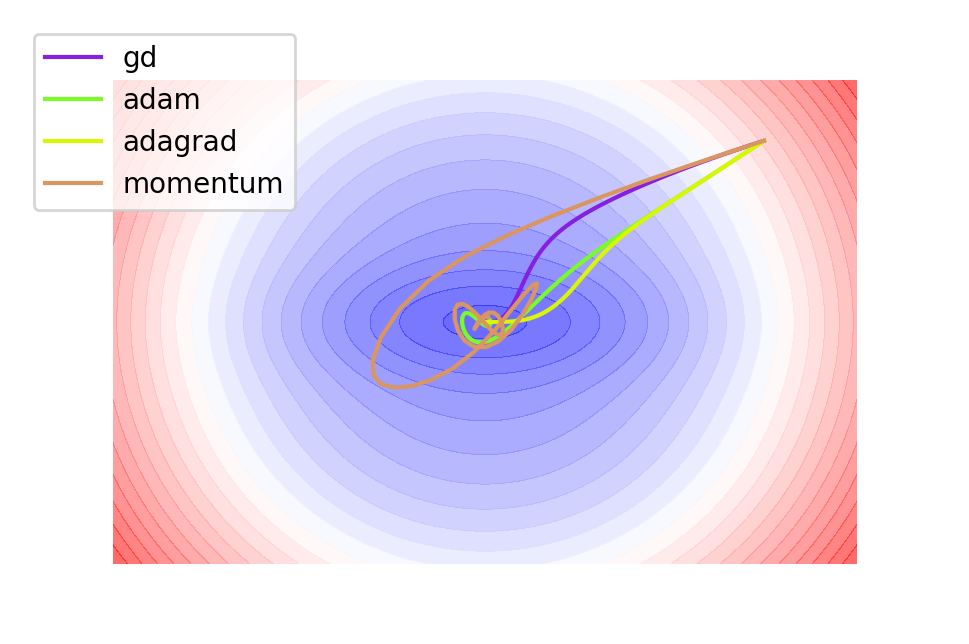

(256, 256)
(256, 256)
(256, 256)


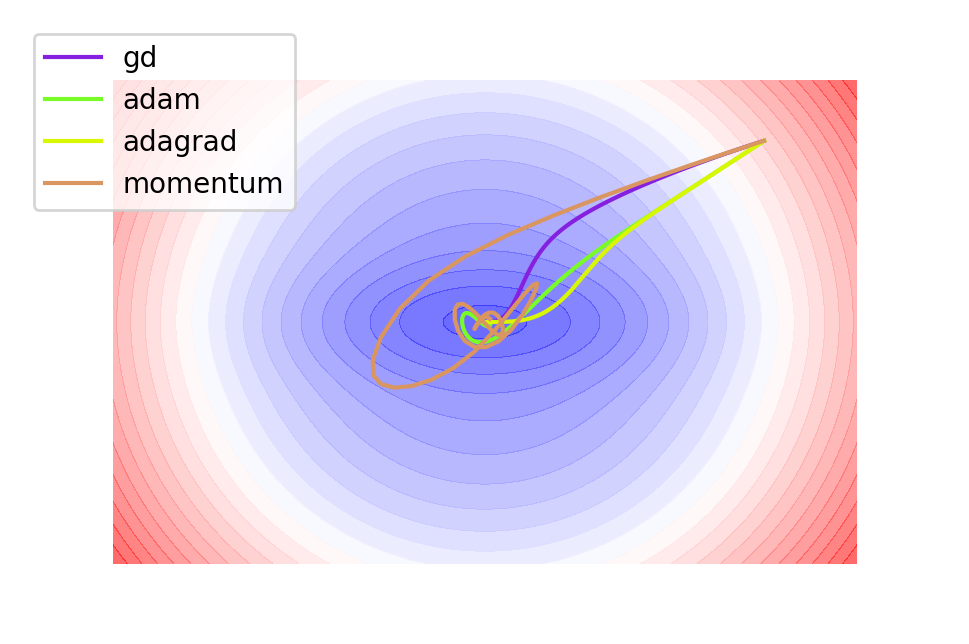

(256, 256)
(256, 256)
(256, 256)


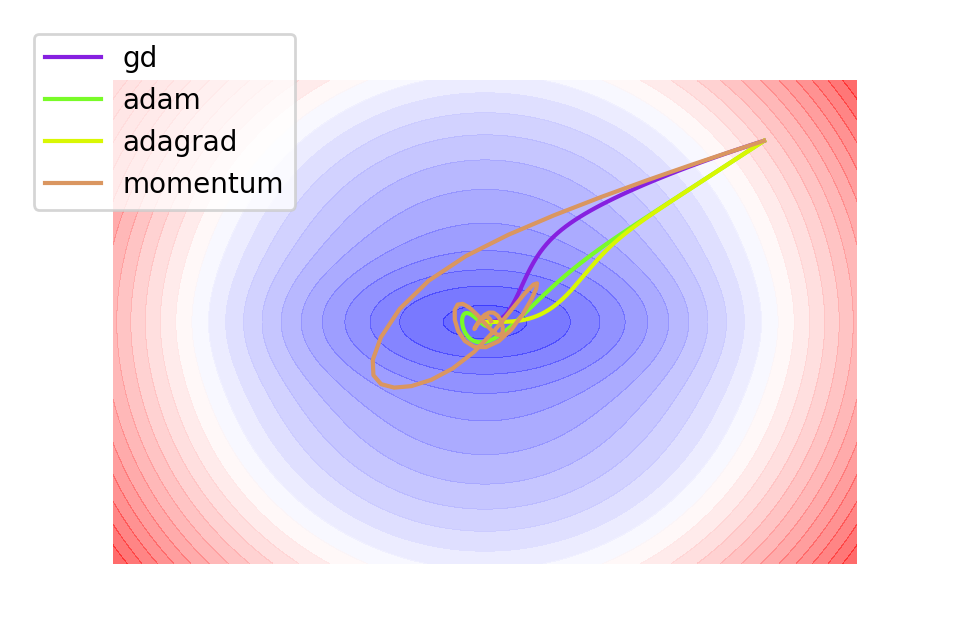

(256, 256)
(256, 256)
(256, 256)


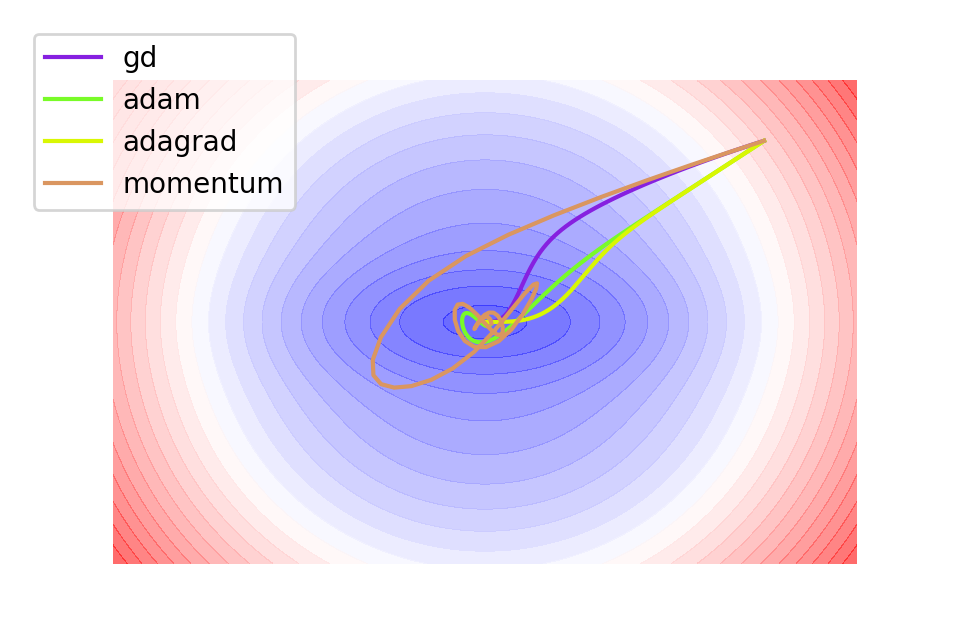

(256, 256)
(256, 256)
(256, 256)


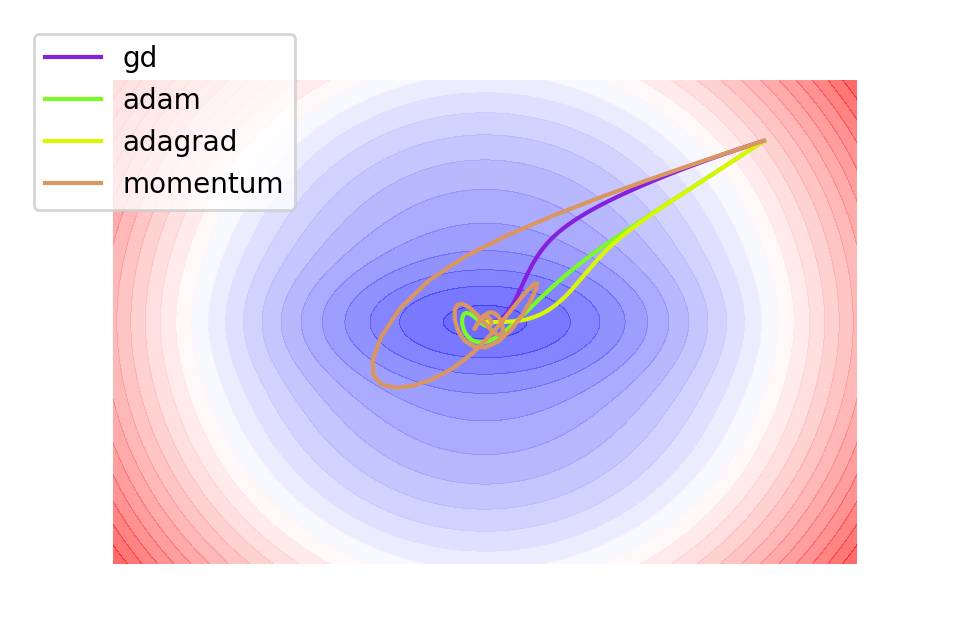

(256, 256)
(256, 256)
(256, 256)


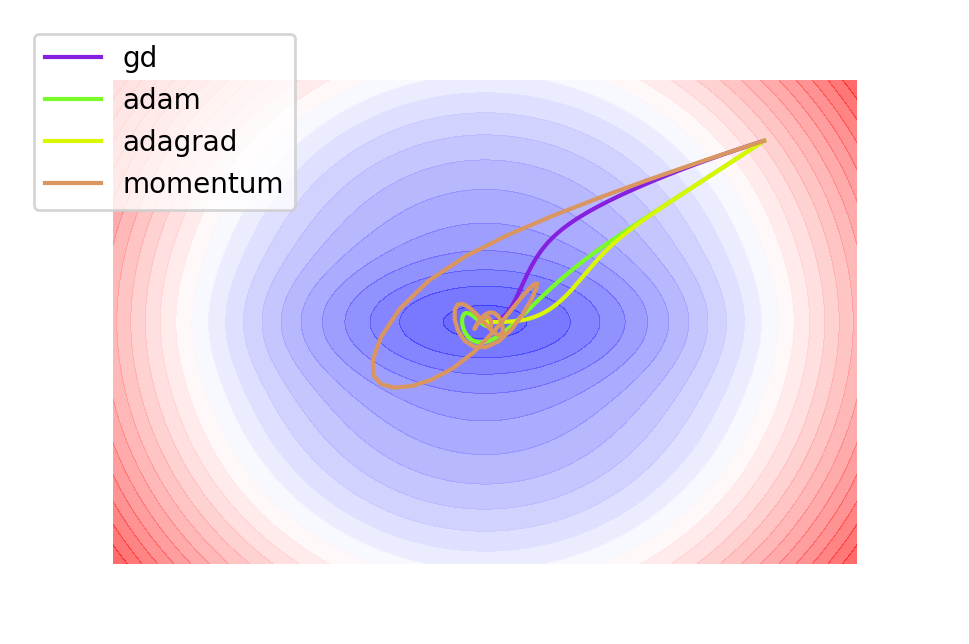

(256, 256)
(256, 256)
(256, 256)


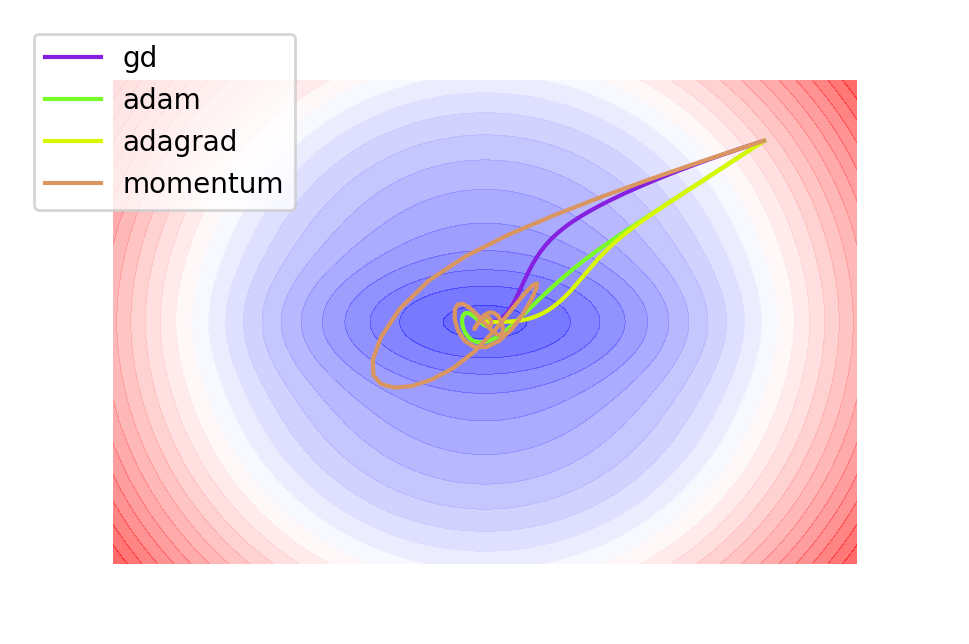

(256, 256)
(256, 256)
(256, 256)


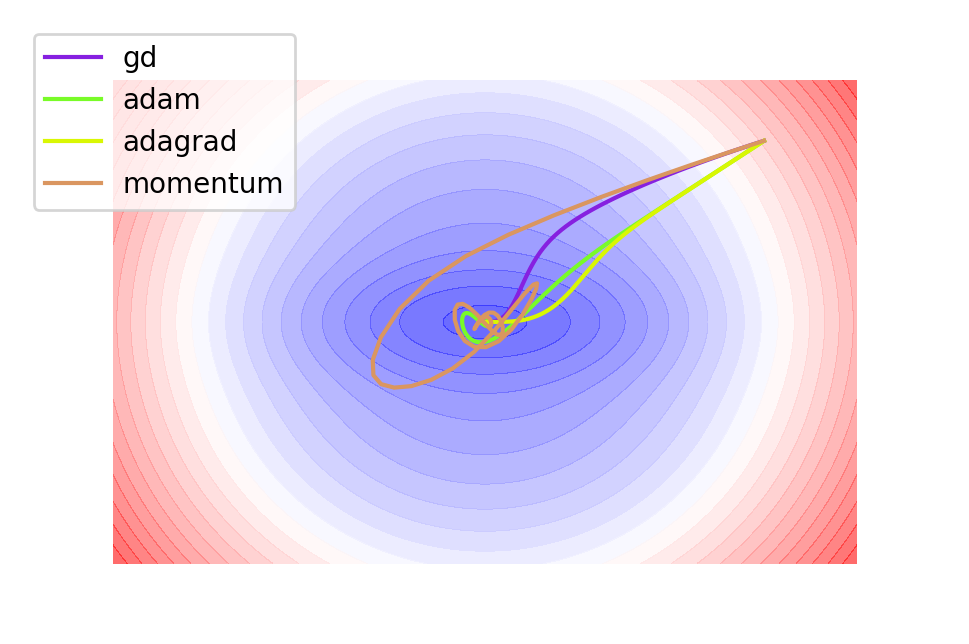

(256, 256)
(256, 256)
(256, 256)


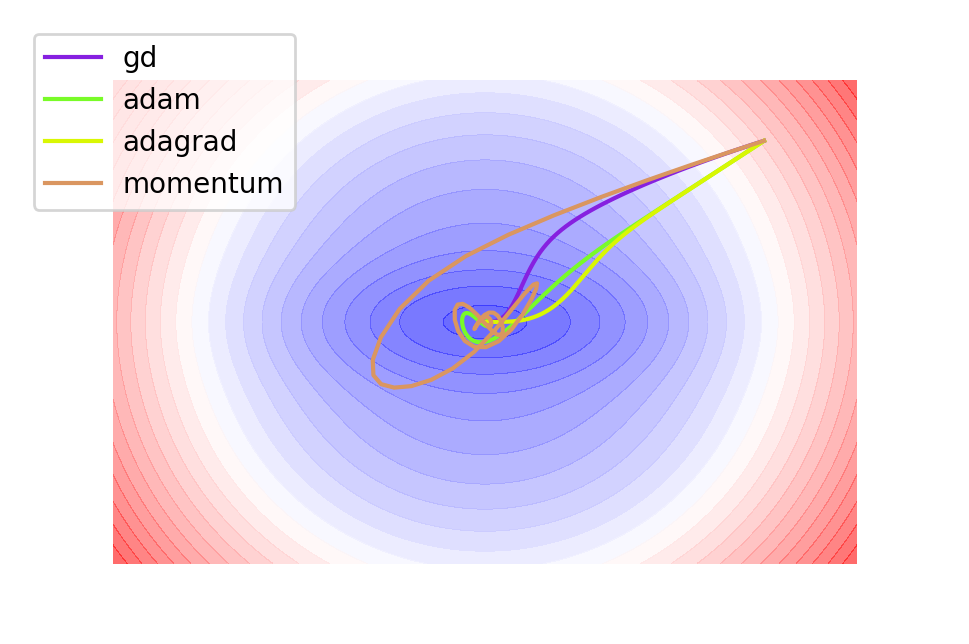

(256, 256)
(256, 256)
(256, 256)


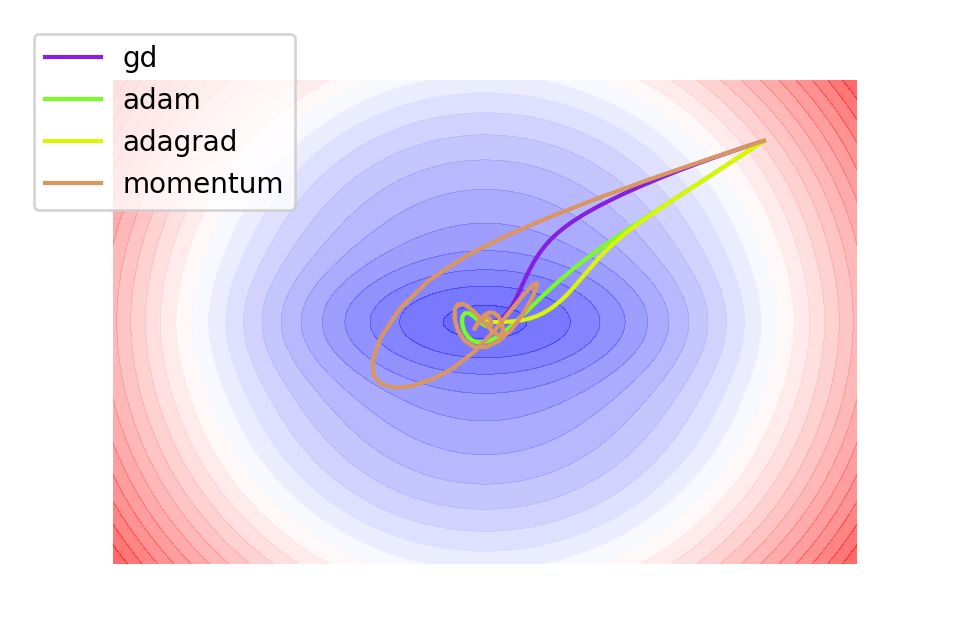

In [73]:
mm.create_gif()

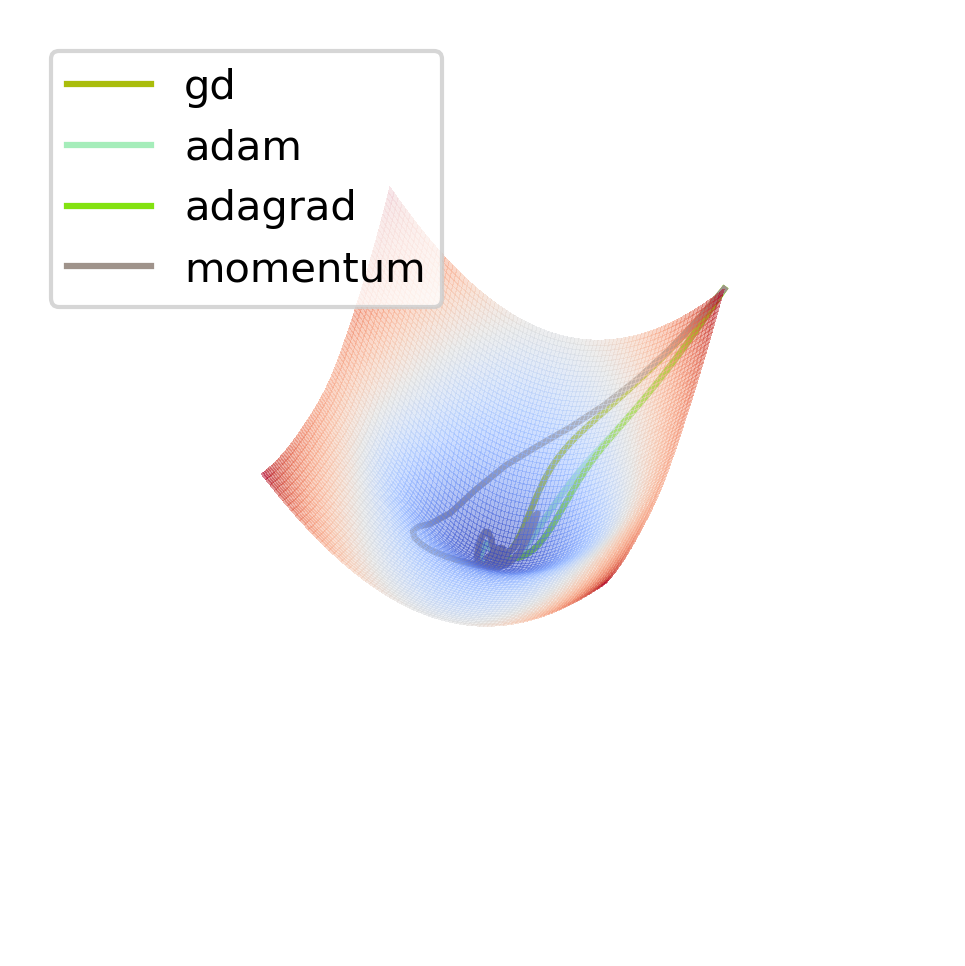

In [15]:
mm.plot3d(60, -70)

In [16]:
# visualize gd

f = lambda x: x**2

In [17]:
data = np.arange(-3, 3, 0.02)
lr = 0.1 # learning rate
gradient = lambda x: 2*x
pos = 2.5 # start position

In [18]:
points = []
points.append(pos)
while(pos**2 > 0.001):
    pos -= lr * gradient(pos)
    points.append(pos)

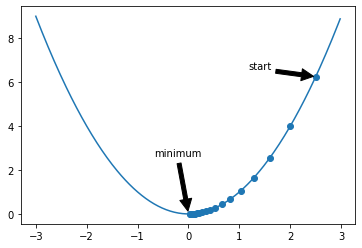

In [19]:
plt.plot(data, f(data))
plt.scatter(np.array(points), f(np.array(points)))
plt.annotate("start", xy=(points[0], f(points[0])), xycoords='data',
            xytext=(0.75, 0.75), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')
plt.annotate("minimum", xy=(0, 0), xycoords='data',
            xytext=(0.4, 0.3), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom')
plt.savefig("gd_ex1.png")

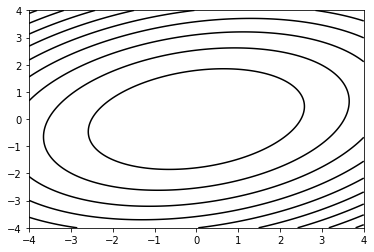

In [20]:
x = np.linspace(-4.0, 4.0, 200)
y = np.linspace(-4.0, 4.0, 200)
X, Y = np.meshgrid(x, y)
Z = ((X+Y) * (2**(1/2)))**2 + ((X-1.7*Y) * (2**(1/2)))**2
plt.contour(X, Y, Z, levels=10, colors="black")
plt.savefig("contour.png") # drawing the paths by hand

# simulations

Here the simulations of the different algorithms is done, as specified in chapter 4.2.

In [399]:
class weights_history(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.weights = []

    def on_epoch_end(self, epoch, logs={}):
        self.weights.append(self.model.layers[0].get_weights())

In [513]:
class min_function_s: # s stands for simulated data

    def __init__(self, learning_rate=0.1, optimizer="adam"):
        self.learning_rate = learning_rate
        self.optimizer = self.get_optimizer(optimizer)
        

    def build_model(self):
        return tf.keras.models.Sequential([
            tf.keras.layers.Dense(1, activation="relu", input_shape=(3,))
        ])
    
        
    def fit(self, x, y, epochs=50, batchsize=10):
        self.model = self.build_model()
        self.model.compile(loss=[tf.keras.losses.mean_squared_error, tf.keras.losses.mean_absolute_error], optimizer=self.optimizer, metrics=["mse", "mae"])
        cb = weights_history()
        hist = self.model.fit(x, y, epochs=epochs, verbose=0, callbacks=[cb])
        return cb.weights
    
    def get_optimizer(self, optimizer):
        opt = tf.keras.optimizers.get(optimizer)
        opt.lr = self.learning_rate
        return opt

In [514]:
# doing some simulations on the different algorithms and compare losses

# sampling from exponential distribution
x = np.random.exponential(size=(5000,3))
# y = X'theta + epsilon
# theta = (2, 1, 4)'
theta = np.array([2, 1, 4])
y = x @ theta + np.random.normal(scale=0.1)

In [515]:
h1, h2, h3, h4 = [], [], [], []
for k in range(20):
    mm1 = min_function_s(optimizer="adam")
    h1.append(mm1.fit(x, y))
    mm2 = min_function_s(optimizer="rmsProp")
    h2.append(mm2.fit(x, y))
    mm3 = min_function_s(optimizer = "adagrad")
    h3.append(mm3.fit(x, y))
    mm4 = min_function_s(optimizer = "sgd")
    h4.append(mm4.fit(x, y))

In [516]:
h1_mean = np.mean(h1, axis=0)
h2_mean = np.mean(h2, axis=0)
h3_mean = np.mean(h3, axis=0)
h4_mean = np.mean(h4, axis=0)
theta_hat_h1 = np.squeeze(np.array([h[0] for h in h1_mean]))
bias_hat_h1 = [h[1] for h in h1_mean]
theta_hat_h2 = np.squeeze(np.array([h[0] for h in h2_mean]))
bias_hat_h2 = [h[1] for h in h2_mean]
theta_hat_h3 = np.squeeze(np.array([h[0] for h in h3_mean]))
bias_hat_h3 = [h[1] for h in h3_mean]
theta_hat_h4 = np.squeeze(np.array([h[0] for h in h4_mean]))
bias_hat_h4 = [h[1] for h in h4_mean]

C:\Users\erwin\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


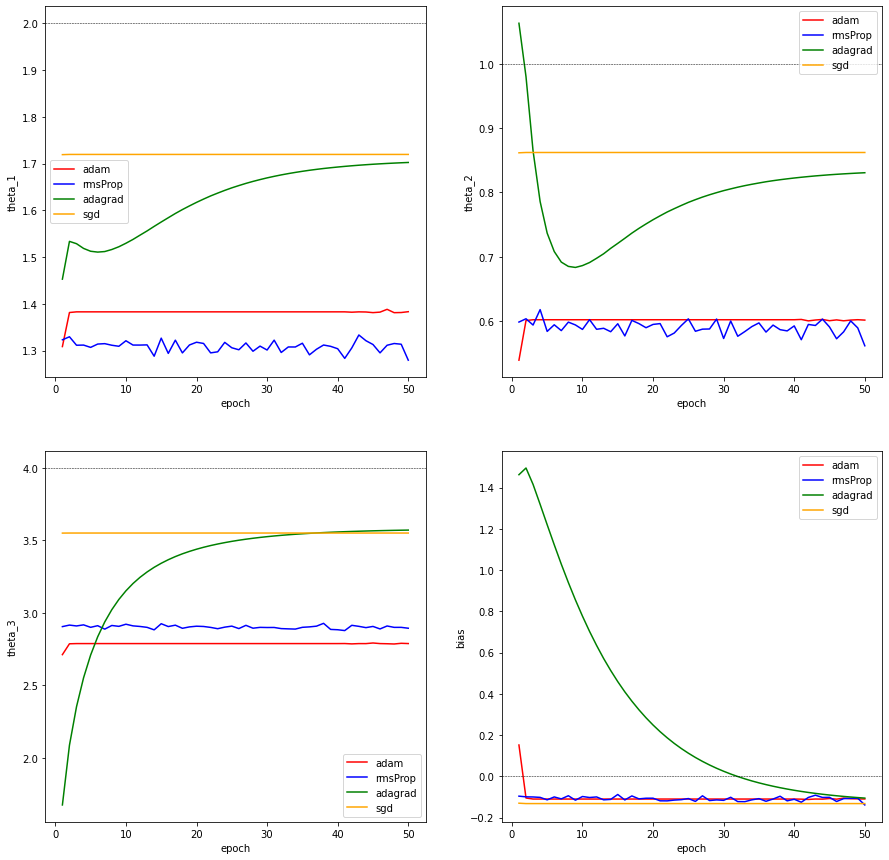

In [517]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0, 0].plot(np.arange(1, 51), theta_hat_h1[:,0], color='r', label="adam")
ax[0, 1].plot(np.arange(1, 51), theta_hat_h1[:,1], color='r', label="adam")
ax[1, 0].plot(np.arange(1, 51), theta_hat_h1[:,2], color='r', label="adam")
ax[1, 1].plot(np.arange(1, 51), bias_hat_h1, color='r', label="adam")
ax[0, 0].plot(np.arange(1, 51), theta_hat_h2[:,0], color='b', label="rmsProp")
ax[0, 1].plot(np.arange(1, 51), theta_hat_h2[:,1], color='b', label="rmsProp")
ax[1, 0].plot(np.arange(1, 51), theta_hat_h2[:,2], color='b', label="rmsProp")
ax[1, 1].plot(np.arange(1, 51), bias_hat_h2, color='b', label="rmsProp")
ax[0, 0].plot(np.arange(1, 51), theta_hat_h3[:,0], color='g', label="adagrad")
ax[0, 1].plot(np.arange(1, 51), theta_hat_h3[:,1], color='g', label="adagrad")
ax[1, 0].plot(np.arange(1, 51), theta_hat_h3[:,2], color='g', label="adagrad")
ax[1, 1].plot(np.arange(1, 51), bias_hat_h3, color='g', label="adagrad")
ax[0, 0].plot(np.arange(1, 51), theta_hat_h4[:,0], color='orange', label="sgd")
ax[0, 1].plot(np.arange(1, 51), theta_hat_h4[:,1], color='orange', label="sgd")
ax[1, 0].plot(np.arange(1, 51), theta_hat_h4[:,2], color='orange', label="sgd")
ax[1, 1].plot(np.arange(1, 51), bias_hat_h4, color='orange', label="sgd")
ax[0, 0].axhline(2, color='black', ls='--', lw=0.5)
ax[0, 1].axhline(1, color='black', ls='--', lw=0.5)
ax[1, 0].axhline(4, color='black', ls='--', lw=0.5)
ax[1, 1].axhline(0, color='black', ls='--', lw=0.5)
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[0,0].set_xlabel("epoch")
ax[0,1].set_xlabel("epoch")
ax[1,0].set_xlabel("epoch")
ax[1,1].set_xlabel("epoch")
ax[0,0].set_ylabel("theta_1")
ax[0,1].set_ylabel("theta_2")
ax[1,0].set_ylabel("theta_3")
ax[1,1].set_ylabel("bias")
plt.savefig('comparison.png')

In [518]:
# reformate the data
hh = []
for k in h4:
    zz = []
    for i in k:
        gg = []
        for j in i[0]:
            gg.append(j[0])
        zz.append(gg)
    hh.append(zz)

In [519]:
hh

[[[1.9993484, 0.9995591, 3.9995031],
  [1.999999, 0.99999917, 3.9999995],
  [2.0, 0.99999994, 3.9999998],
  [2.0, 1.0, 4.0],
  [2.0000002, 1.0, 4.0],
  [2.0, 1.0, 4.0],
  [2.0, 0.99999994, 4.0],
  [1.9999998, 0.99999994, 4.0],
  [1.9999999, 1.0, 4.0],
  [2.0, 1.0000001, 4.0],
  [2.0, 1.0000001, 4.0],
  [2.0, 1.0, 4.0],
  [2.0, 1.0, 4.0],
  [2.0, 1.0000001, 4.0],
  [2.0, 0.99999994, 4.0],
  [1.9999999, 1.0, 4.0],
  [2.0, 0.99999994, 4.0],
  [1.9999999, 1.0, 4.0],
  [2.0, 1.0, 4.0],
  [2.0, 1.0000001, 4.0],
  [2.0, 0.99999994, 4.0],
  [2.0, 1.0000001, 4.0],
  [2.0, 1.0000001, 4.0],
  [2.0, 0.99999994, 4.0],
  [2.0, 1.0, 4.0],
  [2.0000002, 1.0000001, 4.0],
  [2.0, 1.0, 4.0],
  [1.9999998, 0.99999994, 4.0],
  [2.0, 1.0000001, 4.0],
  [2.0, 0.9999999, 4.0],
  [2.0, 1.0, 4.0],
  [1.9999999, 1.0, 4.0],
  [2.0, 0.99999994, 4.0],
  [2.0, 1.0, 4.0],
  [2.0, 1.0000001, 4.0],
  [2.0, 1.0, 4.0000005],
  [2.0, 0.99999994, 4.0],
  [2.0, 0.99999994, 4.0],
  [2.0, 1.0, 4.0],
  [2.0, 1.0, 4.0],
  [2.0,

In [510]:
import pandas as pd
# printing summary stats for theta
df_describe = pd.DataFrame(np.mean(np.array(hh), axis=1))
print(df_describe.describe())

               0          1          2
count  20.000000  20.000000  20.000000
mean    1.300961   0.532996   2.627780
std     1.160186   0.849872   2.127005
min    -1.161239  -1.210705  -1.184551
25%     1.363470   0.630324   2.674388
50%     1.930871   0.985981   3.797112
75%     1.958200   1.014009   3.823697
max     1.986383   1.028341   3.910801


In [511]:
# reformate the data
hh = []
for k in h1:
    zz = []
    for i in k:
        gg = []
        for j in i[1]:
            gg.append(j)
        zz.append(gg)
    hh.append(zz)

In [512]:
# printing summary stats for the bias
df_describe = pd.DataFrame(np.mean(np.array(hh), axis=1))
print(df_describe.describe())

               0
count  20.000000
mean    0.114192
std     0.076019
min     0.000000
25%     0.020478
50%     0.149574
75%     0.171807
max     0.186259
